# Telecom Churn Case Study

#### Important Note:
Please install imblearn for class imbalanced handling using SMOTE ("pip install imblearn")

In [2]:
############################################################################################################################
##  
##  Program Name        : Telecom Churn Case Study
##
##  Description         : To predict the churn in the last (i.e. the ninth) month using the data (features) from the 
##                        first three months. To do this task well, understanding the typical customer behaviour during 
##                        churn will be helpful.
##
##  Author(s)           : Sudar Abisheck Saravanan
##                        Ashish Gupta
##                        Bibhuti Bhusan Sahu
##                        Sunil Yousef
##  
############################################################################################################################

import numpy as np # for linear algebra
import pandas as pd # for data processing, CSV file I/O (e.g. pd.read_csv)
import os, psutil, gc # for memory cleaning and garbage collection
import datetime
import seaborn as sns

# A backend should be set before importing pyplot in jupyter. 
# Or in other words, after changing the backend, pyplot needs to be imported again.
# Therefore call %matplotlib ... prior to importing pyplot.
%matplotlib inline
import matplotlib.pyplot as plt # for plotting

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA #Improting the PCA module
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor # for VIF

## Data Sourcing

Load and read telecom_churn_data.csv to a data frame

In [3]:
telecom_df = pd.read_csv('../Data/telecom_churn_data.csv', encoding="ascii")
telecom_df.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6     ...      sachet_3g_9  fb_user_6  \
0            9/30/2014  197.385     ...                0        1.0   
1            9/30/2014   34.047     ...                0        NaN   
2            9/30/2014  167.690     ...                0        NaN   
3            9/30/2014  221.338     ...                0        NaN   
4            9/30/2014  261.636     ...                0        0.0   

   fb_user_7  fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0        1.0        1.0        NaN   968        30.4         0.0      101.20   
1        1.0        1.0        NaN  1006         0.0         0.0        0.00   
2        NaN        NaN        1.0  1103         0.0         0.0        4.17   
3        NaN        NaN        NaN  2491         0.0         0.0        0.00   
4        NaN        NaN        NaN  1526         0.0         0.0        0.00   

   sep_vbc_3g  
0        3.58  
1        0.00  
2        0.00  
3        0.00  
4        0.00  

[5 rows x 226 columns]

Get the informations of loaded dataset.

In [4]:
nRow, nCol = telecom_df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 99999 rows and 226 columns


In [5]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


Get the description of data set

In [6]:
pd.set_option('display.max_columns', 250)
telecom_df.describe(include='all')

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count    9.999900e+04    99999.0         98981.0         98981.0   
unique            NaN        NaN             NaN             NaN   
top               NaN        NaN             NaN             NaN   
freq              NaN        NaN             NaN             NaN   
mean     7.001207e+09      109.0             0.0             0.0   
std      6.956694e+05        0.0             0.0             0.0   
min      7.000000e+09      109.0             0.0             0.0   
25%      7.000606e+09      109.0             0.0             0.0   
50%      7.001205e+09      109.0             0.0             0.0   
75%      7.001812e+09      109.0             0.0             0.0   
max      7.002411e+09      109.0             0.0             0.0   

        loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
count          98981.0                99999                99398   
unique             NaN                    1                    1   
top                NaN            6/30/2014            7/31/2014   
freq               NaN                99999                99398   
mean               0.0                  NaN                  NaN   
std                0.0                  NaN                  NaN   
min                0.0                  NaN                  NaN   
25%                0.0                  NaN                  NaN   
50%                0.0                  NaN                  NaN   
75%                0.0                  NaN                  NaN   
max                0.0                  NaN                  NaN   

       last_date_of_month_8 last_date_of_month_9        arpu_6        arpu_7  \
count                 98899                98340  99999.000000  99999.000000   
unique                    1                    1           NaN           NaN   
top               8/31/2014            9/30/2014           NaN           NaN   
freq                  98899                98340           NaN           NaN   
mean                    NaN                  NaN    282.987358    278.536648   
std                     NaN                  NaN    328.439770    338.156291   
min                     NaN                  NaN  -2258.709000  -2014.045000   
25%                     NaN                  NaN     93.411500     86.980500   
50%                     NaN                  NaN    197.704000    191.640000   
75%                     NaN                  NaN    371.060000    365.344500   
max                     NaN                  NaN  27731.088000  35145.834000   

              arpu_8        arpu_9   onnet_mou_6   onnet_mou_7   onnet_mou_8  \
count   99999.000000  99999.000000  96062.000000  96140.000000  94621.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean      279.154731    261.645069    132.395875    133.670805    133.018098   
std       344.474791    341.998630    297.207406    308.794148    308.951589   
min      -945.808000  -1899.505000      0.000000      0.000000      0.000000   
25%        84.126000     62.685000      7.380000      6.660000      6.460000   
50%       192.080000    176.849000     34.310000     32.330000     32.360000   
75%       369.370500    353.466500    118.740000    115.595000    115.860000   
max     33543.624000  38805.617000   7376.710000   8157.780000  10752.560000   

         onnet_mou_9  offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9  \
count   92254.000000  96062.000000  96140.000000  94621.000000  92254.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean      130.302327    197.935577    197.045133    

Lets check the first and last 5 rows of data set

In [7]:
telecom_df.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [8]:
telecom_df.tail()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
99994     7001548952        109             0.0             0.0   
99995     7000607688        109             0.0             0.0   
99996     7000087541        109             0.0             0.0   
99997     7000498689        109             0.0             0.0   
99998     7001905007        109             0.0             0.0   

       loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
99994             0.0            6/30/2014            7/31/2014   
99995             0.0            6/30/2014            7/31/2014   
99996             0.0            6/30/2014            7/31/2014   
99997             0.0            6/30/2014            7/31/2014   
99998             0.0            6/30/2014            7/31/2014   

      last_date_of_month_8 last_date_of_month_9   arpu_6   arpu_7   arpu_8  \
99994            8/31/2014            9/30/2014   18.471   69.161   57.530   
99995            8/31/2014            9/30/2014  112.201   77.811   79.081   
99996            8/31/2014            9/30/2014  229.187    0.000    0.000   
99997            8/31/2014            9/30/2014  322.991  303.386  606.817   
99998            8/31/2014            9/30/2014  687.065    0.000    0.000   

        arpu_9  onnet_mou_6  onnet_mou_7  onnet_mou_8  onnet_mou_9  \
99994   29.950         5.40         3.36         5.91         0.00   
99995  140.835        29.26        18.13        16.06        49.49   
99996    0.000         1.11          NaN          NaN          NaN   
99997  731.010         0.00         0.00         0.00         0.00   
99998    0.000        84.34          NaN          NaN          NaN   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  \
99994         15.19         54.46         52.79         27.14            0.0   
99995        100.83         69.01         66.39         56.13            0.0   
99996         21.04           NaN           NaN           NaN            0.0   
99997          0.00          0.00          0.00          0.00            0.0   
99998        166.46           NaN           NaN           NaN            0.0   

       roam_ic_mou_7  roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  \
99994            0.0            0.0           0.00            0.0   
99995            0.0            0.0           0.95            0.0   
99996            NaN            NaN            NaN            0.0   
99997            0.0            0.0           0.00            0.0   
99998            NaN            NaN            NaN            0.0   

       roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  \
99994            0.0            0.0           0.00              5.40   
99995            0.0            0.0           4.23             28.93   
99996            NaN            NaN            NaN              1.11   
99997            0.0            0.0           0.00              0.00   
99998            NaN            NaN            NaN             84.34   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  loc_og_t2m_mou_6  \
99994              3.36              5.91              0.00             12.78   
99995             18.13             16.06             49.49             91.34   
99996               NaN               NaN               NaN             13.33   
99997              0.00              0.00              0.00              0.00   
99998               NaN               NaN               NaN            166.46   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  loc_og_t2f_mou_6  \
99994             54.46             49.58             24.78              0.00   
99995             47.53             57.51             46.71              1.71   
99996               NaN               NaN               NaN              0.00   
99997              0.00              0.00              0.00              0.00   
99998               NaN               NaN               NaN              0.00   

       l

## User Defined Functions

#### Function for calculating vif value

In [9]:
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    #from statsmodels.stats.outliers_influence import variance_inflation_factor
    X = input_data.drop([dependent_col], axis=1)
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame(columns = ['Var', 'Vif'])
    vif["Var"] = X.columns
    vif["Vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False).round(2)

#### Function to drop column and redo the logistic as it might get repeated many times

In [10]:
#UDF to drop column and redo the logistic as it might get repeated many times
def RedoLogisticModel(ColumnToDrop):
    dropColumns(X_train_final,ColumnToDrop)
    logsk1 = LogisticRegression(solver='liblinear')
    logsk1.fit(X_train_final, y_train)
    logm1 = sm.GLM(y_train,(sm.add_constant(X_train_final)), family = sm.families.Binomial())
    print(logm1.fit().summary())
    return logsk1

#### Function to drop one or more columns

In [11]:
def dropColumns(df, column_list):
    for column in column_list:
        print('Dropping', column, '...')
        try:
            df.drop(column, axis=1, inplace=True)
        except:
            print('\tColumn already dropped...')
            continue

#### Function to get the memory usage of this program

In [12]:
def mem_usage():
    if 'win' in os.sys.platform:
        process = psutil.Process(os.getpid())
        return process.memory_info()[0] / float(2 ** 20)
    else:
        print('Only supported in windows')

#### Function for plotting Distribution graphs (histogram/bar graph) of column data

In [13]:
# histogram / bar graph of features repersented in column data
def plotGraphForEachFeature(df, nGraphShown, nGraphPerRow):
    %matplotlib inline
    import matplotlib.pyplot as plt
    # Restore the rc params from Matplotlib’s internal defaults.
    plt.rcdefaults()
    nunique = df.nunique()
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 4 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
        del[[columnDf]]
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    del[[columnNames]]
    gc.collect()

#### Function for plotting Scatter and density plots

In [14]:
# Scatter and density plots
def plotScatterForEachFeature(df, hue, plotSize=4, colcount=1):
    %matplotlib inline
    import matplotlib.pyplot as plt
    # Restore the rc params from Matplotlib’s internal defaults.
    plt.rcdefaults()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    loopCount = 1
    if len(columnNames) > colcount: # show scatter plot for colcount rows at a time
        loopCount = round(len(columnNames)/colcount)
    print(f"Plotting {loopCount} row(s) of scatter and density plots...")
    for index in range(0, loopCount):
        tempcolumnNames = columnNames[index*colcount:(index*colcount)+colcount]
        if hue not in tempcolumnNames:
            tempcolumnNames.append(hue)
        else:
            continue
        df1 = df[tempcolumnNames]
        # paiwise scatter plot
        plt.figure(figsize=[plotSize, plotSize])
        ax = sns.pairplot(df1, hue=hue)
        plt.suptitle(f'Scatter and Density Plot {index+1} of {loopCount}')
        plt.show()
        del[[tempcolumnNames, df1]]
    del[[df]]
    del[[columnNames]]
    gc.collect()

#### Funciton to draw a scatter plot

In [15]:
def draw_scatter_plot(df, X, Y, xlabel, ylabel, width=5, height=5, xLblRotation=0, title=None, colors=(0,0,0), alpha=0.5):
    %matplotlib inline
    import matplotlib.pyplot as plt
    # Restore the rc params from Matplotlib’s internal defaults.
    plt.rcdefaults() 
    
    # Set figure size
    plt.figure(figsize=(width, height))
    area = np.pi*3
    plt.scatter(x=X, y=Y, data=df, s=area, c=colors, alpha=alpha)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=xLblRotation)
    plt.title(title)
    plt.show()

#### Function to print values on top of the bars in a plot¶

In [16]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

#### Function to draw barchart subplot

In [17]:
def draw_bar_chart_subplot(df, x, y, title='', xlabel='', ylabel='',  width=5, height=5, xLblRotation=0,
                           legend=None, message='', showBarVals=False, show=False,
                           subplot_arg1=2, subplot_arg2=2, subplot_arg3=1):
    if subplot_arg3 == 1:
        %matplotlib inline
        # Restore the rc params from Matplotlib’s internal defaults.
        plt.rcdefaults()
        # Set figure size
        plt.figure(figsize=(width, height))
        
    plt.subplot(subplot_arg1, subplot_arg2, subplot_arg3)
    
    # Plot bar chart of data frame 
    ax = sns.barplot(x=x, y=y, data=df)
    if showBarVals == True: 
        show_values_on_bars(ax)
    if xlabel.strip():
        plt.xlabel(xlabel)
    if ylabel.strip():    
        plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(legend)
    if title.strip():
        plt.title(title)
    plt.xticks(rotation=xLblRotation)
    if show == True:
        plt.show()
    if message.strip():
        print(message)

#### Function to draw box plots

In [18]:
def draw_box_plots(df):
    %matplotlib inline
    import matplotlib.pyplot as plt
    # Restore the rc params from Matplotlib’s internal defaults.
    plt.rcdefaults()
    for col in df.columns:
        plt.figure(figsize=(3,3))
        sns.boxplot(y=df[col])
        plt.ylabel(col)
        plt.title(col + ':- Box plot(Univariate)')
        plt.show()

#### Function to draw ROC Curve

In [19]:
def draw_roc( actual, probs ):
    %matplotlib inline
    import matplotlib.pyplot as plt
    # Restore the rc params from Matplotlib’s internal defaults.
    plt.rcdefaults()
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

#### Function to print metrics computed from confusion_matrix

In [20]:
# function to print Confusion matrix, accuracy, sensitivity, specificity, 
# false postive rate, positive predictive value, Negative predictive value
def compute_and_print_metrics_from_confusion_matrix(y_test, y_pred):
    # Confusion matrix 
    confusion = metrics.confusion_matrix( y_test, y_pred )
    print('Confusion matrix')
    print(confusion)
    #Let's check the overall accuracy.
    overall_accuracy = metrics.accuracy_score( y_test, y_pred )
    print('\nOverall accuracy = ', overall_accuracy)


    TP = confusion[1, 1] # true positive  
    TN = confusion[0, 0] # true negatives
    FP = confusion[0, 1] # false positives
    FN = confusion[1, 0] # false negatives

    print(f'True positive = {TP}, true negatives = {TN}, false positives = {FP}, false negatives = {FN}')

    #TN, FP, FN, TP = confusion_matrix( y_test, y_pred ).ravel()
    #print('TP = ', TP, 'TN = ', TN, 'FP = ', FP, 'FN = ', FN)

    # Let's see the sensitivity of our logistic regression model
    sensitivity = TP / float(TP+FN)
    print('\nSensitivity = ', sensitivity)

    # Let us calculate specificity
    specificity = TN / float(TN+FP)
    print('specificity = ', specificity)

    # Calculate false postive rate - predicting churn when customer does not have churned
    FPR = FP/ float(TN+FP)
    print('\nFalse postive rate = ', FPR)

    # positive predictive value 
    PPV = TP / float(TP+FP)
    print('positive predictive value = ', PPV)

    # Negative predictive value
    NPV = TN / float(TN+ FN)
    print('Negative predictive value = ', NPV)

#### Function to list and plot probability cutoffs

In [21]:
def probability_cutoffs(y_test, y_pred):
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        tn, fp, fn, tp = confusion_matrix( y_test, y_pred[i] ).ravel()
        # You can obtain all of the parameters from the confusion matrix. 
        # The structure of the confusion matrix(which is 2X2 matrix) is as follows
        #   TP|FP
        #   FN|TN
        accuracy = metrics.accuracy_score( y_test, y_pred[i] )
        sensi = tp/(tp+fn)
        speci = tn/(tn+fp)
        cutoff_df.loc[i] =[ i, accuracy, sensi, speci ]
    print(cutoff_df)
    %matplotlib inline
    import matplotlib.pyplot as plt
    # Restore the rc params from Matplotlib’s internal defaults.
    plt.rcdefaults()
    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

## Data Cleaning

### Rename Columns

Convert all column names to lower case and strip white spaces if any.

In [22]:
telecom_df.columns = telecom_df.columns.str.strip().str.lower()
print('After stripping', telecom_df.columns)

After stripping Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)


Rename columns to follow the naming conventions

In [23]:
month_name_cols = telecom_df.columns[telecom_df.columns.str.contains(pat = 'sep|jul|jun|aug')]
print("The columns names with month names are...\n", month_name_cols)

The columns names with month names are...
 Index(['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'], dtype='object')


Above columns does not follow the numbering convention of months, so rename them to replace with month numbers

In [24]:
telecom_df.rename(columns={'jun_vbc_3g': 'vbc_3g_6', 
                           'jul_vbc_3g': 'vbc_3g_7',
                           'aug_vbc_3g': 'vbc_3g_8',
                           'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)
print('After renaming the columns...\n', telecom_df.columns)

After renaming the columns...
 Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6', 'vbc_3g_9'],
      dtype='object', length=226)


### Treat rows with null values more than 70%

Delete the rows which has more than 70% null values

In [25]:
null_perc = 0.7
na_percent_rows = round(telecom_df.isnull().sum(axis=1) / len(telecom_df.columns),2 )
print(f"\nBefore dropping : Number of rows which has more than {round(null_perc*100)}% NULL values = ", 
      na_percent_rows[na_percent_rows > null_perc].count())

thres = np.int(len(telecom_df.columns)*round(1-null_perc, 1))
print("Before dropping : Threshold value = ", thres)

print("Before dropping : Total Number of rows = ", len(telecom_df))
telecom_df.dropna(thresh=thres,inplace=True)

na_percent_rows = round(telecom_df.isnull().sum(axis=1) / len(telecom_df.columns),2 )
print(f"\nAfter dropping : Number of rows which has more than {round(null_perc*100)}% NULL values = ", 
      na_percent_rows[na_percent_rows > null_perc].count())
print(f"After dropping : Total Number of rows = ", len(telecom_df))


Before dropping : Number of rows which has more than 70% NULL values =  510
Before dropping : Threshold value =  67
Before dropping : Total Number of rows =  99999

After dropping : Number of rows which has more than 70% NULL values =  0
After dropping : Total Number of rows =  99489


#### Find average recharge amount in the first two months

- First calculate the total data recharge amount for good phase(i.e. month 6 and 7) and action phase(month 8) 
    - using the equation (total_rech_data * av_rech_amt_data)
- Then calculate the average recharge amount in the first two months (the good phase). i.e month 6 and 7
    - using the equation (total_rech_amt_6 + total_data_rech_6 + total_rech_amt_7 + total_data_rech_7)/2

check if both columns for each month has null values at same index

In [26]:
# Get the index of null vals for both columns and verify if both matches 
# if the result is false it means all rows of total_rech_data and av_rech_amt_data has null at same rows.
res = telecom_df.total_rech_data_6[telecom_df.total_rech_data_6.isna()].index != telecom_df.av_rech_amt_data_6[telecom_df.av_rech_amt_data_6.isna()].index
print('June :', res.any())
res = telecom_df.total_rech_data_7[telecom_df.total_rech_data_7.isna()].index != telecom_df.av_rech_amt_data_7[telecom_df.av_rech_amt_data_7.isna()].index
print('July :', res.any())
res = telecom_df.total_rech_data_8[telecom_df.total_rech_data_8.isna()].index != telecom_df.av_rech_amt_data_8[telecom_df.av_rech_amt_data_8.isna()].index
print('Aug :', res.any())

June : False
July : False
Aug : False


With the above test now we know that if total_rech_data is null then av_rech_amt_data is also null

Impute null values with 0 for both features for each month

In [27]:
telecom_df.total_rech_data_6.fillna(0, inplace=True)
telecom_df.total_rech_data_7.fillna(0, inplace=True)
telecom_df.total_rech_data_8.fillna(0, inplace=True)

telecom_df.av_rech_amt_data_6.fillna(0, inplace=True)
telecom_df.av_rech_amt_data_7.fillna(0, inplace=True)
telecom_df.av_rech_amt_data_8.fillna(0, inplace=True)

Derive new Feature for total data recharge amount of good phase

In [28]:
telecom_df['total_data_rech_6'] = telecom_df.total_rech_data_6 * telecom_df.av_rech_amt_data_6
telecom_df['total_data_rech_7'] = telecom_df.total_rech_data_7 * telecom_df.av_rech_amt_data_7
telecom_df['total_data_rech_8'] = telecom_df.total_rech_data_8 * telecom_df.av_rech_amt_data_8
telecom_df[['total_data_rech_6', 'total_data_rech_7', 'total_data_rech_8']].head()

total_data_rech_6  total_data_rech_7  total_data_rech_8
0              252.0              252.0              252.0
1                0.0              154.0              100.0
2                0.0                0.0                0.0
3                0.0                0.0                0.0
4               56.0                0.0                0.0

Derive new Feature for keeping average recharge amount of good phase

In [29]:
any(telecom_df.total_rech_amt_6.isna())

False

In [30]:
any(telecom_df.total_rech_amt_7.isna())

False

In [31]:
telecom_df['good_phase_avg'] = (telecom_df.total_rech_amt_6 + telecom_df.total_data_rech_6 +
                                telecom_df.total_rech_amt_7 + telecom_df.total_data_rech_7)/2
telecom_df[['good_phase_avg', 'total_rech_amt_6', 'total_data_rech_6', 'total_rech_amt_7', 'total_data_rech_7']].head()

good_phase_avg  total_rech_amt_6  total_data_rech_6  total_rech_amt_7  \
0           559.0               362              252.0               252   
1           306.0                74                0.0               384   
2           241.5               168                0.0               315   
3           270.0               230                0.0               310   
4           301.0               196               56.0               350   

   total_data_rech_7  
0              252.0  
1              154.0  
2                0.0  
3                0.0  
4                0.0

### Filter high-value customers

Define high-value customers as follows: 
- Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
- After filtering the high-value customers, you should get about 29.9k rows.

Get the 70 percentile of good phase average.

In [32]:
print("70th percentile of the average recharge amount in the first two months  =", telecom_df.good_phase_avg.quantile(0.7))

70th percentile of the average recharge amount in the first two months  = 480.0


#### Create a temp data frame with only high-value customers
- By extracting customers whose good phase average is greater than or equal to 70th percentile of good phase average

In [33]:
print("Number of rows before filtering the high value customers =", len(telecom_df))
high_val_df = pd.DataFrame(telecom_df.loc[telecom_df['good_phase_avg'] >= telecom_df.good_phase_avg.quantile(0.7)])
print("Number of rows after filtering the high value customers =", len(high_val_df))

Number of rows before filtering the high value customers = 99489
Number of rows after filtering the high value customers = 29883


In [34]:
dropColumns(high_val_df, ["good_phase_avg"])

Dropping good_phase_avg ...


### Tag churners and remove attributes of the churn phase

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. 

The attributes you need to use to tag churners are:
- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9 

In [35]:
high_val_df['churn'] = high_val_df.apply(lambda x: 1 if(x.total_ic_mou_9 == 0 and 
                                                        x.total_og_mou_9 == 0 and 
                                                        x.vol_2g_mb_9 == 0 and 
                                                        x.vol_3g_mb_9 == 0) else 0, axis=1)

verify that the churn is tagged correctly

In [36]:
high_val_df[['churn','total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']]

churn  total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9
0          1            0.00            0.00         0.00         0.00
7          1            0.00            0.00         0.00         0.00
8          0           34.91          142.18         0.00         0.00
21         0          252.61         1031.53         0.00         0.00
23         0          127.48          127.63        13.93       314.74
33         0          114.16            1.70        30.92      5588.11
38         0          114.09          708.04         0.00         0.00
41         0          165.84           89.13         0.00         0.00
48         0          894.81         2319.01         0.00         0.00
53         0          680.61          503.06         0.82         0.00
56         0          225.34          127.48       137.12       835.99
57         0         1047.41          326.29        22.05      4305.54
61         0          376.68          259.98        71.91         0.00
67         1            0.00            0.00         0.00         0.00
69         0          134.43          540.46         0.00         0.00
73         0          270.26         1609.36         0.00         0.00
77         0           53.38           67.24         0.00         0.00
86         1            0.00            0.00         0.00         0.00
87         0          603.29          673.81       117.50         0.00
91         0          130.84           18.46       359.13         0.00
92         0          315.49          515.68       712.87         0.00
96         0          156.14         1091.23         0.00         0.00
101        0          123.71          203.81       687.85         0.58
102        0          166.71          288.38         0.00         0.00
103        0         1389.76         1487.34         0.00         0.00
104        0           38.91            0.00       487.22       332.76
105        0          254.98          498.94         0.00       892.97
111        1            0.00            0.00         0.00         0.00
115        0         1465.81         1074.09         0.00         0.00
124        0           79.38          268.78        87.34         0.00
...      ...             ...             ...          ...          ...
99896      0          408.84          378.78         0.00         0.00
99899      0          189.38         2272.66        96.11      1708.91
99902      0          194.83          161.06         0.00         0.00
99903      0          150.04          151.59       184.12         0.00
99904      0           82.58            0.21         0.00         0.00
99921      0           38.38          191.56         0.00         0.00
99922      0          292.79          190.96         0.07         0.00
99923      0          157.04           33.91         0.00         0.00
99924      0          254.86          294.59         0.00         0.00
99925      0           85.88          760.43         3.75       776.47
99927      0          135.46          170.23        10.70       365.95
99929      0          359.03          547.58       475.36         2.31
99931      0          772.16          553.18       111.61       309.73
99935      0          261.29          308.69       353.85      1616.10
99937      0          167.63          971.86         0.00         0.00
99939      0           63.64          567.84         0.00         0.00
99941      0         1171.91          700.84         0.00         0.00
99942      0          171.91          122.29         0.00       117.09
99947      0          118.79            0.66       108.55       574.76
99955      0          186.63          163.51         0.35       171.85
99957      0          135.29         1263.56        69.40      1777.24
99959      0          145.76          308.14         2.41      2989.96
99963      0           63.06         1374.33         0.00         0.00
99965      0           22.83          192.38         0.00         0.00
99970      0          248.88   

### After defining the y variable by tagging churners delete the columns having _9 attribute in their name

- After tagging churners, remove all the attributes corresponding to the churn phase 
    - (all attributes having ‘ _9’, etc. in their names).

Get the list of columns which has name ends with _9 attribute

In [37]:
# find the columns which has name ends with _9 attribute
month_9_cols = high_val_df.columns[high_val_df.columns.str.endswith(pat = '_9')]
print("The columns names ends with _9 are given below...")
month_9_cols

The columns names ends with _9 are given below...


Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9',
       'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9',
       'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9',
       'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9',
       'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9',
       'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9',
       'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9',
       'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9',
       'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9',
       'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9',
       'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9',
       'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9',
       'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9',
       'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9',
       'night_pck_user

Delete the columns having _9 attribute in their name

In [38]:
dropColumns(high_val_df, month_9_cols)
high_val_df.head()

Dropping last_date_of_month_9 ...
Dropping arpu_9 ...
Dropping onnet_mou_9 ...
Dropping offnet_mou_9 ...
Dropping roam_ic_mou_9 ...
Dropping roam_og_mou_9 ...
Dropping loc_og_t2t_mou_9 ...
Dropping loc_og_t2m_mou_9 ...
Dropping loc_og_t2f_mou_9 ...
Dropping loc_og_t2c_mou_9 ...
Dropping loc_og_mou_9 ...
Dropping std_og_t2t_mou_9 ...
Dropping std_og_t2m_mou_9 ...
Dropping std_og_t2f_mou_9 ...
Dropping std_og_t2c_mou_9 ...
Dropping std_og_mou_9 ...
Dropping isd_og_mou_9 ...
Dropping spl_og_mou_9 ...
Dropping og_others_9 ...
Dropping total_og_mou_9 ...
Dropping loc_ic_t2t_mou_9 ...
Dropping loc_ic_t2m_mou_9 ...
Dropping loc_ic_t2f_mou_9 ...
Dropping loc_ic_mou_9 ...
Dropping std_ic_t2t_mou_9 ...
Dropping std_ic_t2m_mou_9 ...
Dropping std_ic_t2f_mou_9 ...
Dropping std_ic_t2o_mou_9 ...
Dropping std_ic_mou_9 ...
Dropping total_ic_mou_9 ...
Dropping spl_ic_mou_9 ...
Dropping isd_ic_mou_9 ...
Dropping ic_others_9 ...
Dropping total_rech_num_9 ...
Dropping total_rech_amt_9 ...
Dropping max_rech

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      7000842753        109             0.0             0.0             0.0   
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
21     7002124215        109             0.0             0.0             0.0   
23     7000887461        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
0             6/30/2014            7/31/2014            8/31/2014   197.385   
7             6/30/2014            7/31/2014            8/31/2014  1069.180   
8             6/30/2014            7/31/2014            8/31/2014   378.721   
21            6/30/2014            7/31/2014            8/31/2014   514.453   
23            6/30/2014            7/31/2014            8/31/2014    74.350   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0    214.816   213.803          NaN          NaN         0.00           NaN   
7   1349.850  3171.480        57.84        54.68        52.29        453.43   
8    492.223   137.362       413.69       351.03        35.08         94.66   
21   597.753   637.760       102.41       132.11        85.14        757.93   
23   193.897   366.966        48.96        50.66        33.58         85.41   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0            NaN          0.00            NaN            NaN           0.00   
7         567.16        325.91          16.23          33.49          31.64   
8          80.63        136.48           0.00           0.00           0.00   
21        896.68        983.39           0.00           0.00           0.00   
23         89.36        205.89           0.00           0.00           0.00   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0             NaN            NaN           0.00               NaN   
7           23.74          12.59          38.06             51.39   
8            0.00           0.00           0.00            297.13   
21           0.00           0.00           0.00              4.48   
23           0.00           0.00           0.00             48.96   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0                NaN              0.00               NaN               NaN   
7              31.38             40.28            308.63            447.38   
8             217.59             12.49             80.96             70.58   
21              6.16             23.34             91.81             87.93   
23             50.66             33.58             82.94             83.01   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0               0.00               NaN               NaN              0.00   
7             162.28             62.13             55.14             53.23   
8              50.54              0.00              0.00              0.00   
21            104.81              0.75              0.00              1.58   
23            148.56              0.00              0.00              0.00   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0                NaN               NaN              0.00           NaN   
7                0.0               0.0              0.00        422.16   
8                0.0               0.0              7.15        378.09   
21               0.0               0.0              0.00         97.04   
23               0.0               0.0             17.71        131.91   

    loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0            NaN          0.00               NaN               NaN   
7         533.91        255.79              4.30             23.29   
8         288.18         63.04            116.56            133.43   
21         94.09    

### Create master_df with columns in sorted order

In [39]:
month_cols = sorted(high_val_df.columns[high_val_df.columns.str.contains(pat = '6|7|8|9')])
month_cols

['arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2t_mou_6',
 

In [40]:
non_month_cols = high_val_df.columns[~high_val_df.columns.str.contains(pat = '6|7|8|9')]
non_month_cols

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'aon', 'churn'],
      dtype='object')

In [41]:
sorted_cols =  [*month_cols, *non_month_cols]
sorted_cols

['arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2t_mou_6',
 

In [42]:
master_df = pd.DataFrame(high_val_df[sorted_cols])
master_df.head()

arpu_2g_6  arpu_2g_7  arpu_2g_8  arpu_3g_6  arpu_3g_7  arpu_3g_8  \
0      212.17     212.17     212.17     212.17     212.17     212.17   
7         NaN        NaN        NaN        NaN        NaN        NaN   
8         NaN       0.00       0.00        NaN       0.00      19.83   
21        NaN        NaN        NaN        NaN        NaN        NaN   
23        NaN     301.78     150.67        NaN     306.57     197.27   

      arpu_6    arpu_7    arpu_8  av_rech_amt_data_6  av_rech_amt_data_7  \
0    197.385   214.816   213.803               252.0               252.0   
7   1069.180  1349.850  3171.480                 0.0                 0.0   
8    378.721   492.223   137.362                 0.0               177.0   
21   514.453   597.753   637.760                 0.0                 0.0   
23    74.350   193.897   366.966                 0.0               356.0   

    av_rech_amt_data_8  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  \
0                252.0              0.0              0.0              0.0   
7                  0.0              NaN              NaN              NaN   
8                 69.0              NaN              2.0              3.0   
21                 0.0              NaN              NaN              NaN   
23               270.0              NaN              0.0              0.0   

    count_rech_3g_6  count_rech_3g_7  count_rech_3g_8 date_of_last_rech_6  \
0               1.0              1.0              1.0           6/21/2014   
7               NaN              NaN              NaN           6/27/2014   
8               NaN              0.0              0.0           6/25/2014   
21              NaN              NaN              NaN           6/30/2014   
23              NaN              2.0              2.0           6/18/2014   

   date_of_last_rech_7 date_of_last_rech_8 date_of_last_rech_data_6  \
0            7/16/2014            8/8/2014                6/21/2014   
7            7/25/2014           8/26/2014                      NaN   
8            7/31/2014           8/30/2014                      NaN   
21           7/31/2014           8/31/2014                      NaN   
23            7/7/2014           8/24/2014                      NaN   

   date_of_last_rech_data_7 date_of_last_rech_data_8  fb_user_6  fb_user_7  \
0                 7/16/2014                 8/8/2014        1.0        1.0   
7                       NaN                      NaN        NaN        NaN   
8                 7/31/2014                8/23/2014        NaN        1.0   
21                      NaN                      NaN        NaN        NaN   
23                 7/7/2014                 8/6/2014        NaN        1.0   

    fb_user_8  ic_others_6  ic_others_7  ic_others_8  isd_ic_mou_6  \
0         1.0          NaN          NaN         0.00           NaN   
7         NaN        15.74        15.19        15.14          2.06   
8         1.0         0.00         0.00         0.00          0.00   
21        NaN         0.00         0.00         0.00          0.00   
23        1.0         0.00         5.35        13.06          0.00   

    isd_ic_mou_7  isd_ic_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  \
0            NaN          0.00           NaN           NaN          0.00   
7          14.53         31.59           0.0          0.18         10.01   
8           0.00          0.00           0.0          0.00          0.00   
21          0.00          0.00           0.0          0.00          0.00   
23         28.23          3.74           0.0          0.01          0.00   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0             6/30/2014            7/31/2014            8/31/2014   
7             6/30/2014            7/31/2014            8/31/2014   
8             6/30/2014            7/31/2014            8/31/2014   
21            6/30/2014            7/31/2014            8/31/2014   
23            6/30/2014            7/31/2014            8/31/2014   


### Delete telecom_df and high_val_df to reduce memory usage

Now we have master df with less number of rows, we can delete the telecom_df data frame to reduce memory usage

In [43]:
mem_usage() # initial memory usage

654.46484375

In [44]:
# delete all objects which can hold reference to data frame and the temp dataframes 
del [[month_name_cols, month_9_cols, sorted_cols, month_cols, non_month_cols, telecom_df, high_val_df]]
gc.collect() # garbage collect all deleted objects

# set to null
telecom_df=pd.DataFrame()
high_val_df=pd.DataFrame()
sorted_cols = []
month_cols = []
non_month_cols = []
month_name_cols = []
month_9_cols = []

mem_usage() # memory usage after deleting the df

515.55859375

Get the shape of master_df

In [45]:
nRow, nCol = master_df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 29883 rows and 175 columns


### Find the columns which has unique values less than 2 or unique values equal to row count

In [46]:
# print the list of columns with unique values less than 2
count = 0
cols = []
for col in master_df.columns:
    if master_df[col].nunique() < 2 or master_df[col].nunique() == nRow:
        count+=1
        print(count, " ColName = ", col,
              ",\t UniqueValues = ", master_df[col].unique(),
              ",\t Dtype = ", master_df[col].dtype)
        cols.append(col)

1  ColName =  last_date_of_month_6 ,	 UniqueValues =  ['6/30/2014'] ,	 Dtype =  object
2  ColName =  last_date_of_month_7 ,	 UniqueValues =  ['7/31/2014' nan] ,	 Dtype =  object
3  ColName =  last_date_of_month_8 ,	 UniqueValues =  ['8/31/2014' nan] ,	 Dtype =  object
4  ColName =  std_ic_t2o_mou_6 ,	 UniqueValues =  [nan  0.] ,	 Dtype =  float64
5  ColName =  std_ic_t2o_mou_7 ,	 UniqueValues =  [nan  0.] ,	 Dtype =  float64
6  ColName =  std_ic_t2o_mou_8 ,	 UniqueValues =  [ 0. nan] ,	 Dtype =  float64
7  ColName =  std_og_t2c_mou_6 ,	 UniqueValues =  [nan  0.] ,	 Dtype =  float64
8  ColName =  std_og_t2c_mou_7 ,	 UniqueValues =  [nan  0.] ,	 Dtype =  float64
9  ColName =  std_og_t2c_mou_8 ,	 UniqueValues =  [ 0. nan] ,	 Dtype =  float64
10  ColName =  mobile_number ,	 UniqueValues =  [7000842753 7000701601 7001524846 ... 7001729035 7002111859 7000498689] ,	 Dtype =  int64
11  ColName =  circle_id ,	 UniqueValues =  [109] ,	 Dtype =  int64
12  ColName =  loc_og_t2o_mou ,	 UniqueValues

In [47]:
print("\nThere are ", count, "columns which can be deleted.")


There are  14 columns which can be deleted.


Delete the columns which has unique values less than 2 and/or one of the value is null

In [48]:
dropColumns(master_df, cols)

Dropping last_date_of_month_6 ...
Dropping last_date_of_month_7 ...
Dropping last_date_of_month_8 ...
Dropping std_ic_t2o_mou_6 ...
Dropping std_ic_t2o_mou_7 ...
Dropping std_ic_t2o_mou_8 ...
Dropping std_og_t2c_mou_6 ...
Dropping std_og_t2c_mou_7 ...
Dropping std_og_t2c_mou_8 ...
Dropping mobile_number ...
Dropping circle_id ...
Dropping loc_og_t2o_mou ...
Dropping std_og_t2o_mou ...
Dropping loc_ic_t2o_mou ...


Get the shape of master_df

In [49]:
nRow, nCol = master_df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 29883 rows and 161 columns


Get the percentage for null values in each columns

In [50]:
na_percent = round(master_df.isnull().sum() / len(master_df.index) * 100, 2)
na_percent = na_percent[na_percent > 0]
na_percent.sort_values(ascending=False)

fb_user_8                   46.78
count_rech_3g_8             46.78
night_pck_user_8            46.78
arpu_2g_8                   46.78
max_rech_data_8             46.78
arpu_3g_8                   46.78
count_rech_2g_8             46.78
date_of_last_rech_data_8    46.78
night_pck_user_6            44.04
max_rech_data_6             44.04
fb_user_6                   44.04
date_of_last_rech_data_6    44.04
arpu_2g_6                   44.04
count_rech_3g_6             44.04
arpu_3g_6                   44.04
count_rech_2g_6             44.04
count_rech_3g_7             43.08
count_rech_2g_7             43.08
fb_user_7                   43.08
arpu_2g_7                   43.08
night_pck_user_7            43.08
arpu_3g_7                   43.08
max_rech_data_7             43.08
date_of_last_rech_data_7    43.08
loc_og_t2c_mou_8             3.89
loc_og_t2t_mou_8             3.89
loc_og_t2f_mou_8             3.89
loc_ic_t2t_mou_8             3.89
loc_og_mou_8                 3.89
loc_ic_t2m_mou

In [51]:
print(f'There are {na_percent.count()} columns with null values and many of them has more than 43% null values.')

There are 108 columns with null values and many of them has more than 43% null values.


### Treat columns with null values

#### Analyse and impute missing values for MOU columns

- MOU    = Minutes of usage - voice calls if the entry is empty then it means calls are not made so we can impute 0 for missing values here.
- ONNET  = All kind of calls within the same operator network
- OFFNET = All kind of calls outside the operator T network
- IC     = Incoming calls
- ROAM   = Indicates that customer is in roaming zone during the call
- OG     = Outgoing calls
- LOC	 = Local calls - within same telecom circle
- STD	 = STD calls - outside the calling circle
- T2T	 = Operator T to T, i.e. within same operator (mobile to mobile)
- T2M    = Operator T to other operator mobile
- T2F    = Operator T to fixed lines of T
- T2C    = Operator T to it’s own call center
- T2O    = Operator T to other operator fixed line

In [52]:
mou_cols = master_df.columns[master_df.columns.str.contains(pat = '_mou')]
print("MOU columns\n", mou_cols.values)

MOU columns
 ['isd_ic_mou_6' 'isd_ic_mou_7' 'isd_ic_mou_8' 'isd_og_mou_6'
 'isd_og_mou_7' 'isd_og_mou_8' 'loc_ic_mou_6' 'loc_ic_mou_7'
 'loc_ic_mou_8' 'loc_ic_t2f_mou_6' 'loc_ic_t2f_mou_7' 'loc_ic_t2f_mou_8'
 'loc_ic_t2m_mou_6' 'loc_ic_t2m_mou_7' 'loc_ic_t2m_mou_8'
 'loc_ic_t2t_mou_6' 'loc_ic_t2t_mou_7' 'loc_ic_t2t_mou_8' 'loc_og_mou_6'
 'loc_og_mou_7' 'loc_og_mou_8' 'loc_og_t2c_mou_6' 'loc_og_t2c_mou_7'
 'loc_og_t2c_mou_8' 'loc_og_t2f_mou_6' 'loc_og_t2f_mou_7'
 'loc_og_t2f_mou_8' 'loc_og_t2m_mou_6' 'loc_og_t2m_mou_7'
 'loc_og_t2m_mou_8' 'loc_og_t2t_mou_6' 'loc_og_t2t_mou_7'
 'loc_og_t2t_mou_8' 'offnet_mou_6' 'offnet_mou_7' 'offnet_mou_8'
 'onnet_mou_6' 'onnet_mou_7' 'onnet_mou_8' 'roam_ic_mou_6' 'roam_ic_mou_7'
 'roam_ic_mou_8' 'roam_og_mou_6' 'roam_og_mou_7' 'roam_og_mou_8'
 'spl_ic_mou_6' 'spl_ic_mou_7' 'spl_ic_mou_8' 'spl_og_mou_6'
 'spl_og_mou_7' 'spl_og_mou_8' 'std_ic_mou_6' 'std_ic_mou_7'
 'std_ic_mou_8' 'std_ic_t2f_mou_6' 'std_ic_t2f_mou_7' 'std_ic_t2f_mou_8'
 'std_ic_t2m_mou_6

Before imputing lets check the percentage of null values if it is significantly less then we can impute with 0

In [53]:
print(na_percent[mou_cols].unique())
master_df[mou_cols].head(2)

[1.78 1.76 3.89  nan]


isd_ic_mou_6  isd_ic_mou_7  isd_ic_mou_8  isd_og_mou_6  isd_og_mou_7  \
0           NaN           NaN          0.00           NaN           NaN   
7          2.06         14.53         31.59           0.0          0.18   

   isd_og_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  loc_ic_t2f_mou_6  \
0          0.00           NaN           NaN          5.44               NaN   
7         10.01        427.88        355.23        188.04            152.16   

   loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  \
0               NaN              1.15               NaN               NaN   
7            101.46             39.53            217.56            221.49   

   loc_ic_t2m_mou_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
0              4.13               NaN               NaN              0.16   
7            121.19             58.14             32.26             27.31   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  loc_og_t2c_mou_6  \
0           NaN           NaN          0.00               NaN   
7        422.16        533.91        255.79               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0               NaN               0.0               NaN               NaN   
7               0.0               0.0             62.13             55.14   

   loc_og_t2f_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              0.00               NaN               NaN              0.00   
7             53.23            308.63            447.38            162.28   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  offnet_mou_6  \
0               NaN               NaN              0.00           NaN   
7             51.39             31.38             40.28        453.43   

   offnet_mou_7  offnet_mou_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0           NaN          0.00          NaN          NaN         0.00   
7        567.16        325.91        57.84        54.68        52.29   

   roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
0            NaN            NaN           0.00            NaN            NaN   
7          16.23          33.49          31.64          23.74          12.59   

   roam_og_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  spl_og_mou_6  \
0           0.00           NaN           NaN           0.0           NaN   
7          38.06          0.21           0.0           0.0           4.5   

   spl_og_mou_7  spl_og_mou_8  std_ic_mou_6  std_ic_mou_7  std_ic_mou_8  \
0           NaN           0.0           NaN           NaN          0.00   
7           0.0           6.5        180.54        173.08        193.94   

   std_ic_t2f_mou_6  std_ic_t2f_mou_7  std_ic_t2f_mou_8  std_ic_t2m_mou_6  \
0               NaN               NaN              0.00               NaN   
7             52.19             34.24             22.21             91.44   

   std_ic_t2m_mou_7  std_ic_t2m_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  \
0               NaN              0.00               NaN               NaN   
7            126.99            141.33             36.89             11.83   

   std_ic_t2t_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0              0.00           NaN           NaN          0.00   
7             30.39         60.86         75.14         77.84   

   std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_t2m_mou_6  \
0               NaN               NaN              0.00               NaN   
7              6.66             20.08             16.68             49.89   

   std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0               NaN              0.00               NaN               NaN   
7             31.76             49.14               4.3             23.29   

   std_og_t2t_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
0              0.00            0.00            0.00            5.44   
7             12

- All the above fields have very small amount of missing values(less than 4%).
- Here 0 indicates not used so we can impute null values with 0.

Imputing Missing values with 0 for all the MOU columns.

In [54]:
master_df[mou_cols] = master_df[mou_cols].fillna(0)
print("Null Value counts:", master_df[mou_cols].isnull().sum().unique())
master_df[mou_cols].head(2)

Null Value counts: [0]


isd_ic_mou_6  isd_ic_mou_7  isd_ic_mou_8  isd_og_mou_6  isd_og_mou_7  \
0          0.00          0.00          0.00           0.0          0.00   
7          2.06         14.53         31.59           0.0          0.18   

   isd_og_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  loc_ic_t2f_mou_6  \
0          0.00          0.00          0.00          5.44              0.00   
7         10.01        427.88        355.23        188.04            152.16   

   loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  \
0              0.00              1.15              0.00              0.00   
7            101.46             39.53            217.56            221.49   

   loc_ic_t2m_mou_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
0              4.13              0.00              0.00              0.16   
7            121.19             58.14             32.26             27.31   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  loc_og_t2c_mou_6  \
0          0.00          0.00          0.00               0.0   
7        422.16        533.91        255.79               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0               0.0               0.0              0.00              0.00   
7               0.0               0.0             62.13             55.14   

   loc_og_t2f_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              0.00              0.00              0.00              0.00   
7             53.23            308.63            447.38            162.28   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  offnet_mou_6  \
0              0.00              0.00              0.00          0.00   
7             51.39             31.38             40.28        453.43   

   offnet_mou_7  offnet_mou_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0          0.00          0.00         0.00         0.00         0.00   
7        567.16        325.91        57.84        54.68        52.29   

   roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
0           0.00           0.00           0.00           0.00           0.00   
7          16.23          33.49          31.64          23.74          12.59   

   roam_og_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  spl_og_mou_6  \
0           0.00          0.00           0.0           0.0           0.0   
7          38.06          0.21           0.0           0.0           4.5   

   spl_og_mou_7  spl_og_mou_8  std_ic_mou_6  std_ic_mou_7  std_ic_mou_8  \
0           0.0           0.0          0.00          0.00          0.00   
7           0.0           6.5        180.54        173.08        193.94   

   std_ic_t2f_mou_6  std_ic_t2f_mou_7  std_ic_t2f_mou_8  std_ic_t2m_mou_6  \
0              0.00              0.00              0.00              0.00   
7             52.19             34.24             22.21             91.44   

   std_ic_t2m_mou_7  std_ic_t2m_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  \
0              0.00              0.00              0.00              0.00   
7            126.99            141.33             36.89             11.83   

   std_ic_t2t_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0              0.00          0.00          0.00          0.00   
7             30.39         60.86         75.14         77.84   

   std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_t2m_mou_6  \
0              0.00              0.00              0.00              0.00   
7              6.66             20.08             16.68             49.89   

   std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0              0.00              0.00               0.0              0.00   
7             31.76             49.14               4.3             23.29   

   std_og_t2t_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
0              0.00            0.00            0.00            5.44   
7             12

In [55]:
others_cols = master_df.columns[master_df.columns.str.contains(pat = '_others_')]
master_df[others_cols].head()

ic_others_6  ic_others_7  ic_others_8  og_others_6  og_others_7  \
0           NaN          NaN         0.00          NaN          NaN   
7         15.74        15.19        15.14          0.0          0.0   
8          0.00         0.00         0.00          0.0          0.0   
21         0.00         0.00         0.00          0.0          0.0   
23         0.00         5.35        13.06          0.0          0.0   

    og_others_8  
0           0.0  
7           0.0  
8           0.0  
21          0.0  
23          0.0

Imputing Missing values with 0 for all the Others columns.

In [56]:
master_df[others_cols] = master_df[others_cols].fillna(0)
print("Null Value counts:", master_df[others_cols].isnull().sum().unique())
master_df[others_cols].head(2)

Null Value counts: [0]


ic_others_6  ic_others_7  ic_others_8  og_others_6  og_others_7  \
0         0.00         0.00         0.00          0.0          0.0   
7        15.74        15.19        15.14          0.0          0.0   

   og_others_8  
0          0.0  
7          0.0

Deleting 'date of last recharge' columns.

In [57]:
dropColumns(master_df, ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'])
master_df.head()

Dropping date_of_last_rech_6 ...
Dropping date_of_last_rech_7 ...
Dropping date_of_last_rech_8 ...


arpu_2g_6  arpu_2g_7  arpu_2g_8  arpu_3g_6  arpu_3g_7  arpu_3g_8  \
0      212.17     212.17     212.17     212.17     212.17     212.17   
7         NaN        NaN        NaN        NaN        NaN        NaN   
8         NaN       0.00       0.00        NaN       0.00      19.83   
21        NaN        NaN        NaN        NaN        NaN        NaN   
23        NaN     301.78     150.67        NaN     306.57     197.27   

      arpu_6    arpu_7    arpu_8  av_rech_amt_data_6  av_rech_amt_data_7  \
0    197.385   214.816   213.803               252.0               252.0   
7   1069.180  1349.850  3171.480                 0.0                 0.0   
8    378.721   492.223   137.362                 0.0               177.0   
21   514.453   597.753   637.760                 0.0                 0.0   
23    74.350   193.897   366.966                 0.0               356.0   

    av_rech_amt_data_8  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  \
0                252.0              0.0              0.0              0.0   
7                  0.0              NaN              NaN              NaN   
8                 69.0              NaN              2.0              3.0   
21                 0.0              NaN              NaN              NaN   
23               270.0              NaN              0.0              0.0   

    count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  \
0               1.0              1.0              1.0   
7               NaN              NaN              NaN   
8               NaN              0.0              0.0   
21              NaN              NaN              NaN   
23              NaN              2.0              2.0   

   date_of_last_rech_data_6 date_of_last_rech_data_7 date_of_last_rech_data_8  \
0                 6/21/2014                7/16/2014                 8/8/2014   
7                       NaN                      NaN                      NaN   
8                       NaN                7/31/2014                8/23/2014   
21                      NaN                      NaN                      NaN   
23                      NaN                 7/7/2014                 8/6/2014   

    fb_user_6  fb_user_7  fb_user_8  ic_others_6  ic_others_7  ic_others_8  \
0         1.0        1.0        1.0         0.00         0.00         0.00   
7         NaN        NaN        NaN        15.74        15.19        15.14   
8         NaN        1.0        1.0         0.00         0.00         0.00   
21        NaN        NaN        NaN         0.00         0.00         0.00   
23        NaN        1.0        1.0         0.00         5.35        13.06   

    isd_ic_mou_6  isd_ic_mou_7  isd_ic_mou_8  isd_og_mou_6  isd_og_mou_7  \
0           0.00          0.00          0.00           0.0          0.00   
7           2.06         14.53         31.59           0.0          0.18   
8           0.00          0.00          0.00           0.0          0.00   
21          0.00          0.00          0.00           0.0          0.00   
23          0.00         28.23          3.74           0.0          0.01   

    isd_og_mou_8  last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
0           0.00                 252                 252                 252   
7          10.01                   0                   0                 779   
8           0.00                  50                   0                  10   
21          0.00                  30                  20                  50   
23          0.00                   0                 179                   0   

    loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  loc_ic_t2f_mou_6  \
0           0.00          0.00          5.44              0.00   
7         427.88        355.23        188.04            152.16   
8          81.43         23.83         15.79              0.00   
21        125.33         87.68        159.11              4.61   
23        116.63        174.41        224.21              0.00   

    loc_ic_t2f_mo

ReCalculate the null percentages

In [58]:
na_percent = round(master_df.isnull().sum() / len(master_df.index) * 100, 2)
na_percent = na_percent[na_percent > 0]
print("Number of columns which has atleast one null value is", na_percent.count())
print("And the column names are,")
na_percent.sort_values(ascending=False)

Number of columns which has atleast one null value is 24
And the column names are,


night_pck_user_8            46.78
fb_user_8                   46.78
arpu_2g_8                   46.78
arpu_3g_8                   46.78
count_rech_2g_8             46.78
date_of_last_rech_data_8    46.78
count_rech_3g_8             46.78
max_rech_data_8             46.78
arpu_2g_6                   44.04
max_rech_data_6             44.04
date_of_last_rech_data_6    44.04
night_pck_user_6            44.04
arpu_3g_6                   44.04
count_rech_3g_6             44.04
fb_user_6                   44.04
count_rech_2g_6             44.04
arpu_2g_7                   43.08
arpu_3g_7                   43.08
fb_user_7                   43.08
count_rech_2g_7             43.08
count_rech_3g_7             43.08
night_pck_user_7            43.08
date_of_last_rech_data_7    43.08
max_rech_data_7             43.08
dtype: float64

Month wise analysis of the remaining columns with nulls along with other data columns to check for any patterns

In [59]:
jun_data_cols = ['date_of_last_rech_data_6',
                 'night_pck_user_6', 'fb_user_6', 'monthly_2g_6', 'monthly_3g_6',
                 'sachet_2g_6', 'vbc_3g_6', 'vol_2g_mb_6', 'vol_3g_mb_6',
                 'arpu_2g_6', 'arpu_3g_6', 
                 'count_rech_2g_6', 'count_rech_3g_6', 'max_rech_data_6', 'av_rech_amt_data_6', 
                 'total_data_rech_6', 'total_rech_data_6']

jul_data_cols = ['date_of_last_rech_data_7',
                 'night_pck_user_7', 'fb_user_7', 'monthly_2g_7', 'monthly_3g_7', 
                 'sachet_2g_7', 'vbc_3g_7', 'vol_2g_mb_7', 'vol_3g_mb_7',
                 'arpu_2g_7', 'arpu_3g_7', 
                 'count_rech_2g_7', 'count_rech_3g_7', 'max_rech_data_7', 'av_rech_amt_data_7', 
                 'total_data_rech_7', 'total_rech_data_7']

aug_data_cols = ['date_of_last_rech_data_8', 
                 'night_pck_user_8', 'fb_user_8', 'monthly_2g_8', 'monthly_3g_8', 
                 'sachet_2g_8', 'vbc_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8',
                 'arpu_2g_8', 'arpu_3g_8', 
                 'count_rech_2g_8', 'count_rech_3g_8', 'max_rech_data_8', 'av_rech_amt_data_8', 
                 'total_data_rech_8', 'total_rech_data_8']

jun_nondata_cols = master_df.columns[~master_df.columns.isin(jun_data_cols) & master_df.columns.str.contains(pat = '_6')]
jul_nondata_cols = master_df.columns[~master_df.columns.isin(jul_data_cols) & master_df.columns.str.contains(pat = '_7')]
aug_nondata_cols = master_df.columns[~master_df.columns.isin(aug_data_cols) & master_df.columns.str.contains(pat = '_8')]

June

In [60]:
master_df[jun_data_cols].head()

date_of_last_rech_data_6  night_pck_user_6  fb_user_6  monthly_2g_6  \
0                 6/21/2014               0.0        1.0             0   
7                       NaN               NaN        NaN             0   
8                       NaN               NaN        NaN             0   
21                      NaN               NaN        NaN             0   
23                      NaN               NaN        NaN             0   

    monthly_3g_6  sachet_2g_6  vbc_3g_6  vol_2g_mb_6  vol_3g_mb_6  arpu_2g_6  \
0              1            0    101.20        30.13        83.57     212.17   
7              0            0     18.74         0.00         0.00        NaN   
8              0            0    122.16         0.00         0.00        NaN   
21             0            0      0.00         0.00         0.00        NaN   
23             0            0      0.00         0.00         0.00        NaN   

    arpu_3g_6  count_rech_2g_6  count_rech_3g_6  max_rech_data_6  \
0      212.17              0.0              1.0            252.0   
7         NaN              NaN              NaN              NaN   
8         NaN              NaN              NaN              NaN   
21        NaN              NaN              NaN              NaN   
23        NaN              NaN              NaN              NaN   

    av_rech_amt_data_6  total_data_rech_6  total_rech_data_6  
0                252.0              252.0                1.0  
7                  0.0                0.0                0.0  
8                  0.0                0.0                0.0  
21                 0.0                0.0                0.0  
23                 0.0                0.0                0.0

In [61]:
master_df[jun_nondata_cols].head()

arpu_6  ic_others_6  isd_ic_mou_6  isd_og_mou_6  last_day_rch_amt_6  \
0    197.385         0.00          0.00           0.0                 252   
7   1069.180        15.74          2.06           0.0                   0   
8    378.721         0.00          0.00           0.0                  50   
21   514.453         0.00          0.00           0.0                  30   
23    74.350         0.00          0.00           0.0                   0   

    loc_ic_mou_6  loc_ic_t2f_mou_6  loc_ic_t2m_mou_6  loc_ic_t2t_mou_6  \
0           0.00              0.00              0.00              0.00   
7         427.88            152.16            217.56             58.14   
8          81.43              0.00             57.58             23.84   
21        125.33              4.61            118.23              2.48   
23        116.63              0.00             95.91             20.71   

    loc_og_mou_6  loc_og_t2c_mou_6  loc_og_t2f_mou_6  loc_og_t2m_mou_6  \
0           0.00               0.0              0.00              0.00   
7         422.16               0.0             62.13            308.63   
8         378.09               0.0              0.00             80.96   
21         97.04               0.0              0.75             91.81   
23        131.91               0.0              0.00             82.94   

    loc_og_t2t_mou_6  max_rech_amt_6  offnet_mou_6  og_others_6  onnet_mou_6  \
0               0.00             252          0.00          0.0         0.00   
7              51.39            1580        453.43          0.0        57.84   
8             297.13              90         94.66          0.0       413.69   
21              4.48              50        757.93          0.0       102.41   
23             48.96               0         85.41          0.0        48.96   

    roam_ic_mou_6  roam_og_mou_6  sachet_3g_6  spl_ic_mou_6  spl_og_mou_6  \
0            0.00           0.00            0          0.00           0.0   
7           16.23          23.74            0          0.21           4.5   
8            0.00           0.00            0          0.00           0.0   
21           0.00           0.00            0          0.00           0.0   
23           0.00           0.00            0          0.00           0.1   

    std_ic_mou_6  std_ic_t2f_mou_6  std_ic_t2m_mou_6  std_ic_t2t_mou_6  \
0           0.00              0.00              0.00              0.00   
7         180.54             52.19             91.44             36.89   
8          22.43              0.00             22.43              0.00   
21         81.76              0.00             67.69             14.06   
23          2.94              0.00              2.43              0.51   

    std_og_mou_6  std_og_t2f_mou_6  std_og_t2m_mou_6  std_og_t2t_mou_6  \
0           0.00              0.00              0.00              0.00   
7          60.86              6.66             49.89              4.30   
8         130.26              0.00             13.69            116.56   
21        763.29              0.00            665.36             97.93   
23          2.36              0.00              2.36              0.00   

    total_ic_mou_6  total_og_mou_6  total_rech_amt_6  total_rech_num_6  
0             0.00            0.00               362                 4  
7           626.46          487.53              1580                 5  
8           103.86          508.36               437                19  
21          207.09          860.34               600                22  
23          119.58          134.38                 0                 3

July

In [62]:
master_df[jul_data_cols].head()

date_of_last_rech_data_7  night_pck_user_7  fb_user_7  monthly_2g_7  \
0                 7/16/2014               0.0        1.0             0   
7                       NaN               NaN        NaN             0   
8                 7/31/2014               0.0        1.0             1   
21                      NaN               NaN        NaN             0   
23                 7/7/2014               0.0        1.0             0   

    monthly_3g_7  sachet_2g_7  vbc_3g_7  vol_2g_mb_7  vol_3g_mb_7  arpu_2g_7  \
0              1            0      0.00         1.32       150.76     212.17   
7              0            0     19.38         0.00         0.00        NaN   
8              0            1    910.65       356.00       750.95       0.00   
21             0            0      0.00         0.00         0.00        NaN   
23             2            0     51.86         0.48       599.09     301.78   

    arpu_3g_7  count_rech_2g_7  count_rech_3g_7  max_rech_data_7  \
0      212.17              0.0              1.0            252.0   
7         NaN              NaN              NaN              NaN   
8        0.00              2.0              0.0            154.0   
21        NaN              NaN              NaN              NaN   
23     306.57              0.0              2.0            179.0   

    av_rech_amt_data_7  total_data_rech_7  total_rech_data_7  
0                252.0              252.0                1.0  
7                  0.0                0.0                0.0  
8                177.0              354.0                2.0  
21                 0.0                0.0                0.0  
23               356.0              712.0                2.0

In [63]:
master_df[jul_nondata_cols].head()

arpu_7  ic_others_7  isd_ic_mou_7  isd_og_mou_7  last_day_rch_amt_7  \
0    214.816         0.00          0.00          0.00                 252   
7   1349.850        15.19         14.53          0.18                   0   
8    492.223         0.00          0.00          0.00                   0   
21   597.753         0.00          0.00          0.00                  20   
23   193.897         5.35         28.23          0.01                 179   

    loc_ic_mou_7  loc_ic_t2f_mou_7  loc_ic_t2m_mou_7  loc_ic_t2t_mou_7  \
0           0.00              0.00              0.00              0.00   
7         355.23            101.46            221.49             32.26   
8          23.83              0.00             13.98              9.84   
21         87.68              2.84             74.63             10.19   
23        174.41              0.00            113.36             61.04   

    loc_og_mou_7  loc_og_t2c_mou_7  loc_og_t2f_mou_7  loc_og_t2m_mou_7  \
0           0.00               0.0              0.00              0.00   
7         533.91               0.0             55.14            447.38   
8         288.18               0.0              0.00             70.58   
21         94.09               0.0              0.00             87.93   
23        133.68               0.0              0.00             83.01   

    loc_og_t2t_mou_7  max_rech_amt_7  offnet_mou_7  og_others_7  onnet_mou_7  \
0               0.00             252          0.00          0.0         0.00   
7              31.38             790        567.16          0.0        54.68   
8             217.59             154         80.63          0.0       351.03   
21              6.16              50        896.68          0.0       132.11   
23             50.66             179         89.36          0.0        50.66   

    roam_ic_mou_7  roam_og_mou_7  sachet_3g_7  spl_ic_mou_7  spl_og_mou_7  \
0            0.00           0.00            0           0.0           0.0   
7           33.49          12.59            0           0.0           0.0   
8            0.00           0.00            0           0.0           0.0   
21           0.00           0.00            0           0.0           0.0   
23           0.00           0.00            0           0.0           0.0   

    std_ic_mou_7  std_ic_t2f_mou_7  std_ic_t2m_mou_7  std_ic_t2t_mou_7  \
0           0.00              0.00              0.00              0.00   
7         173.08             34.24            126.99             11.83   
8           4.66              0.00              4.08              0.58   
21         44.21              0.00             38.23              5.98   
23         14.89              0.00             14.89              0.00   

    std_og_mou_7  std_og_t2f_mou_7  std_og_t2m_mou_7  std_og_t2t_mou_7  \
0           0.00              0.00              0.00              0.00   
7          75.14             20.08             31.76             23.29   
8         143.48              0.00             10.04            133.43   
21        934.69              0.00            808.74            125.94   
23          6.35              0.00              6.35              0.00   

    total_ic_mou_7  total_og_mou_7  total_rech_amt_7  total_rech_num_7  
0             0.00            0.00               252                 3  
7           558.04          609.24               790                 5  
8            28.49          431.66               601                21  
21          131.89         1028.79               680                26  
23          222.89          140.04               454                 5

August

In [64]:
master_df[aug_data_cols].head()

date_of_last_rech_data_8  night_pck_user_8  fb_user_8  monthly_2g_8  \
0                  8/8/2014               0.0        1.0             0   
7                       NaN               NaN        NaN             0   
8                 8/23/2014               0.0        1.0             0   
21                      NaN               NaN        NaN             0   
23                 8/6/2014               0.0        1.0             0   

    monthly_3g_8  sachet_2g_8  vbc_3g_8  vol_2g_mb_8  vol_3g_mb_8  arpu_2g_8  \
0              1            0     30.40         5.75       109.61     212.17   
7              0            0     57.74         0.00         0.00        NaN   
8              0            3     21.03         0.03        11.94       0.00   
21             0            0      0.00         0.00         0.00        NaN   
23             1            0     40.45         0.01      1009.92     150.67   

    arpu_3g_8  count_rech_2g_8  count_rech_3g_8  max_rech_data_8  \
0      212.17              0.0              1.0            252.0   
7         NaN              NaN              NaN              NaN   
8       19.83              3.0              0.0             23.0   
21        NaN              NaN              NaN              NaN   
23     197.27              0.0              2.0            179.0   

    av_rech_amt_data_8  total_data_rech_8  total_rech_data_8  
0                252.0              252.0                1.0  
7                  0.0                0.0                0.0  
8                 69.0              207.0                3.0  
21                 0.0                0.0                0.0  
23               270.0              540.0                2.0

In [65]:
master_df[aug_nondata_cols].head()

arpu_8  ic_others_8  isd_ic_mou_8  isd_og_mou_8  last_day_rch_amt_8  \
0    213.803         0.00          0.00          0.00                 252   
7   3171.480        15.14         31.59         10.01                 779   
8    137.362         0.00          0.00          0.00                  10   
21   637.760         0.00          0.00          0.00                  50   
23   366.966        13.06          3.74          0.00                   0   

    loc_ic_mou_8  loc_ic_t2f_mou_8  loc_ic_t2m_mou_8  loc_ic_t2t_mou_8  \
0           5.44              1.15              4.13              0.16   
7         188.04             39.53            121.19             27.31   
8          15.79              0.00             15.48              0.31   
21        159.11             10.39            129.16             19.54   
23        224.21              0.71            146.84             76.64   

    loc_og_mou_8  loc_og_t2c_mou_8  loc_og_t2f_mou_8  loc_og_t2m_mou_8  \
0           0.00              0.00              0.00              0.00   
7         255.79              0.00             53.23            162.28   
8          63.04              7.15              0.00             50.54   
21        129.74              0.00              1.58            104.81   
23        182.14             17.71              0.00            148.56   

    loc_og_t2t_mou_8  max_rech_amt_8  offnet_mou_8  og_others_8  onnet_mou_8  \
0               0.00             252          0.00          0.0         0.00   
7              40.28            1580        325.91          0.0        52.29   
8              12.49              30        136.48          0.0        35.08   
21             23.34              50        983.39          0.0        85.14   
23             33.58             179        205.89          0.0        33.58   

    roam_ic_mou_8  roam_og_mou_8  sachet_3g_8  spl_ic_mou_8  spl_og_mou_8  \
0            0.00           0.00            0           0.0          0.00   
7           31.64          38.06            0           0.0          6.50   
8            0.00           0.00            0           0.0         10.23   
21           0.00           0.00            0           0.0          0.00   
23           0.00           0.00            1           0.0         17.71   

    std_ic_mou_8  std_ic_t2f_mou_8  std_ic_t2m_mou_8  std_ic_t2t_mou_8  \
0           0.00              0.00              0.00              0.00   
7         193.94             22.21            141.33             30.39   
8           0.75              0.00              0.65              0.10   
21        101.93              0.00            101.74              0.18   
23         57.29              0.00             43.91             13.38   

    std_og_mou_8  std_og_t2f_mou_8  std_og_t2m_mou_8  std_og_t2t_mou_8  \
0           0.00              0.00              0.00              0.00   
7          77.84             16.68             49.14             12.01   
8          98.28              0.00             75.69             22.58   
21        938.79              0.00            876.99             61.79   
23         39.61              0.00             39.61              0.00   

    total_ic_mou_8  total_og_mou_8  total_rech_amt_8  total_rech_num_8  
0             5.44            0.00               252                 2  
7           428.74          350.16              3638                 7  
8            16.54          171.56               120                14  
21          261.04         1068.54               718                27  
23          298.33          239.48               439                 4

From the above tables it is clearly visible that all the data columns is null or 0 if the user has not subscribed data.

- This means for the rows where date_of_last_rech_data is "nan" we can impute '0'

#### Imputing the null columns for data with 0, as per the analysis above.

In [66]:
cols_to_impute = na_percent.index # Since na percent array already has all the column names we analysed above lets use that
cols_to_impute

Index(['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_3g_6', 'arpu_3g_7',
       'arpu_3g_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8'],
      dtype='object')

In [67]:
master_df[cols_to_impute] = master_df[cols_to_impute].fillna(0)
print("After Imputing the Null Value counts = ", master_df[cols_to_impute].isnull().sum().unique())
master_df[cols_to_impute].head(2)

After Imputing the Null Value counts =  [0]


arpu_2g_6  arpu_2g_7  arpu_2g_8  arpu_3g_6  arpu_3g_7  arpu_3g_8  \
0     212.17     212.17     212.17     212.17     212.17     212.17   
7       0.00       0.00       0.00       0.00       0.00       0.00   

   count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  count_rech_3g_6  \
0              0.0              0.0              0.0              1.0   
7              0.0              0.0              0.0              0.0   

   count_rech_3g_7  count_rech_3g_8 date_of_last_rech_data_6  \
0              1.0              1.0                6/21/2014   
7              0.0              0.0                        0   

  date_of_last_rech_data_7 date_of_last_rech_data_8  fb_user_6  fb_user_7  \
0                7/16/2014                 8/8/2014        1.0        1.0   
7                        0                        0        0.0        0.0   

   fb_user_8  max_rech_data_6  max_rech_data_7  max_rech_data_8  \
0        1.0            252.0            252.0            252.0   
7        0.0              0.0              0.0              0.0   

   night_pck_user_6  night_pck_user_7  night_pck_user_8  
0               0.0               0.0               0.0  
7               0.0               0.0               0.0

In [68]:
master_df.head()

arpu_2g_6  arpu_2g_7  arpu_2g_8  arpu_3g_6  arpu_3g_7  arpu_3g_8  \
0      212.17     212.17     212.17     212.17     212.17     212.17   
7        0.00       0.00       0.00       0.00       0.00       0.00   
8        0.00       0.00       0.00       0.00       0.00      19.83   
21       0.00       0.00       0.00       0.00       0.00       0.00   
23       0.00     301.78     150.67       0.00     306.57     197.27   

      arpu_6    arpu_7    arpu_8  av_rech_amt_data_6  av_rech_amt_data_7  \
0    197.385   214.816   213.803               252.0               252.0   
7   1069.180  1349.850  3171.480                 0.0                 0.0   
8    378.721   492.223   137.362                 0.0               177.0   
21   514.453   597.753   637.760                 0.0                 0.0   
23    74.350   193.897   366.966                 0.0               356.0   

    av_rech_amt_data_8  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  \
0                252.0              0.0              0.0              0.0   
7                  0.0              0.0              0.0              0.0   
8                 69.0              0.0              2.0              3.0   
21                 0.0              0.0              0.0              0.0   
23               270.0              0.0              0.0              0.0   

    count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  \
0               1.0              1.0              1.0   
7               0.0              0.0              0.0   
8               0.0              0.0              0.0   
21              0.0              0.0              0.0   
23              0.0              2.0              2.0   

   date_of_last_rech_data_6 date_of_last_rech_data_7 date_of_last_rech_data_8  \
0                 6/21/2014                7/16/2014                 8/8/2014   
7                         0                        0                        0   
8                         0                7/31/2014                8/23/2014   
21                        0                        0                        0   
23                        0                 7/7/2014                 8/6/2014   

    fb_user_6  fb_user_7  fb_user_8  ic_others_6  ic_others_7  ic_others_8  \
0         1.0        1.0        1.0         0.00         0.00         0.00   
7         0.0        0.0        0.0        15.74        15.19        15.14   
8         0.0        1.0        1.0         0.00         0.00         0.00   
21        0.0        0.0        0.0         0.00         0.00         0.00   
23        0.0        1.0        1.0         0.00         5.35        13.06   

    isd_ic_mou_6  isd_ic_mou_7  isd_ic_mou_8  isd_og_mou_6  isd_og_mou_7  \
0           0.00          0.00          0.00           0.0          0.00   
7           2.06         14.53         31.59           0.0          0.18   
8           0.00          0.00          0.00           0.0          0.00   
21          0.00          0.00          0.00           0.0          0.00   
23          0.00         28.23          3.74           0.0          0.01   

    isd_og_mou_8  last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
0           0.00                 252                 252                 252   
7          10.01                   0                   0                 779   
8           0.00                  50                   0                  10   
21          0.00                  30                  20                  50   
23          0.00                   0                 179                   0   

    loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  loc_ic_t2f_mou_6  \
0           0.00          0.00          5.44              0.00   
7         427.88        355.23        188.04            152.16   
8          81.43         23.83         15.79              0.00   
21        125.33         87.68        159.11              4.61   
23        116.63        174.41        224.21              0.00   

    loc_ic_t2f_mo

#### Delete date columns

The object columns are having date values so convert the column type to date

In [69]:
date_cols = master_df.columns[master_df.columns.str.contains(pat = 'date_of_')]
date_cols

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')

In [70]:
dropColumns(master_df, date_cols)

Dropping date_of_last_rech_data_6 ...
Dropping date_of_last_rech_data_7 ...
Dropping date_of_last_rech_data_8 ...


### Treat categorical variables

In [71]:
catagory_cols = master_df.columns[master_df.columns.str.contains(pat = 'fb_user|night_pck')]
catagory_cols

Index(['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6',
       'night_pck_user_7', 'night_pck_user_8'],
      dtype='object')

convert the data type to integer to remove decimal format

In [72]:
# Downcasting to integer.
master_df[catagory_cols] = master_df[catagory_cols].apply(pd.to_numeric, downcast='integer')
master_df[catagory_cols].head()

fb_user_6  fb_user_7  fb_user_8  night_pck_user_6  night_pck_user_7  \
0           1          1          1                 0                 0   
7           0          0          0                 0                 0   
8           0          1          1                 0                 0   
21          0          0          0                 0                 0   
23          0          1          1                 0                 0   

    night_pck_user_8  
0                  0  
7                  0  
8                  0  
21                 0  
23                 0

###### ReCalculate the null percentages

In [73]:
na_percent = round(master_df.isnull().sum() / len(master_df.index) * 100, 2)
na_percent = na_percent[na_percent > 0]
print("Number of columns which has atleast one null value is", na_percent.count())

Number of columns which has atleast one null value is 0


### Derived Features based on change in the behaviour of customer between "good phase" and "action phase"

- Both based on usage and recharge

###### ARPU, onnet and offnet mou difference

In [74]:
master_df['arpu_difference']=master_df['arpu_8'] - ((master_df['arpu_6'] + master_df['arpu_7']) / 2 ) 
master_df['onnet_mou_difference']=master_df['onnet_mou_8']-(( master_df['onnet_mou_6'] + master_df['onnet_mou_7']) / 2 )
master_df['offnet_mou_difference']=master_df['offnet_mou_8']-(( master_df['offnet_mou_6'] + master_df['offnet_mou_7']) / 2 )

###### Outgoing Voice usage difference

In [75]:
#Outgoing Voice usage difference
master_df['roam_og_mou_difference'] = master_df['roam_og_mou_8'] - ( ( master_df['roam_og_mou_6'] + master_df['roam_og_mou_7'] ) / 2 )
master_df['loc_og_mou_difference'] = master_df['loc_og_mou_8'] - ( ( master_df['loc_og_mou_6'] + master_df['loc_og_mou_7'] ) / 2 )
master_df['std_og_mou_difference'] = master_df['std_og_mou_8'] - ( ( master_df['std_og_mou_6'] + master_df['std_og_mou_7'] ) / 2 )
master_df['isd_og_mou_difference'] = master_df['isd_og_mou_8'] - ( ( master_df['isd_og_mou_6'] + master_df['isd_og_mou_7'] ) / 2 )
master_df['spl_og_mou_difference'] = master_df['spl_og_mou_8'] - ( ( master_df['spl_og_mou_6'] + master_df['spl_og_mou_7'] ) / 2 )
master_df['total_og_mou_difference'] = master_df['total_og_mou_8'] - ( ( master_df['total_og_mou_6'] + master_df['total_og_mou_7'] ) / 2 )

#### Incoming Voice usage difference

In [76]:
#Incoming Voice usage difference
master_df['roam_ic_mou_difference'] = master_df['roam_ic_mou_8'] - ( ( master_df['roam_ic_mou_6'] + master_df['roam_ic_mou_7'] ) / 2 )
master_df['loc_ic_mou_difference'] = master_df['loc_ic_mou_8'] - ( ( master_df['loc_ic_mou_6'] + master_df['loc_ic_mou_7'] ) / 2 )
master_df['std_ic_mou_difference'] = master_df['std_ic_mou_8'] - ( ( master_df['std_ic_mou_6'] + master_df['std_ic_mou_7'] ) / 2 )
master_df['isd_ic_mou_difference'] = master_df['isd_ic_mou_8'] - ( ( master_df['isd_ic_mou_6'] + master_df['isd_ic_mou_7'] ) / 2 )
master_df['spl_ic_mou_difference'] = master_df['spl_ic_mou_8'] - ( ( master_df['spl_ic_mou_6'] + master_df['spl_ic_mou_7'] ) / 2 )
master_df['total_ic_mou_difference'] = master_df['total_ic_mou_8'] - ( ( master_df['total_ic_mou_6'] + master_df['total_ic_mou_7'] ) / 2 )

#### Volume usage difference

In [77]:
# Volume usage difference
master_df['vol_2g_mb_difference'] = master_df['vol_2g_mb_8'] - ( ( master_df['vol_2g_mb_6'] + master_df['vol_2g_mb_7'] ) / 2 )
master_df['vol_3g_mb_difference'] = master_df['vol_3g_mb_8'] - ( ( master_df['vol_3g_mb_6'] + master_df['vol_3g_mb_7'] ) / 2 )

#### Volume based Cost usage difference

In [78]:
# Volume based Cost usage difference
master_df['vbc_3g_difference'] = master_df['vbc_3g_8'] - ( ( master_df['vbc_3g_6'] + master_df['vbc_3g_7'] ) / 2 )

#### Recharge amount difference for both Call and Data

In [79]:
#Recharge ammount difference for both Call and Data
master_df['total_rech_amt_difference'] = master_df['total_rech_amt_8'] - ( ( master_df['total_rech_amt_6'] + master_df['total_rech_amt_7'] ) / 2 )
master_df['total_data_rech_difference'] = master_df['total_data_rech_8'] - ( ( master_df['total_data_rech_6'] + master_df['total_data_rech_7'] ) / 2 )

## Understanding Customer Behaviour During Churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

- The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

- The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

- The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.


In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### Split data set into churned and not churned

In [80]:
churned_df = master_df[master_df.churn == 1]
churned_df.head()

arpu_2g_6  arpu_2g_7  arpu_2g_8  arpu_3g_6  arpu_3g_7  arpu_3g_8  \
0       212.17     212.17     212.17     212.17     212.17     212.17   
7         0.00       0.00       0.00       0.00       0.00       0.00   
67      224.00     389.00       0.00     224.00     389.01       0.00   
86        0.00       0.00       0.00       7.19       0.00       0.00   
111     100.22       0.00       0.00      41.82       0.00       0.00   

       arpu_6    arpu_7    arpu_8  av_rech_amt_data_6  av_rech_amt_data_7  \
0     197.385   214.816   213.803               252.0               252.0   
7    1069.180  1349.850  3171.480                 0.0                 0.0   
67    218.818   386.515   386.502               252.0               455.0   
86    319.700    56.080     1.030               308.0                 0.0   
111   596.301   146.073     0.000               203.0                 0.0   

     av_rech_amt_data_8  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  \
0                 252.0              0.0              0.0              0.0   
7                   0.0              0.0              0.0              0.0   
67                  0.0              0.0              0.0              0.0   
86                  0.0              2.0              0.0              0.0   
111                 0.0              1.0              0.0              0.0   

     count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  fb_user_6  fb_user_7  \
0                1.0              1.0              1.0          1          1   
7                0.0              0.0              0.0          0          0   
67               1.0              1.0              0.0          1          1   
86               0.0              0.0              0.0          1          0   
111              1.0              0.0              0.0          1          0   

     fb_user_8  ic_others_6  ic_others_7  ic_others_8  isd_ic_mou_6  \
0            1         0.00         0.00         0.00          0.00   
7            0        15.74        15.19        15.14          2.06   
67           0         0.00         0.00        85.83          0.00   
86           0         0.00         0.00         0.00        267.09   
111          0         0.15         0.00         0.00          0.00   

     isd_ic_mou_7  isd_ic_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  \
0            0.00          0.00           0.0          0.00          0.00   
7           14.53         31.59           0.0          0.18         10.01   
67           0.00          0.00           0.0          0.00          0.00   
86          56.61          0.00           0.0          0.00          0.00   
111          0.00          0.00           0.0          0.00          0.00   

     last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  loc_ic_mou_6  \
0                   252                 252                 252          0.00   
7                     0                   0                 779        427.88   
67                  252                 455                   0          6.41   
86                    0                   0                   0         51.48   
111                 154                  30                   0        215.76   

     loc_ic_mou_7  loc_ic_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  \
0            0.00          5.44              0.00              0.00   
7          355.23        188.04            152.16            101.46   
67          61.86         45.59              0.00              0.00   
86          14.04          0.00             15.46              0.00   
111         75.59          0.00              5.06              0.40   

     loc_ic_t2f_mou_8  loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  \
0                1.15              0.00              0.00              4.13   
7               39.53            217.56            221.49            121.19   
67               0.00              6.11             61.86             44.48   
86               0.00            

In [81]:
non_churned_df = master_df[master_df.churn == 0]
non_churned_df.head()

arpu_2g_6  arpu_2g_7  arpu_2g_8  arpu_3g_6  arpu_3g_7  arpu_3g_8   arpu_6  \
8        0.00       0.00       0.00        0.0       0.00      19.83  378.721   
21       0.00       0.00       0.00        0.0       0.00       0.00  514.453   
23       0.00     301.78     150.67        0.0     306.57     197.27   74.350   
33     931.58    2200.20     391.92      897.6    2294.03     405.26  977.020   
38       0.00       0.00       0.00        0.0       0.00       0.00  363.987   

      arpu_7   arpu_8  av_rech_amt_data_6  av_rech_amt_data_7  \
8    492.223  137.362                 0.0               177.0   
21   597.753  637.760                 0.0                 0.0   
23   193.897  366.966                 0.0               356.0   
33  2362.833  409.230              1057.0              2553.0   
38   486.558  393.909                 0.0                 0.0   

    av_rech_amt_data_8  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  \
8                 69.0              0.0              2.0              3.0   
21                 0.0              0.0              0.0              0.0   
23               270.0              0.0              0.0              0.0   
33               455.0              0.0              0.0              0.0   
38                 0.0              0.0              0.0              0.0   

    count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  fb_user_6  fb_user_7  \
8               0.0              0.0              0.0          0          1   
21              0.0              0.0              0.0          0          0   
23              0.0              2.0              2.0          0          1   
33              5.0              8.0              1.0          1          1   
38              0.0              0.0              0.0          0          0   

    fb_user_8  ic_others_6  ic_others_7  ic_others_8  isd_ic_mou_6  \
8           1         0.00         0.00         0.00           0.0   
21          0         0.00         0.00         0.00           0.0   
23          1         0.00         5.35        13.06           0.0   
33          1         1.23         0.65         0.20           0.0   
38          0         0.00         0.00         0.00           0.0   

    isd_ic_mou_7  isd_ic_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  \
8           0.00          0.00           0.0          0.00           0.0   
21          0.00          0.00           0.0          0.00           0.0   
23         28.23          3.74           0.0          0.01           0.0   
33          0.00          0.00           0.0          0.00           0.0   
38         19.08          1.20           0.0          0.00           0.0   

    last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  loc_ic_mou_6  \
8                   50                   0                  10         81.43   
21                  30                  20                  50        125.33   
23                   0                 179                   0        116.63   
33                 252                   0                 455          3.48   
38                  20                  20                 130         46.68   

    loc_ic_mou_7  loc_ic_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  \
8          23.83         15.79              0.00              0.00   
21         87.68        159.11              4.61              2.84   
23        174.41        224.21              0.00              0.00   
33          0.88         40.54              1.73              0.31   
38         28.53         29.43              0.00              0.00   

    loc_ic_t2f_mou_8  loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  \
8               0.00             57.58             13.98             15.48   
21             10.39            118.23             74.63            129.16   
23              0.71             95.91            113.36            146.84   
33              0.16              0.00              0.00             37.93   
38              0.

In [82]:
churned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2416 entries, 0 to 99887
Columns: 175 entries, arpu_2g_6 to total_data_rech_difference
dtypes: float64(143), int64(26), int8(6)
memory usage: 3.1 MB


In [83]:
non_churned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27467 entries, 8 to 99997
Columns: 175 entries, arpu_2g_6 to total_data_rech_difference
dtypes: float64(143), int64(26), int8(6)
memory usage: 35.8 MB


### Rate of churn

In [84]:
print(f"Only {round(master_df['churn'].mean()*100)}% of customers are churned in the given data set.")

Only 8.0% of customers are churned in the given data set.


Since the rate of churn is typically low (in this case 8%), we have a good case of class-imbalance which is handled later below after the EDA anlysis

### Plot Histogram/Bar graph for all numeric features and check

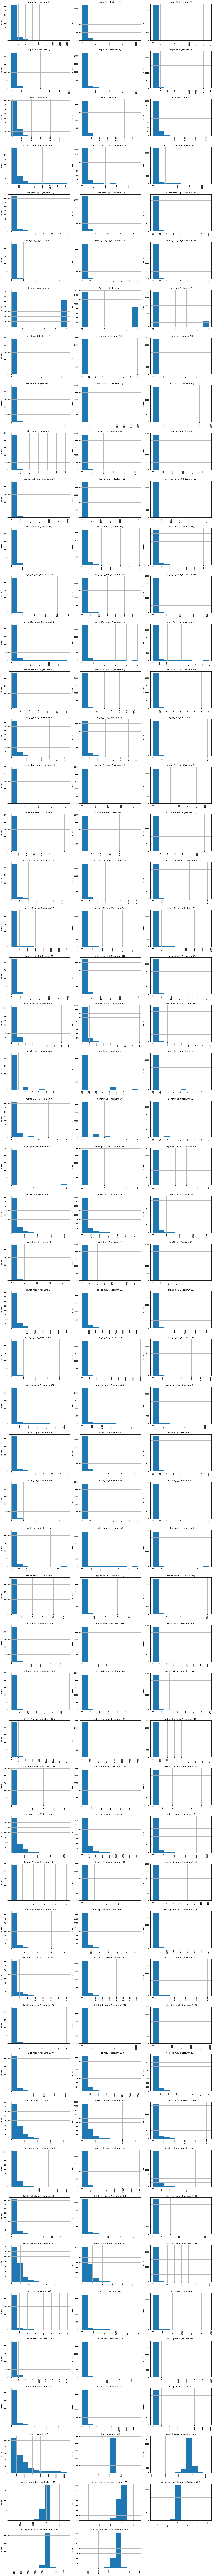

In [85]:
plotGraphForEachFeature(churned_df, nCol, 3)

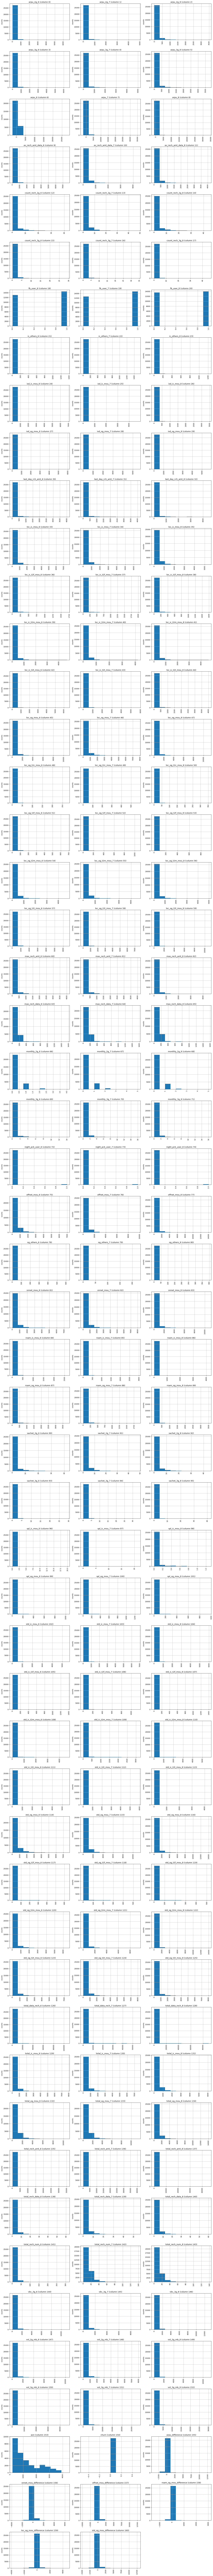

In [86]:
plotGraphForEachFeature(non_churned_df, nCol, 3)

In [87]:
mem_usage()

754.65234375

### Scatter and density plots

Analyse 8th month data

In [88]:
month_cols = master_df.columns[master_df.columns.str.contains(pat = '8|churn')]
month_df = master_df[sorted(month_cols)].select_dtypes(exclude=['category'])
month_df.head(1)

arpu_2g_8  arpu_3g_8   arpu_8  av_rech_amt_data_8  churn  count_rech_2g_8  \
0     212.17     212.17  213.803               252.0      1              0.0   

   count_rech_3g_8  fb_user_8  ic_others_8  isd_ic_mou_8  isd_og_mou_8  \
0              1.0          1          0.0           0.0           0.0   

   last_day_rch_amt_8  loc_ic_mou_8  loc_ic_t2f_mou_8  loc_ic_t2m_mou_8  \
0                 252          5.44              1.15              4.13   

   loc_ic_t2t_mou_8  loc_og_mou_8  loc_og_t2c_mou_8  loc_og_t2f_mou_8  \
0              0.16           0.0               0.0               0.0   

   loc_og_t2m_mou_8  loc_og_t2t_mou_8  max_rech_amt_8  max_rech_data_8  \
0               0.0               0.0             252            252.0   

   monthly_2g_8  monthly_3g_8  night_pck_user_8  offnet_mou_8  og_others_8  \
0             0             1                 0           0.0          0.0   

   onnet_mou_8  roam_ic_mou_8  roam_og_mou_8  sachet_2g_8  sachet_3g_8  \
0          0.0            0.0            0.0            0            0   

   spl_ic_mou_8  spl_og_mou_8  std_ic_mou_8  std_ic_t2f_mou_8  \
0           0.0           0.0           0.0               0.0   

   std_ic_t2m_mou_8  std_ic_t2t_mou_8  std_og_mou_8  std_og_t2f_mou_8  \
0               0.0               0.0           0.0               0.0   

   std_og_t2m_mou_8  std_og_t2t_mou_8  total_data_rech_8  total_ic_mou_8  \
0               0.0               0.0              252.0            5.44   

   total_og_mou_8  total_rech_amt_8  total_rech_data_8  total_rech_num_8  \
0             0.0               252                1.0                 2   

   vbc_3g_8  vol_2g_mb_8  vol_3g_mb_8  
0      30.4         5.75       109.61

Plotting 17 row(s) of scatter and density plots...


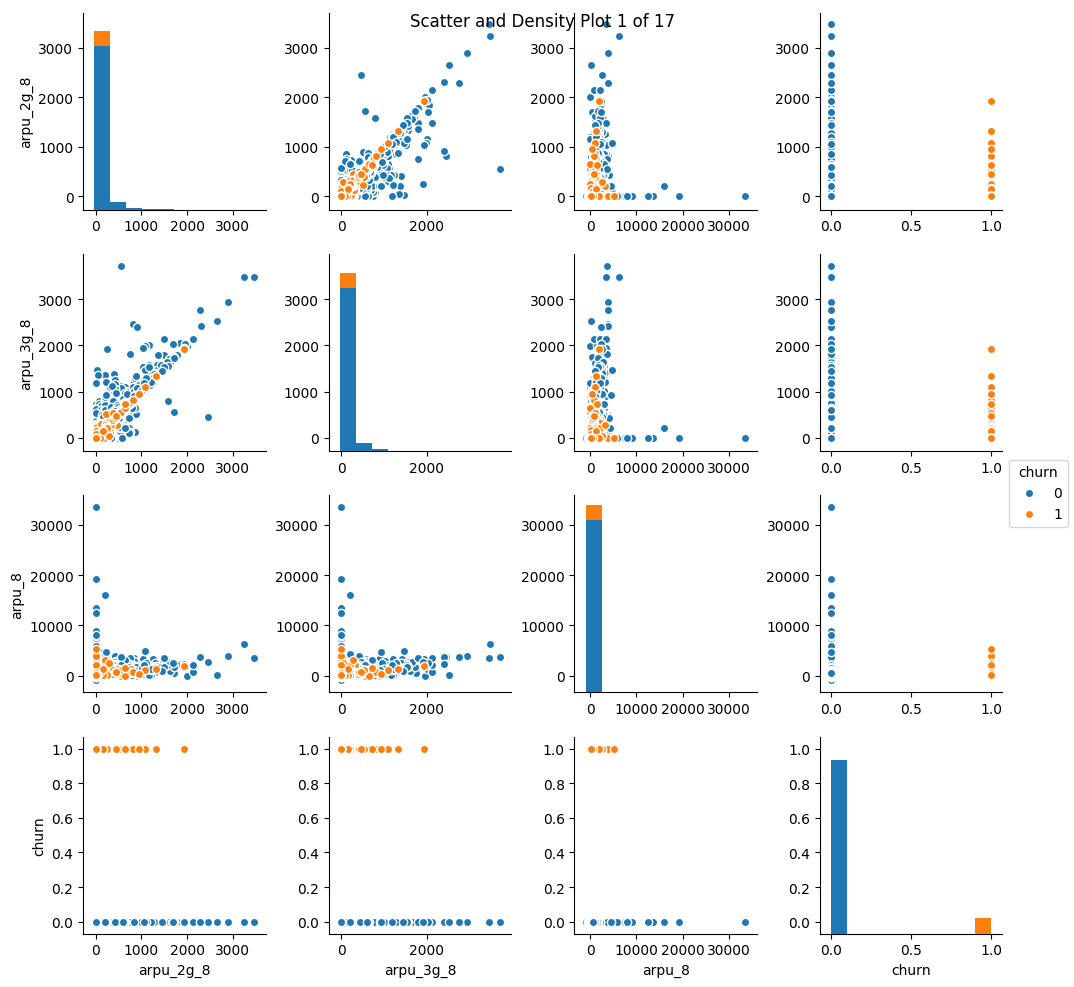

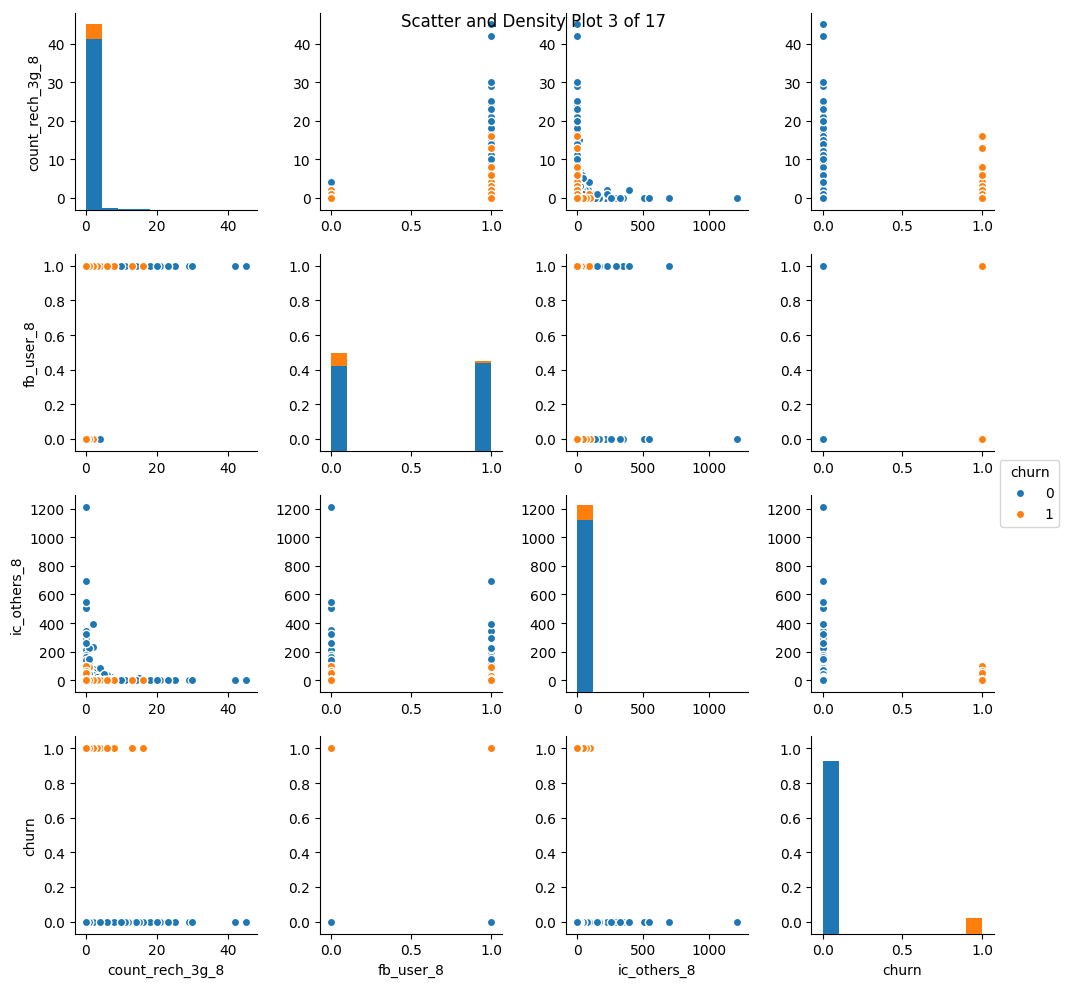

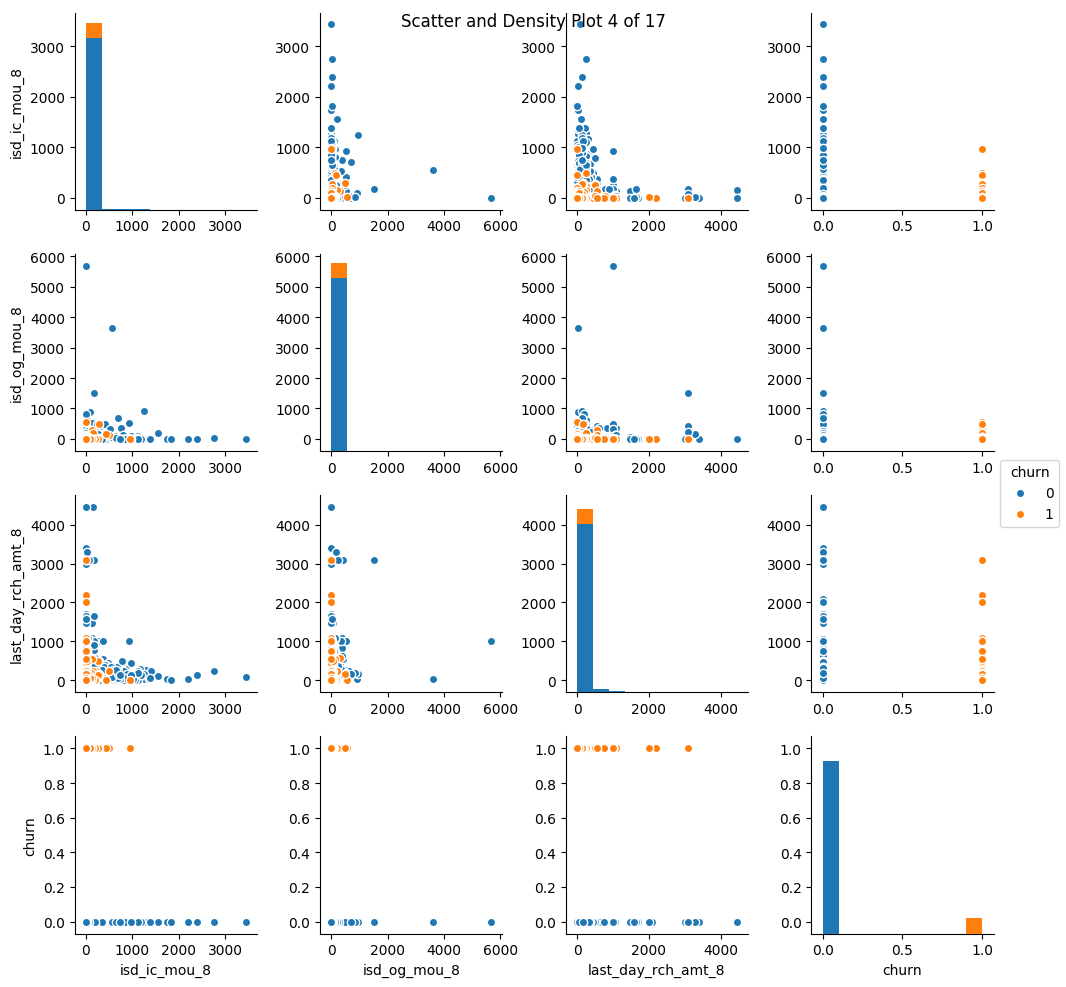

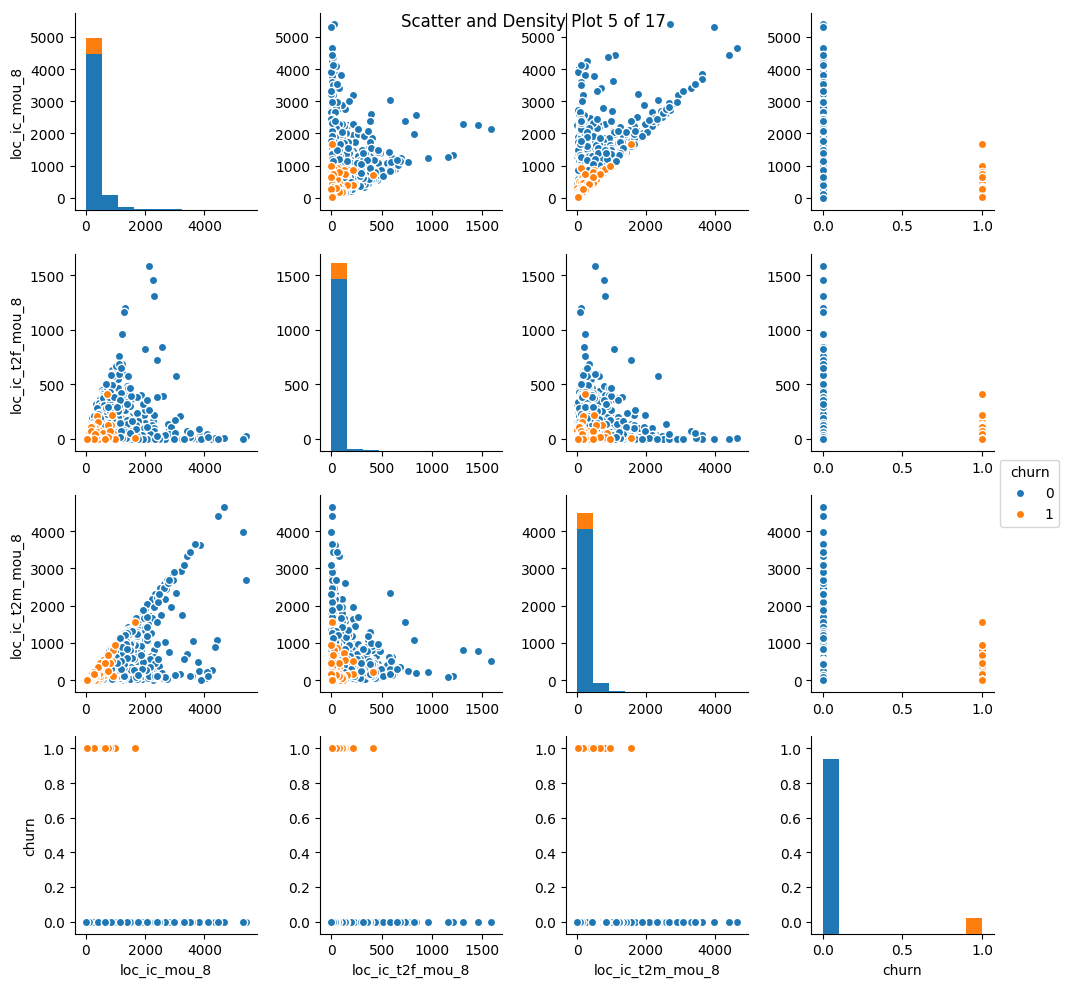

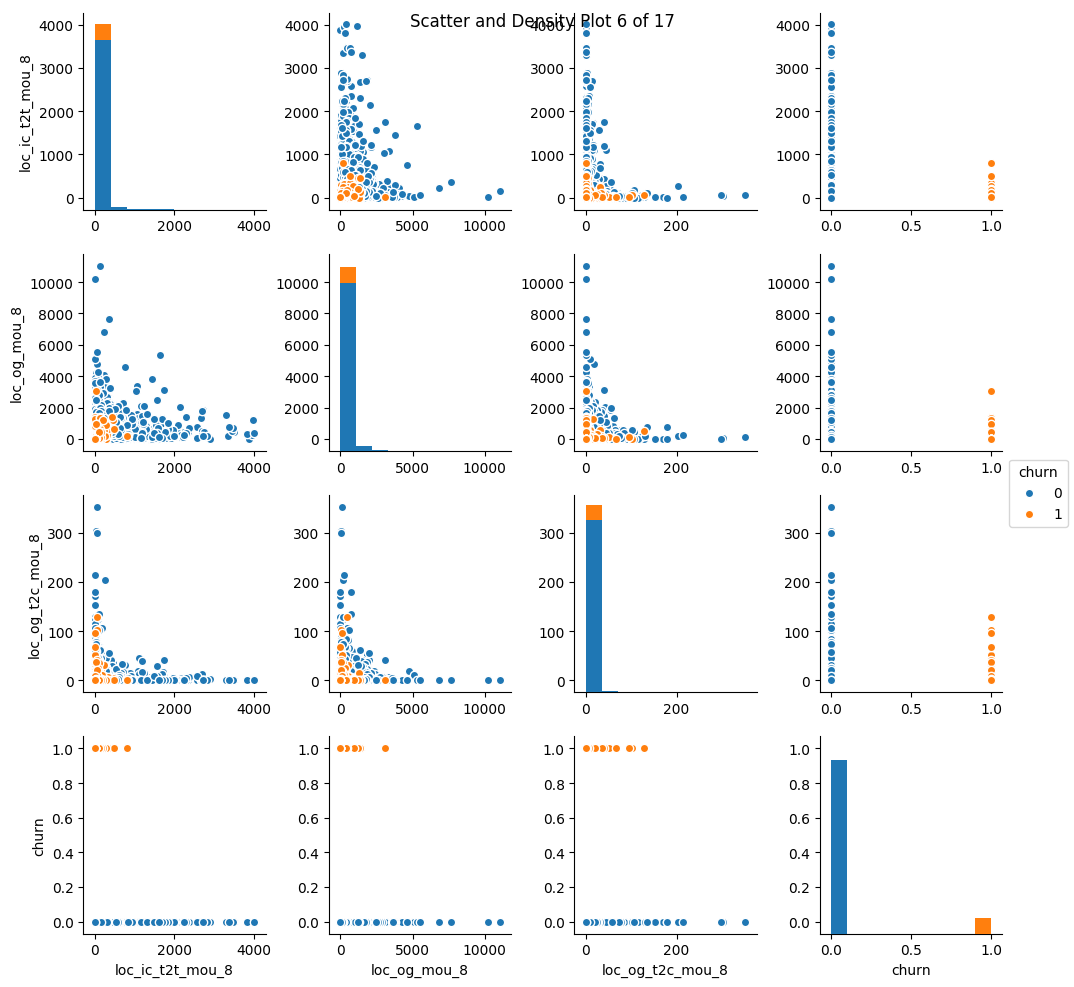

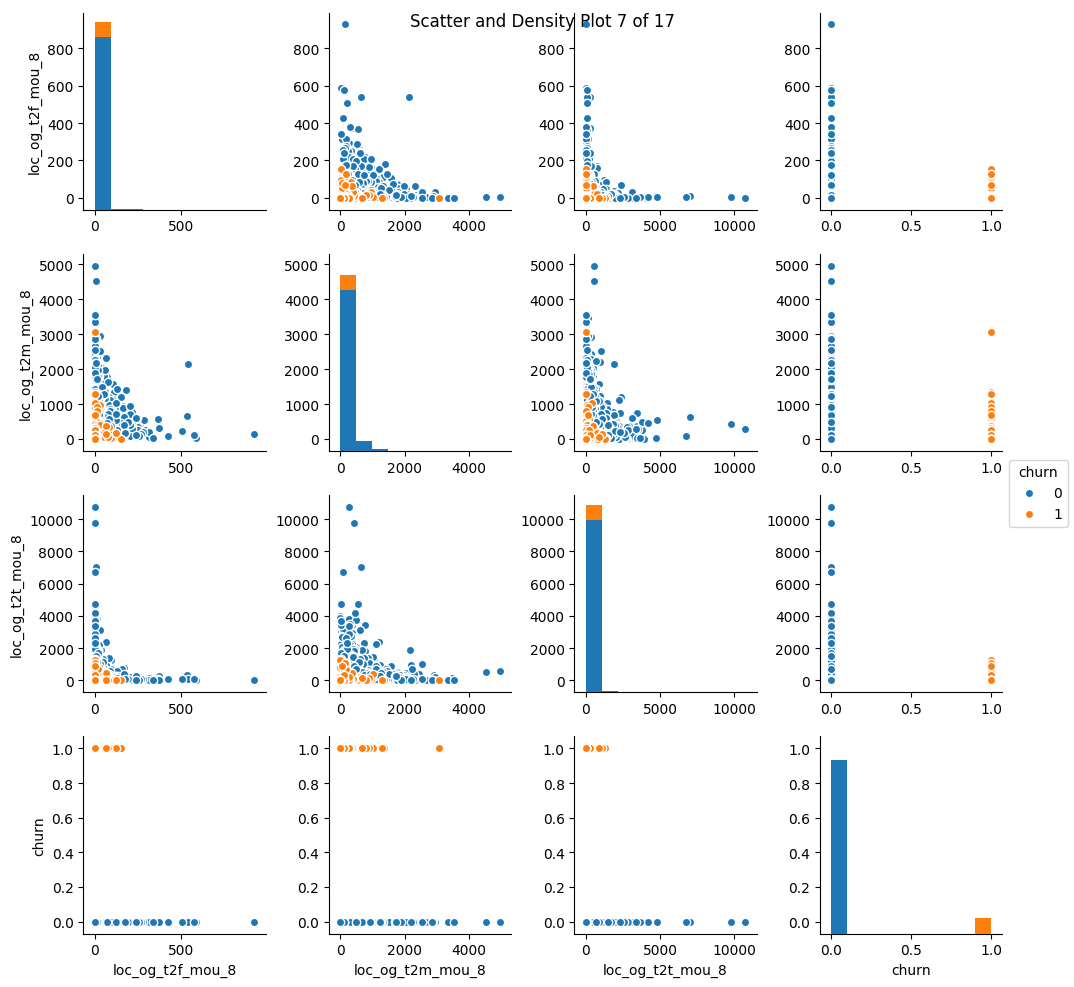

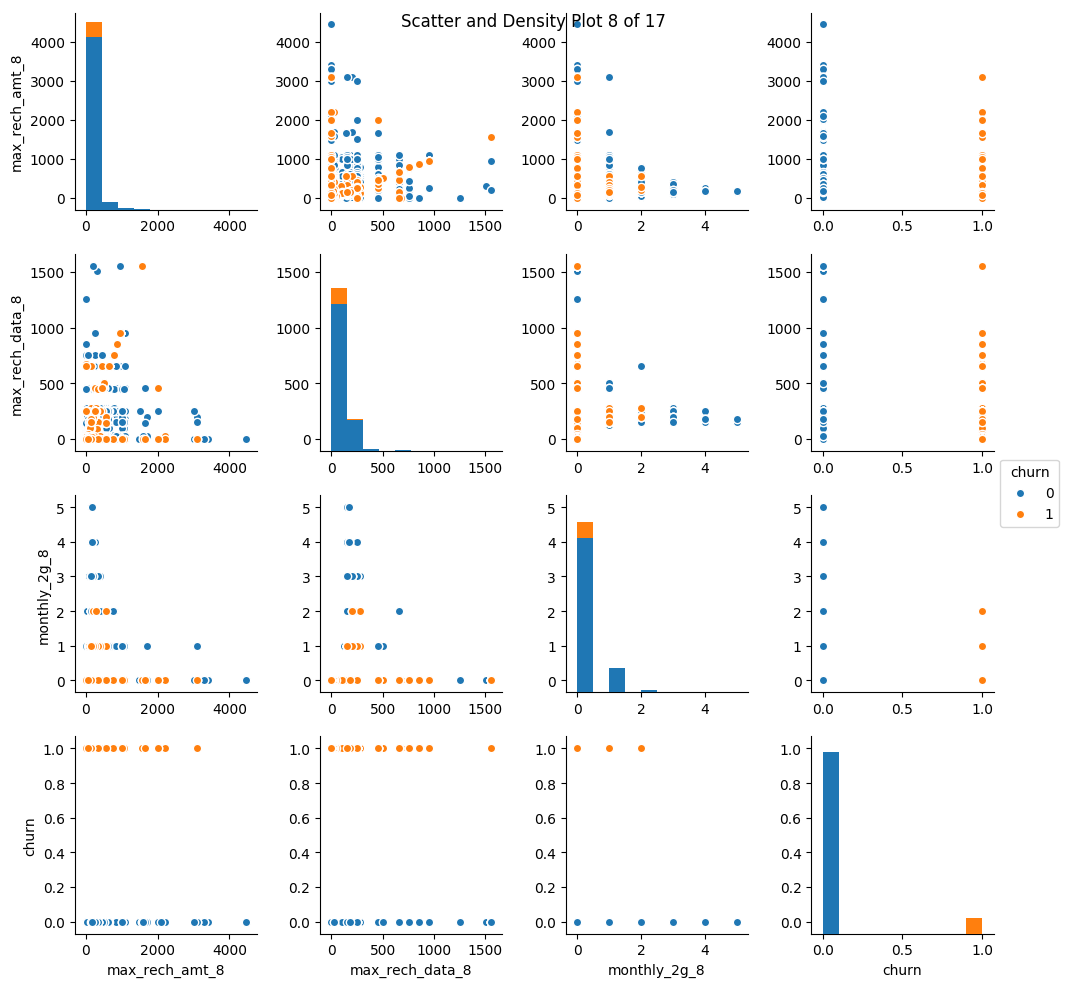

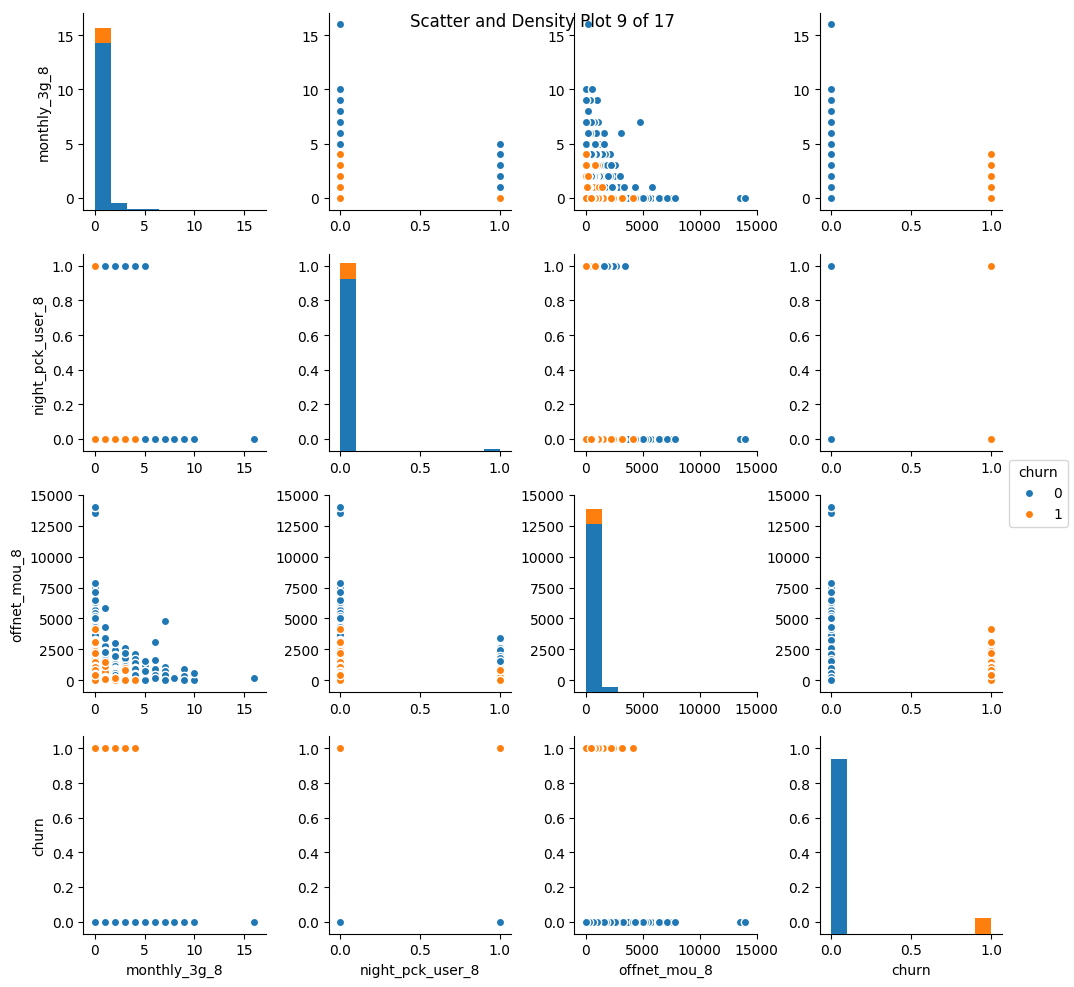

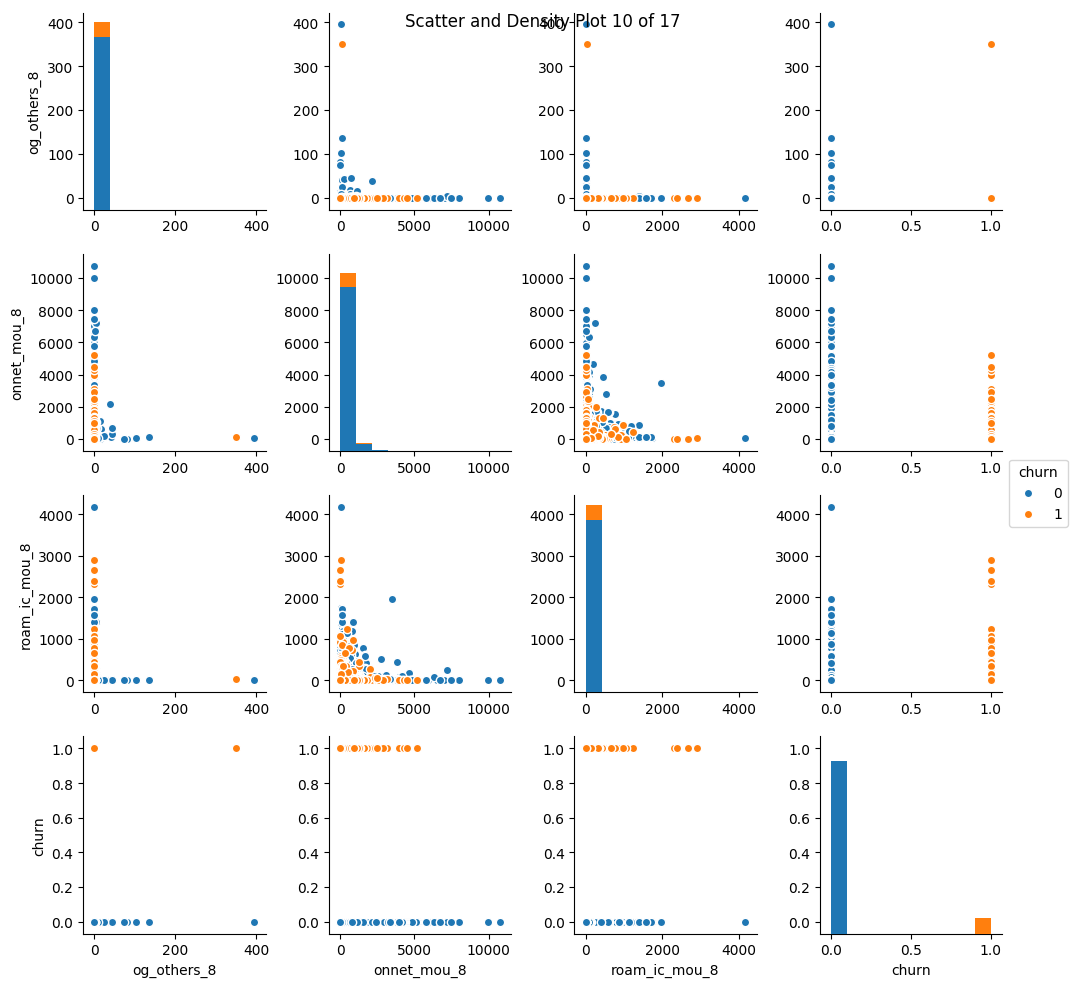

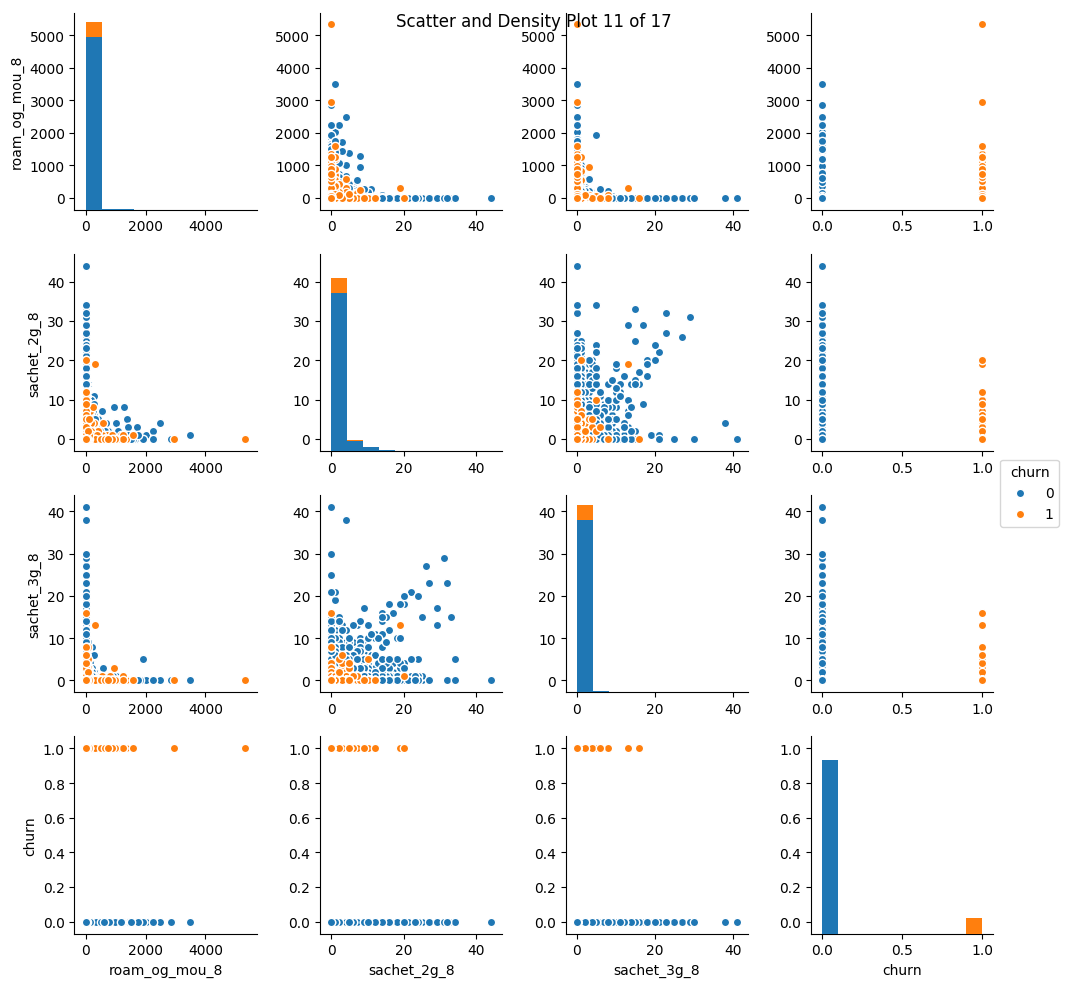

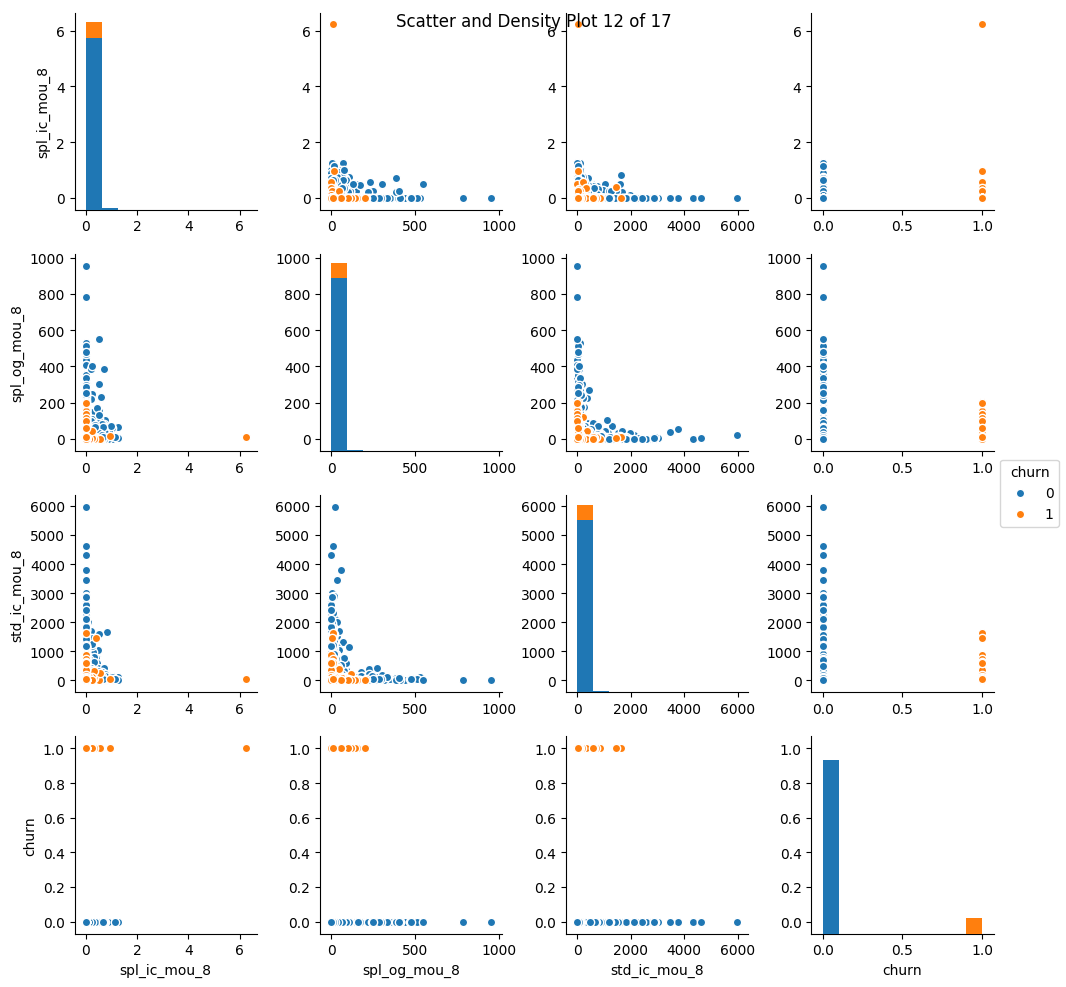

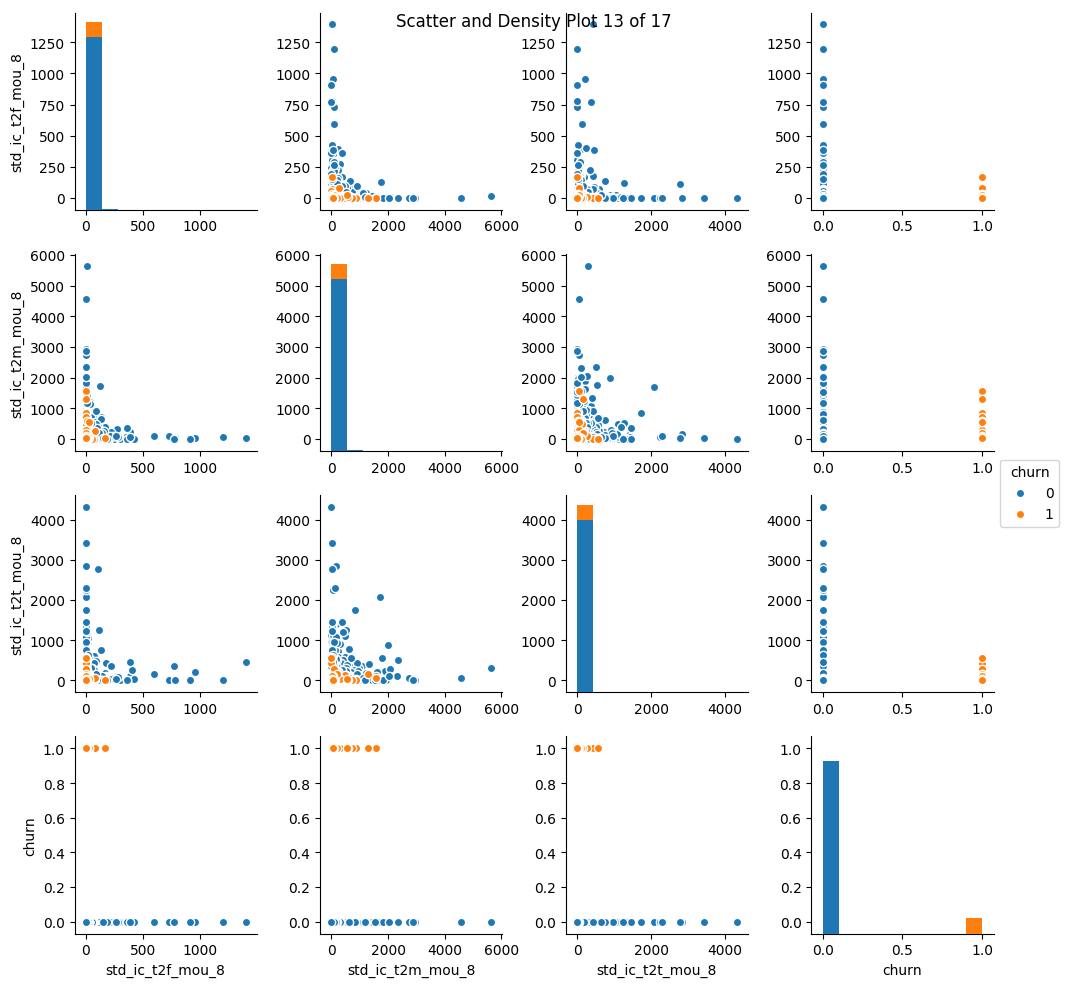

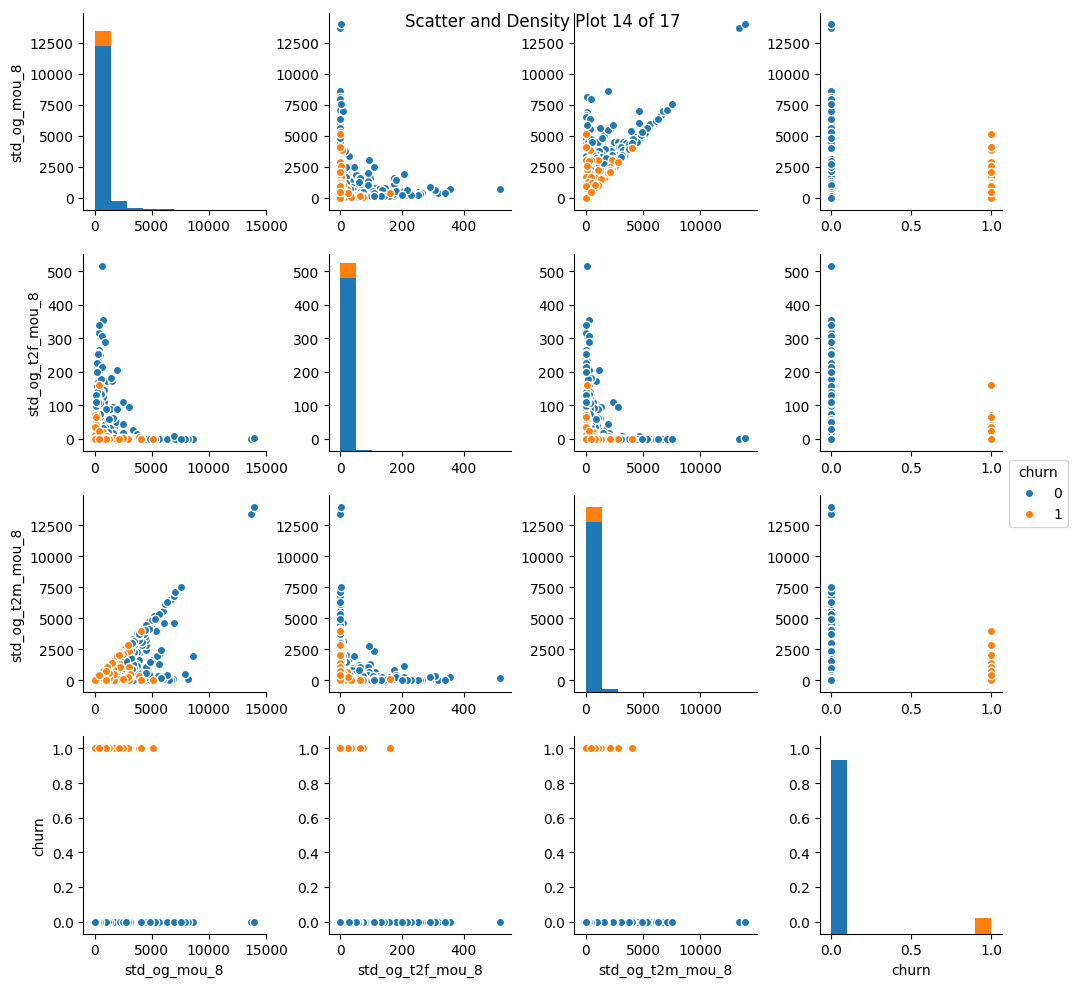

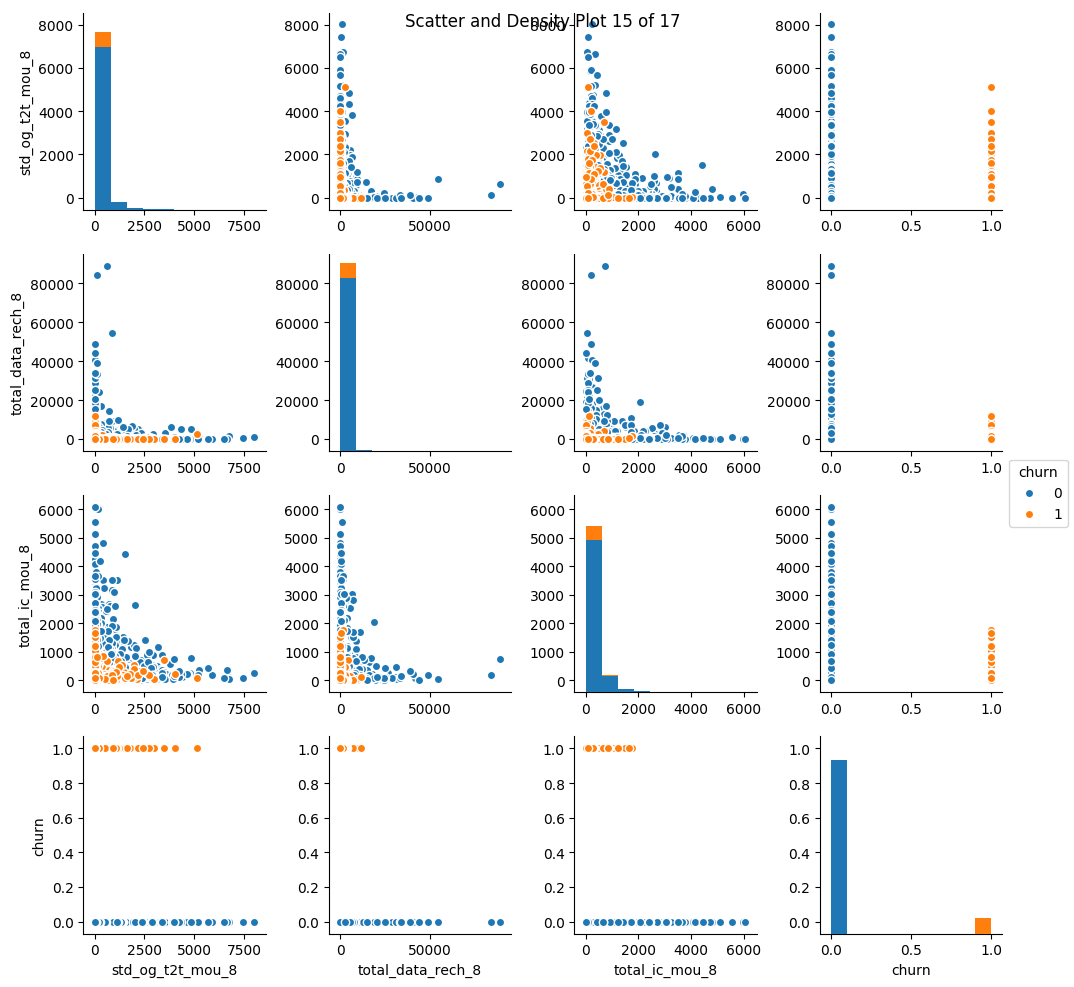

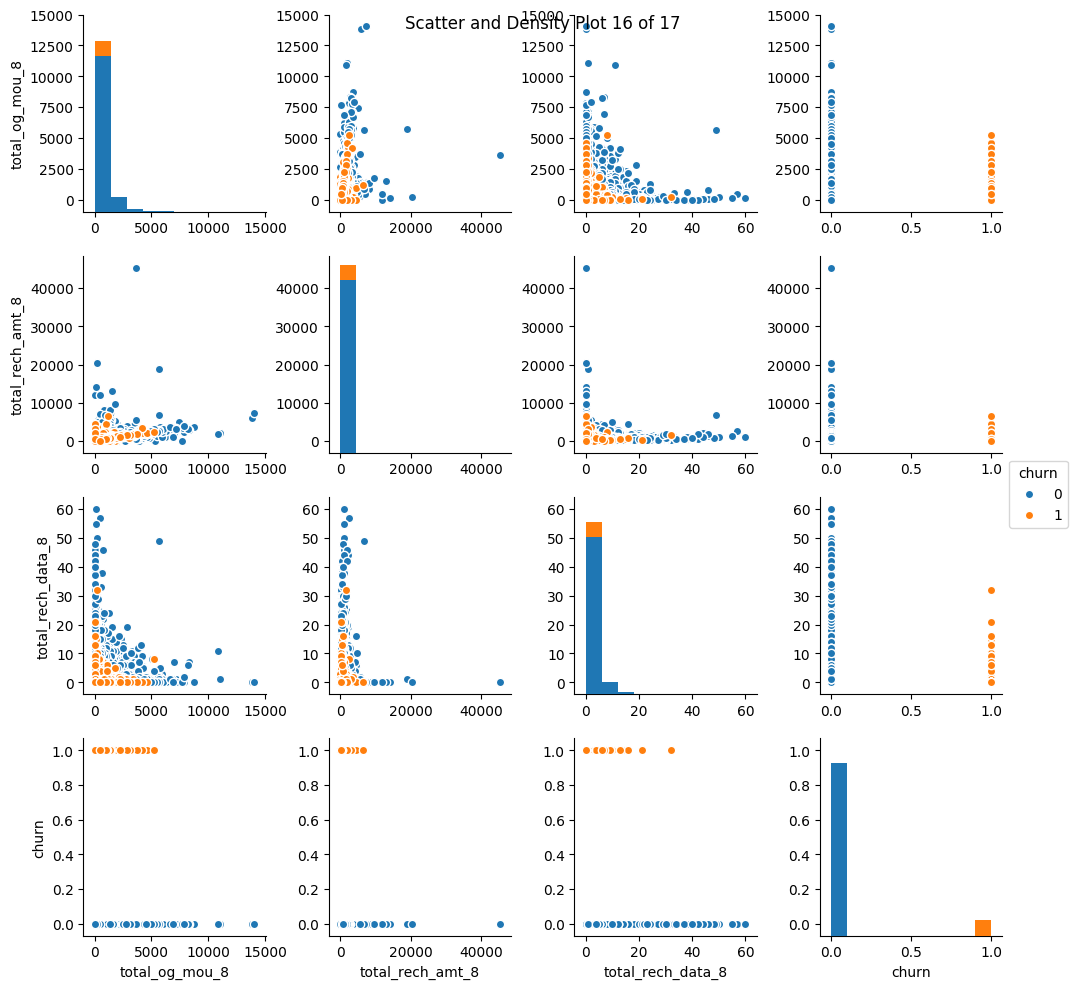

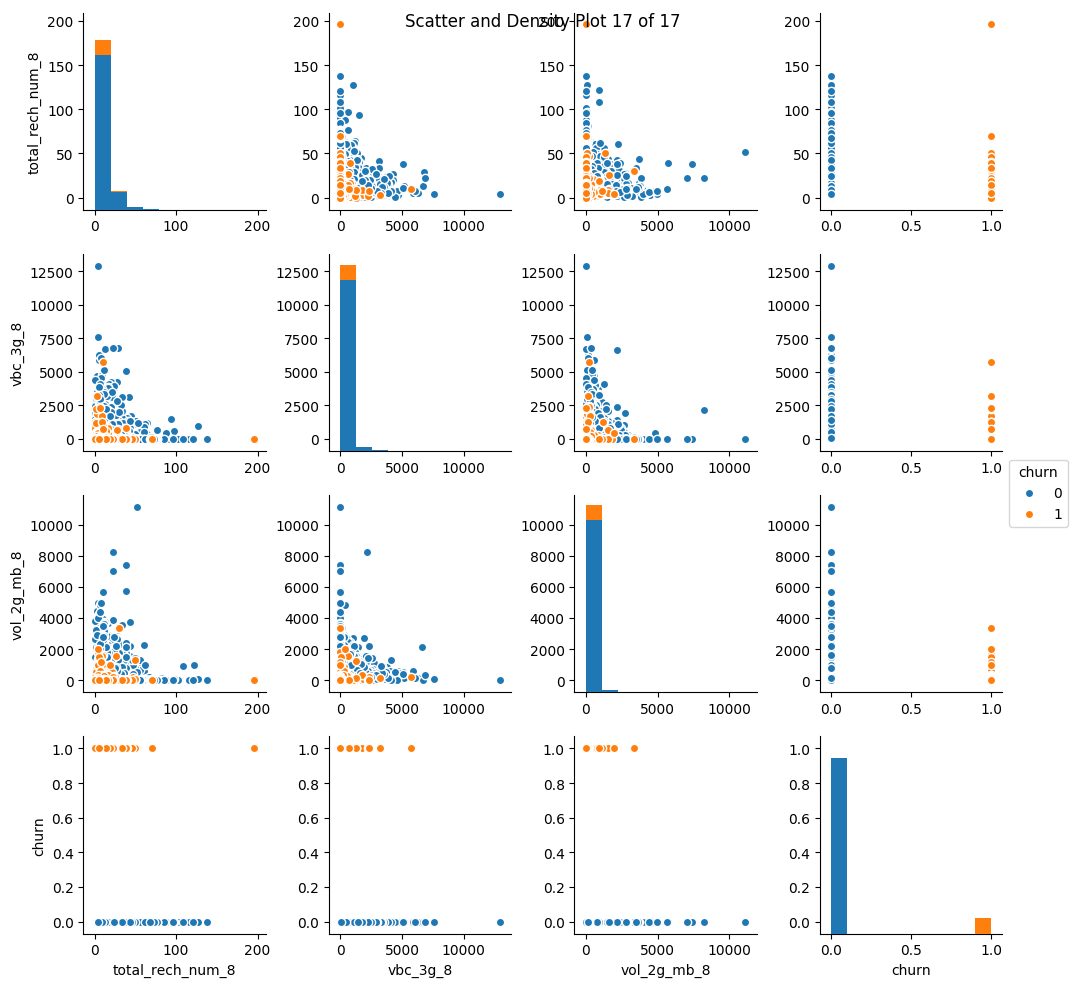

In [89]:
plotScatterForEachFeature(month_df, 'churn', 3, 3)

Analyse non monthly features

In [90]:
non_month_cols = master_df.columns[~master_df.columns.str.contains(pat = '6|7|8|9')]
non_month_df = master_df[sorted(non_month_cols)].select_dtypes(exclude=['category'])
non_month_df.head(1)

aon  arpu_difference  churn  isd_ic_mou_difference  isd_og_mou_difference  \
0  968           7.7025      1                    0.0                    0.0   

   loc_ic_mou_difference  loc_og_mou_difference  offnet_mou_difference  \
0                   5.44                    0.0                    0.0   

   onnet_mou_difference  roam_ic_mou_difference  roam_og_mou_difference  \
0                   0.0                     0.0                     0.0   

   spl_ic_mou_difference  spl_og_mou_difference  std_ic_mou_difference  \
0                    0.0                    0.0                    0.0   

   std_og_mou_difference  total_data_rech_difference  total_ic_mou_difference  \
0                    0.0                         0.0                     5.44   

   total_og_mou_difference  total_rech_amt_difference  vbc_3g_difference  \
0                      0.0                      -55.0              -20.2   

   vol_2g_mb_difference  vol_3g_mb_difference  
0                -9.975                -7.555

Plotting 7 row(s) of scatter and density plots...


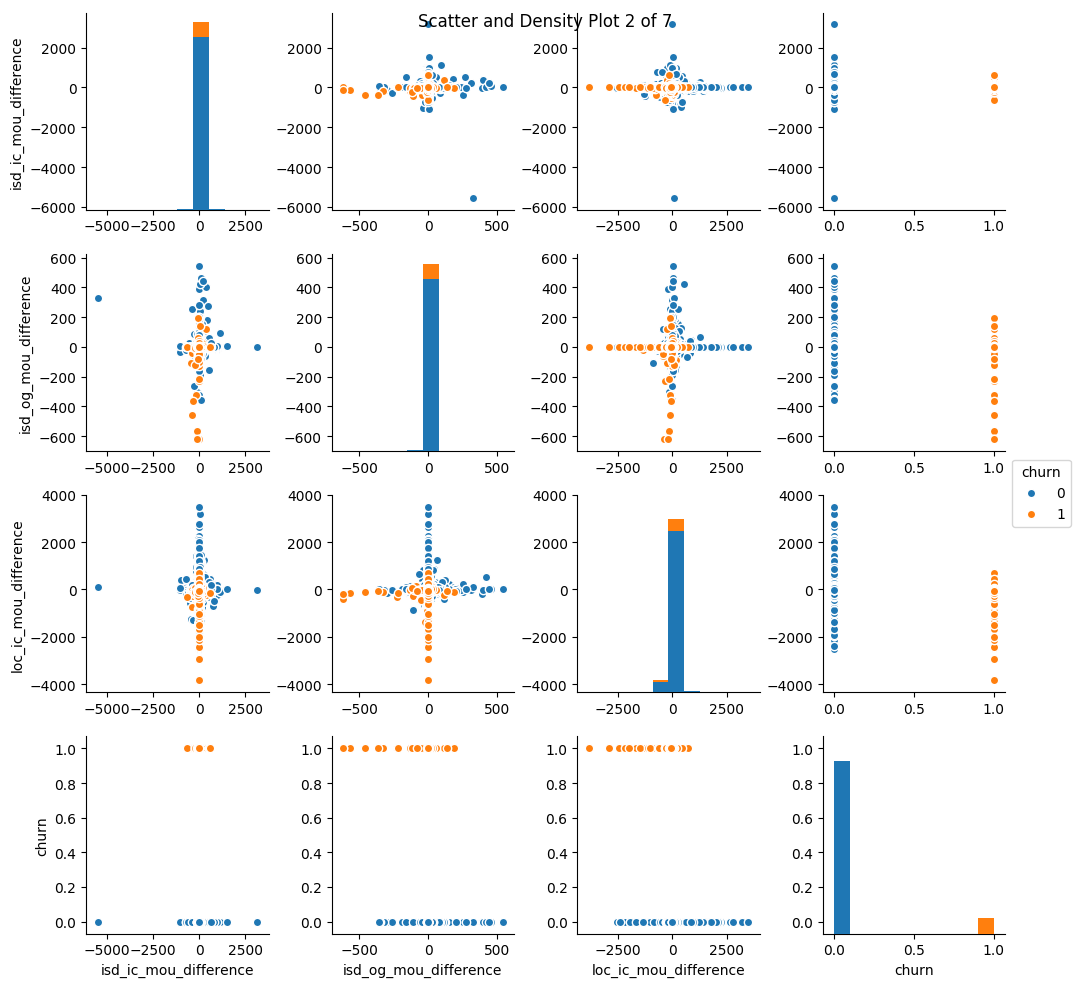

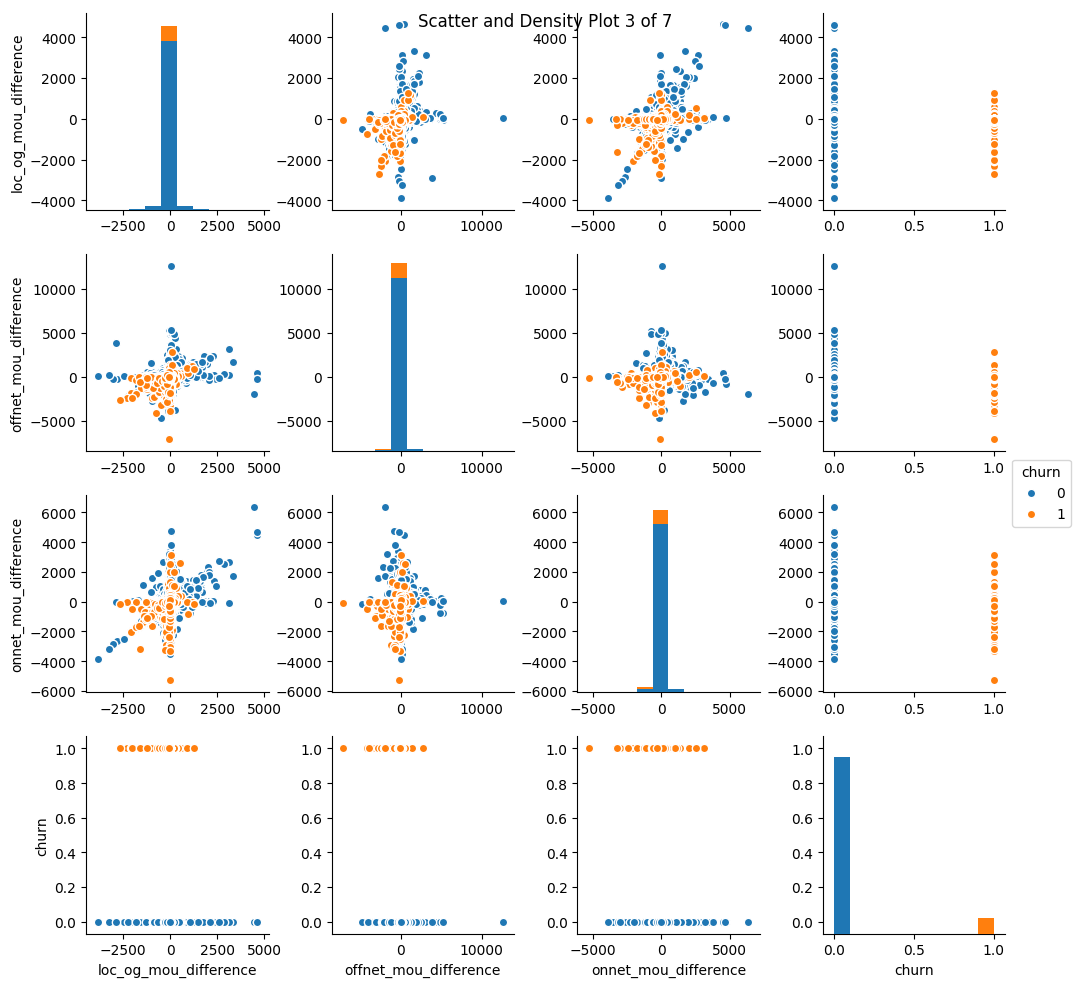

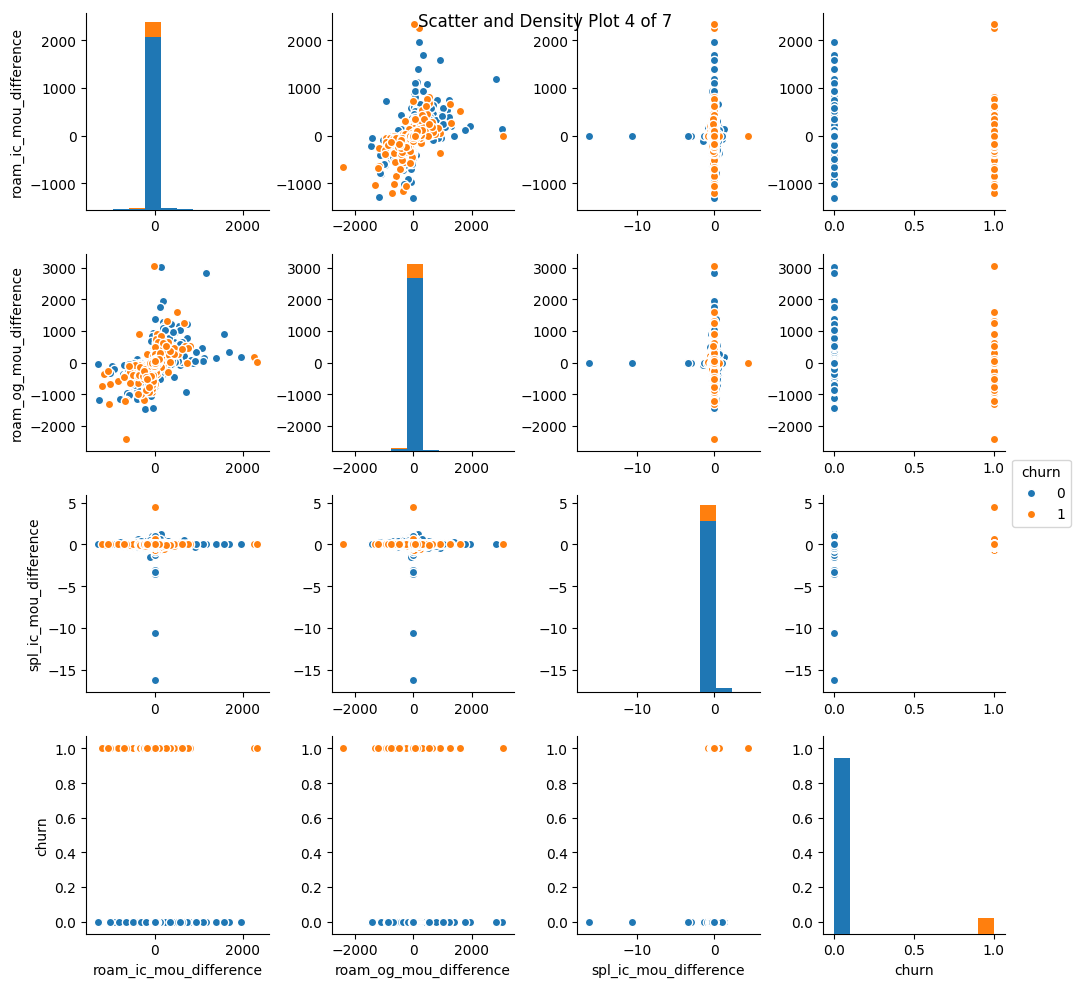

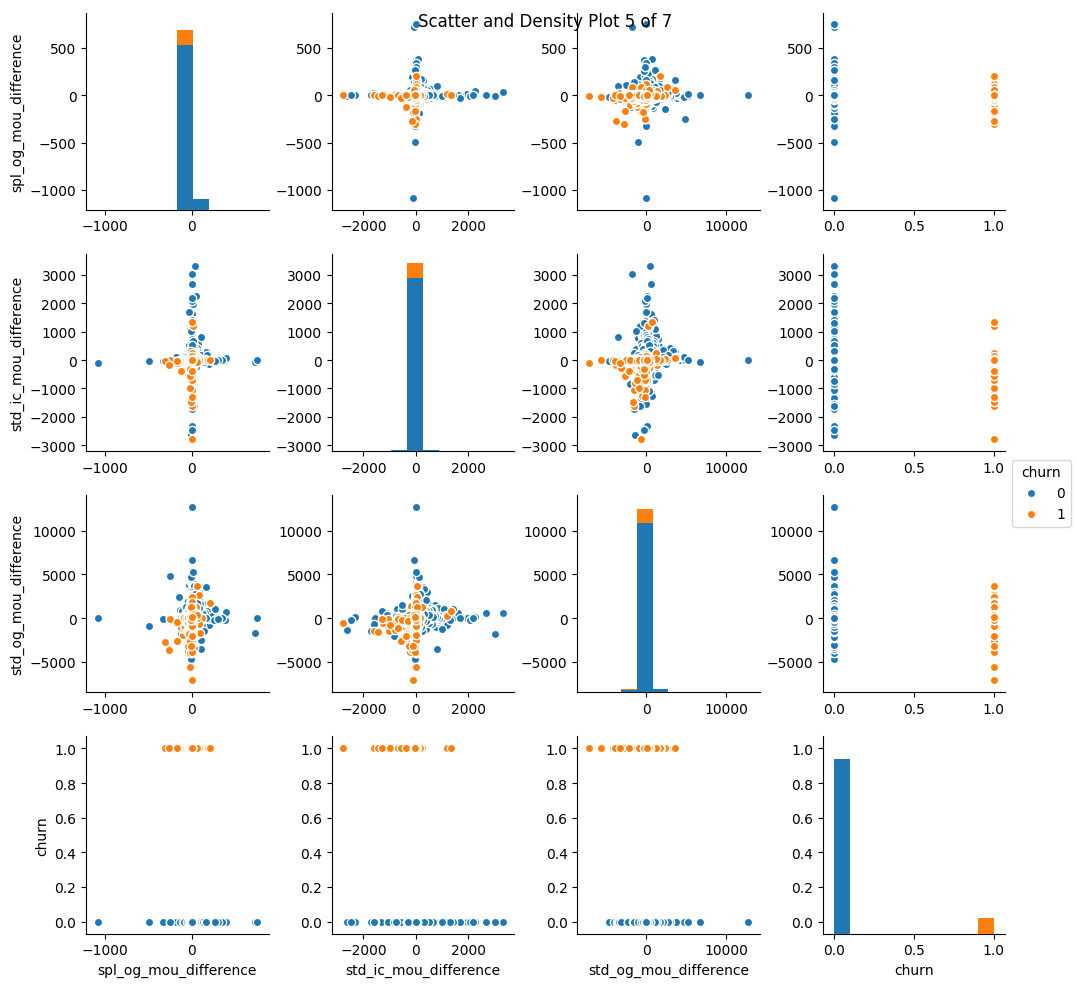

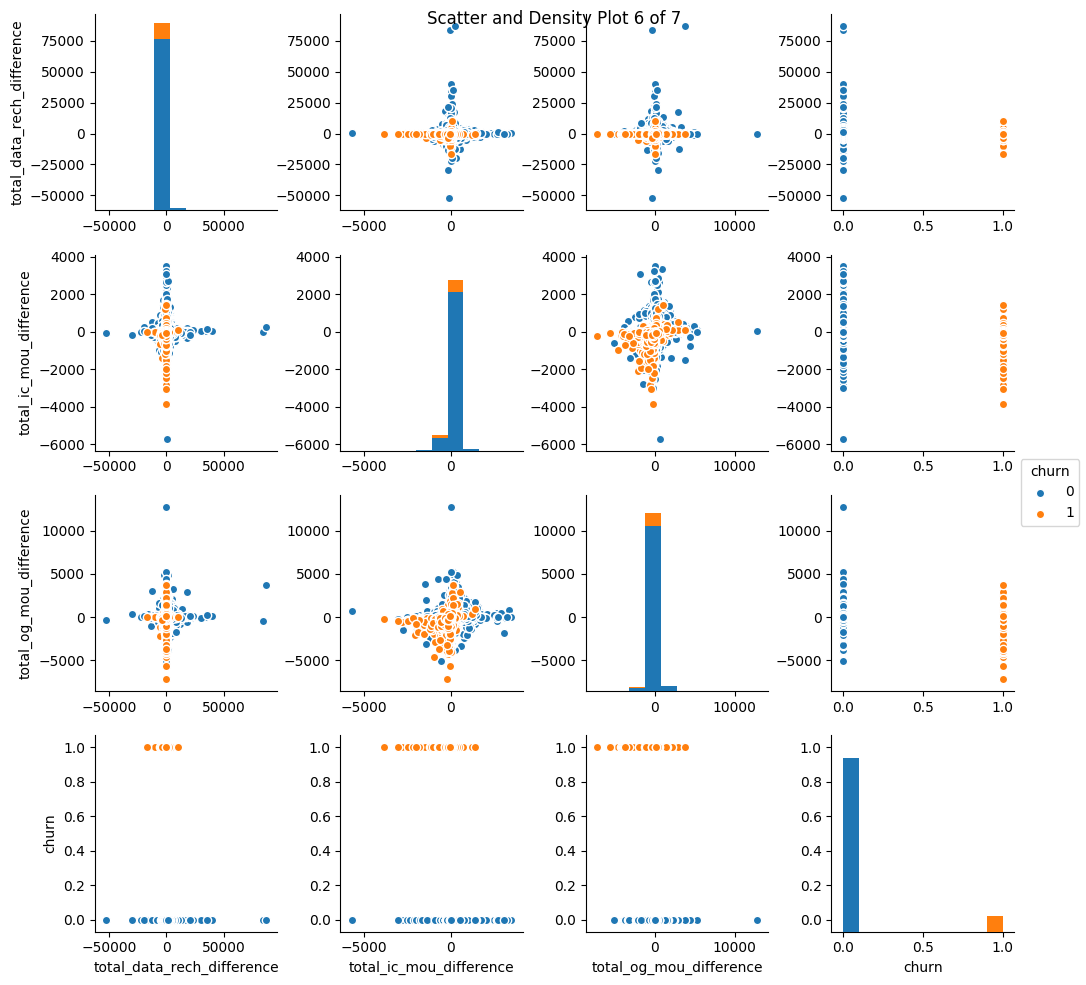

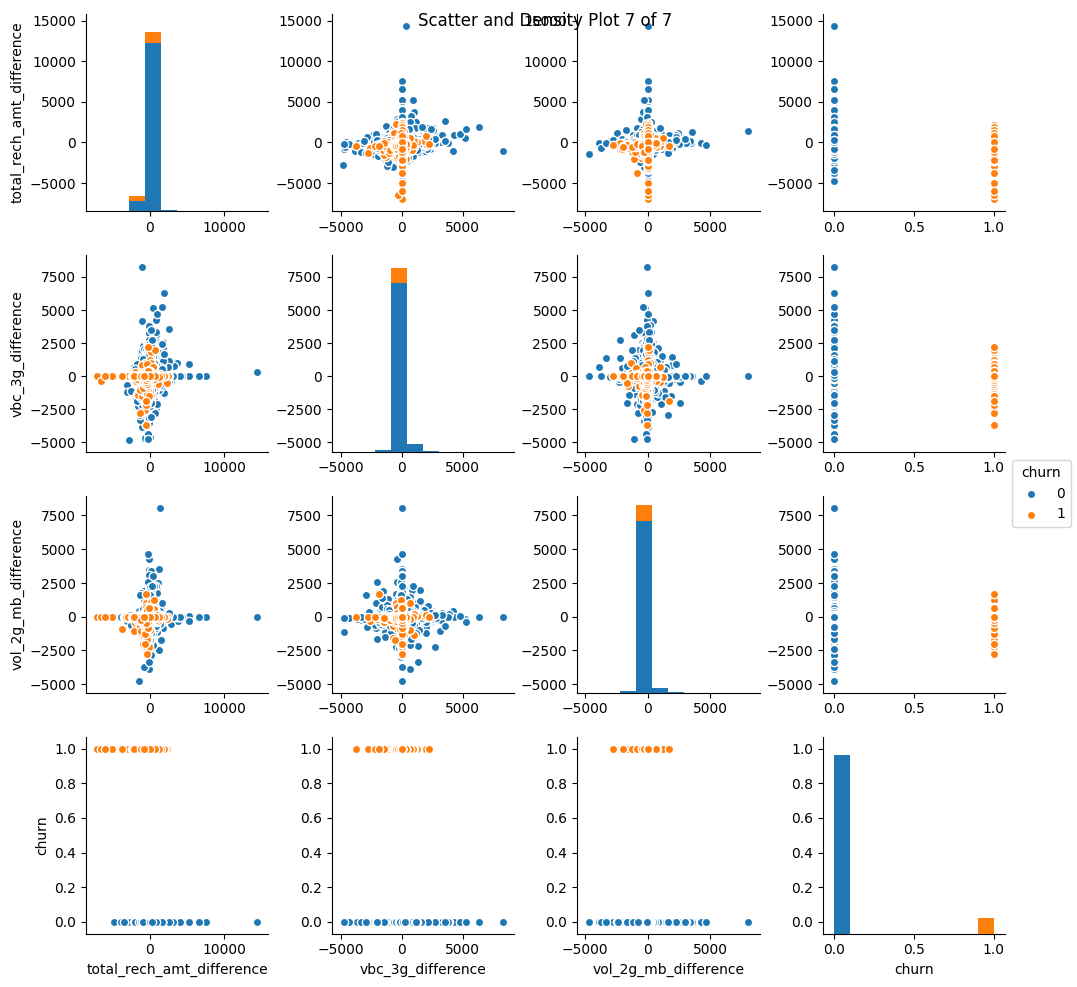

In [91]:
plotScatterForEachFeature(non_month_df, 'churn', 3, 3)

##### From the above bar and scatter plots we can see that most of the features are linearly distributed
- Though it seems not completely linear but good for evaluating linear models

In [92]:
mem_usage()

785.7890625

### AON vs Churn
- AON    =	Age on network - number of days the customer is using the operator T network

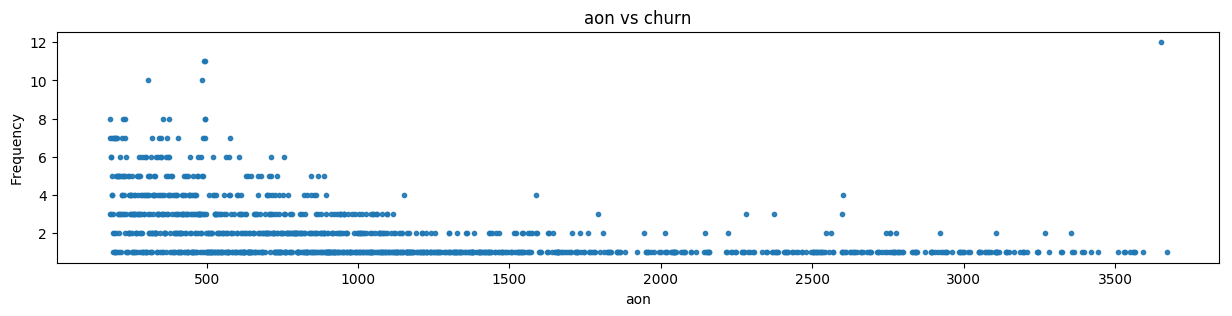

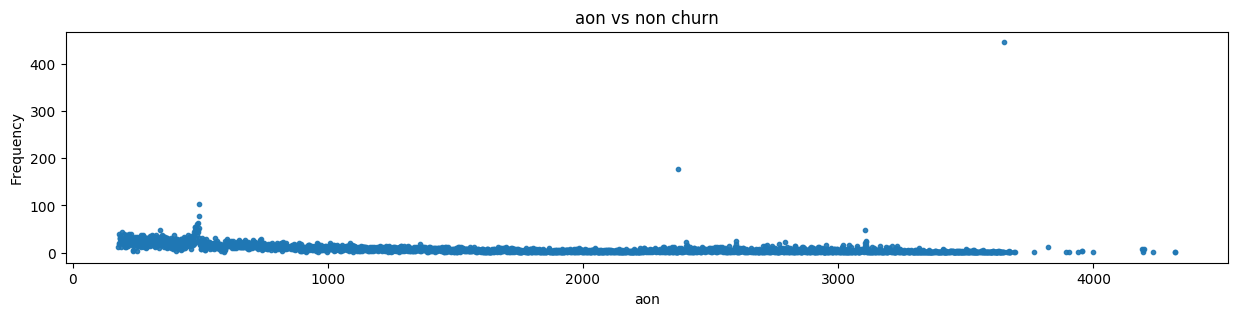

In [93]:
churn_aon_freq = churned_df.groupby(churned_df.aon).size().reset_index(name='Frequency')
non_churn_aon_freq = non_churned_df.groupby(non_churned_df.aon).size().reset_index(name='Frequency')

draw_scatter_plot(churn_aon_freq, "aon", "Frequency", "aon", "Frequency", 15, 3, 0,  'aon vs churn', None, 0.9)
draw_scatter_plot(non_churn_aon_freq, "aon", "Frequency", "aon", "Frequency", 15, 3, 0, 'aon vs non churn', None, 0.9)

#### From the above plot we can see that for churned customers the aon is significantly less then the non-churned customer

### Churned Customers - Max Recharge data anlysis for month 6,7 and 8

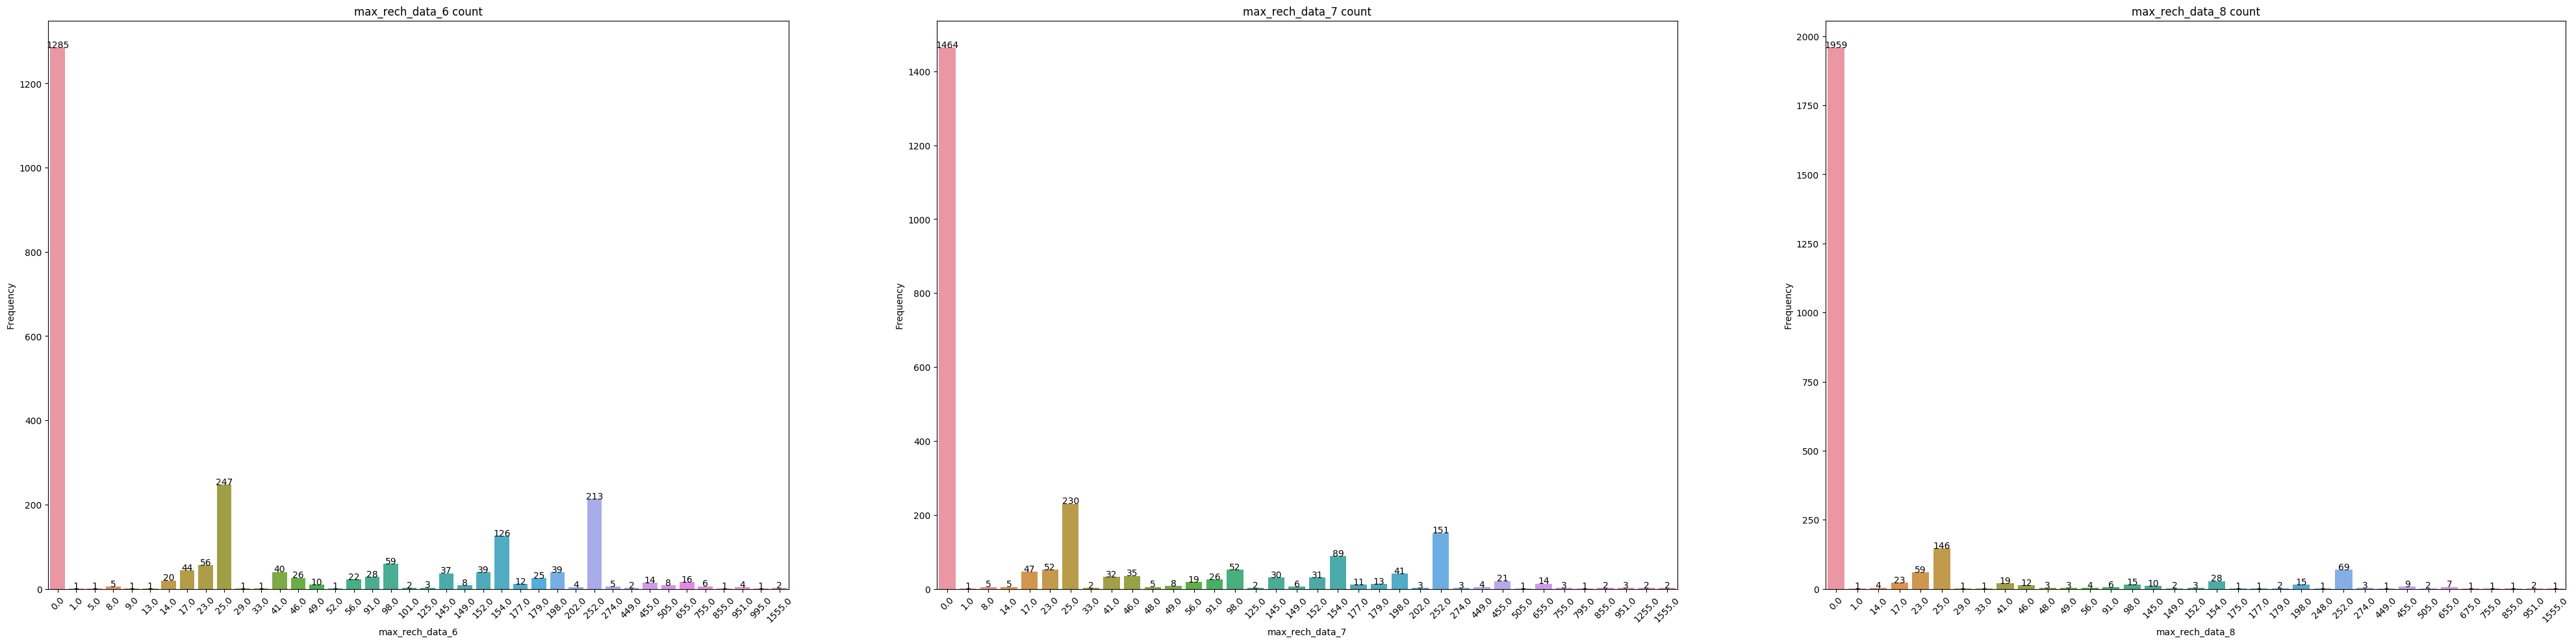

In [94]:
churn_max_rech_data_6_freq = churned_df.groupby(churned_df.max_rech_data_6).size().reset_index(name='Frequency')
churn_max_rech_data_7_freq = churned_df.groupby(churned_df.max_rech_data_7).size().reset_index(name='Frequency')
churn_max_rech_data_8_freq = churned_df.groupby(churned_df.max_rech_data_8).size().reset_index(name='Frequency')

# Plotting the distribution plot to visualise their distribution
columnName = "max_rech_data_6"
draw_bar_chart_subplot(churn_max_rech_data_6_freq, columnName, 'Frequency', columnName + ' count', 
                       columnName, 'Frequency', 50, 25, 45, None, '', True, False, 2, 3, 1)

columnName = "max_rech_data_7"
draw_bar_chart_subplot(churn_max_rech_data_7_freq, columnName, 'Frequency',  columnName + ' count', 
                       columnName, '', 50, 25, 45, None, '', True, False, 2, 3, 2)

columnName = "max_rech_data_8"
draw_bar_chart_subplot(churn_max_rech_data_8_freq, columnName, 'Frequency', columnName + ' count', 
                       columnName, '', 50, 25, 45, None, '', True, True, 2, 3, 3)

### Non Churned Customers - Max Recharge data anlysis for month 6,7 and 8


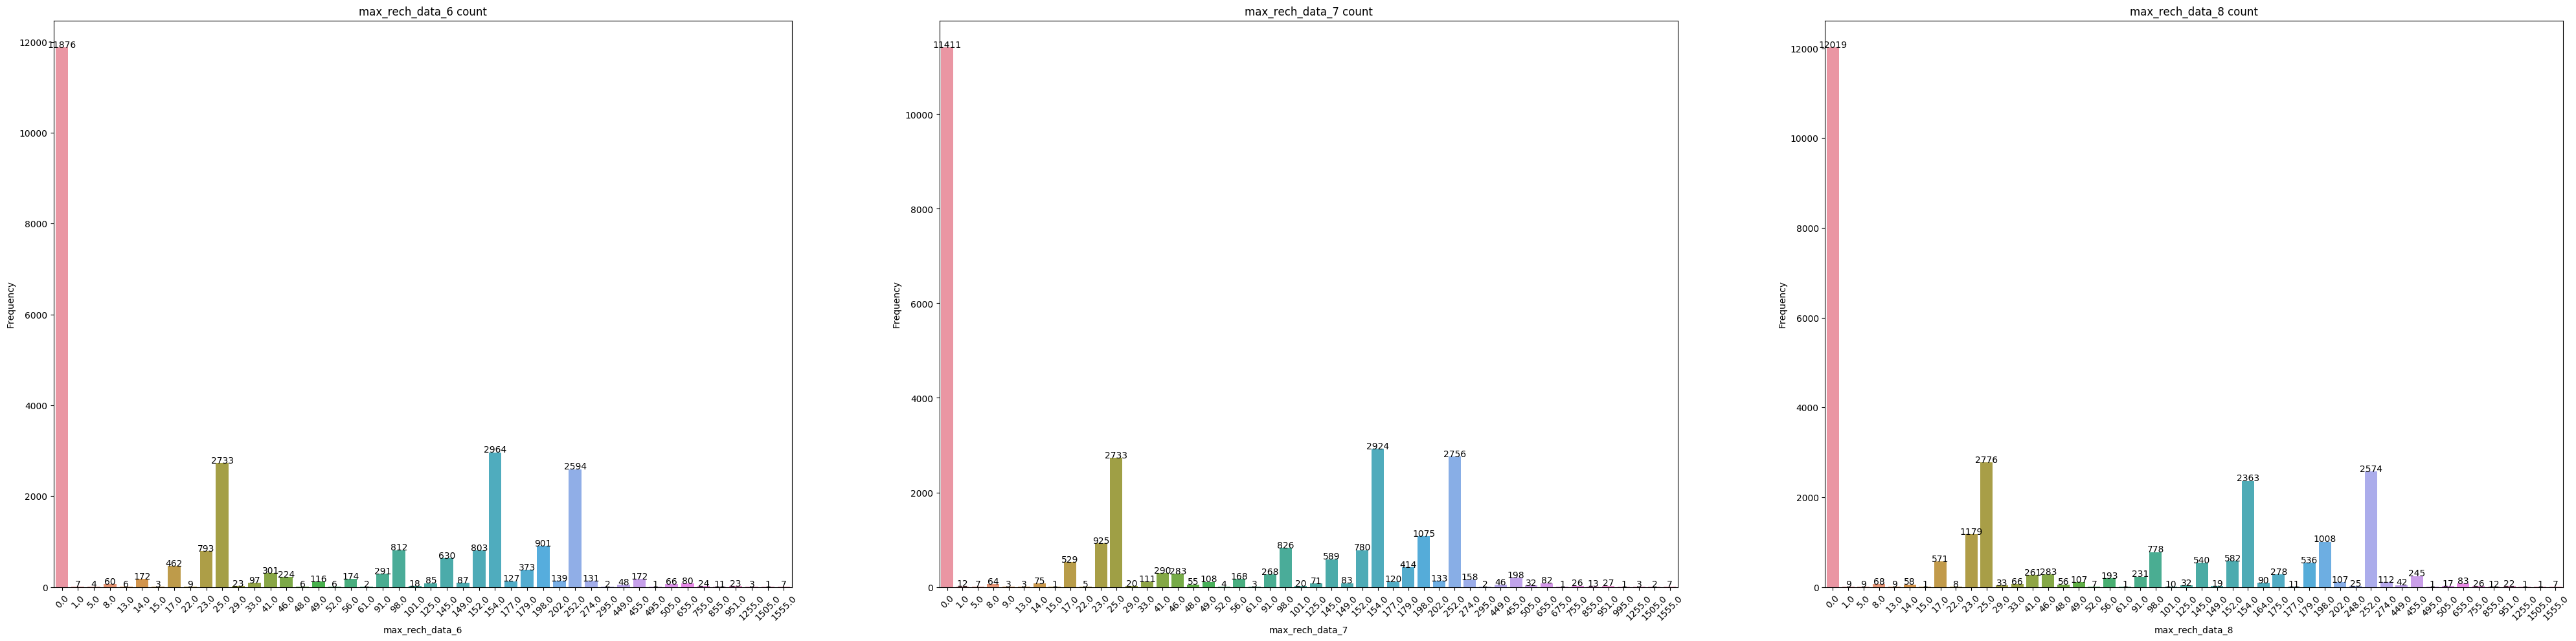

In [95]:
non_churn_max_rech_data_6_freq = non_churned_df.groupby(non_churned_df.max_rech_data_6).size().reset_index(name='Frequency')
non_churn_max_rech_data_7_freq = non_churned_df.groupby(non_churned_df.max_rech_data_7).size().reset_index(name='Frequency')
non_churn_max_rech_data_8_freq = non_churned_df.groupby(non_churned_df.max_rech_data_8).size().reset_index(name='Frequency')

# Plotting the distribution plot to visualise their distribution
columnName = "max_rech_data_6"
draw_bar_chart_subplot(non_churn_max_rech_data_6_freq, columnName, 'Frequency', columnName + ' count', 
                       columnName, 'Frequency', 50, 25, 45, None, '', True, False, 2, 3, 1)

columnName = "max_rech_data_7"
draw_bar_chart_subplot(non_churn_max_rech_data_7_freq, columnName, 'Frequency', columnName + ' count', 
                       columnName, '', 50, 25, 45, None, '', True, False, 2, 3, 2)

columnName = "max_rech_data_8"
draw_bar_chart_subplot(non_churn_max_rech_data_8_freq, columnName, 'Frequency', columnName + ' count',
                       columnName, '', 50, 25, 45, None, '', True, True, 2, 3, 3)

From the aobve plots we can see that for churned customers that max_rech_data is reducing over period of months specially for higher values

### Churned Customers - recharge of count 2g and 3g

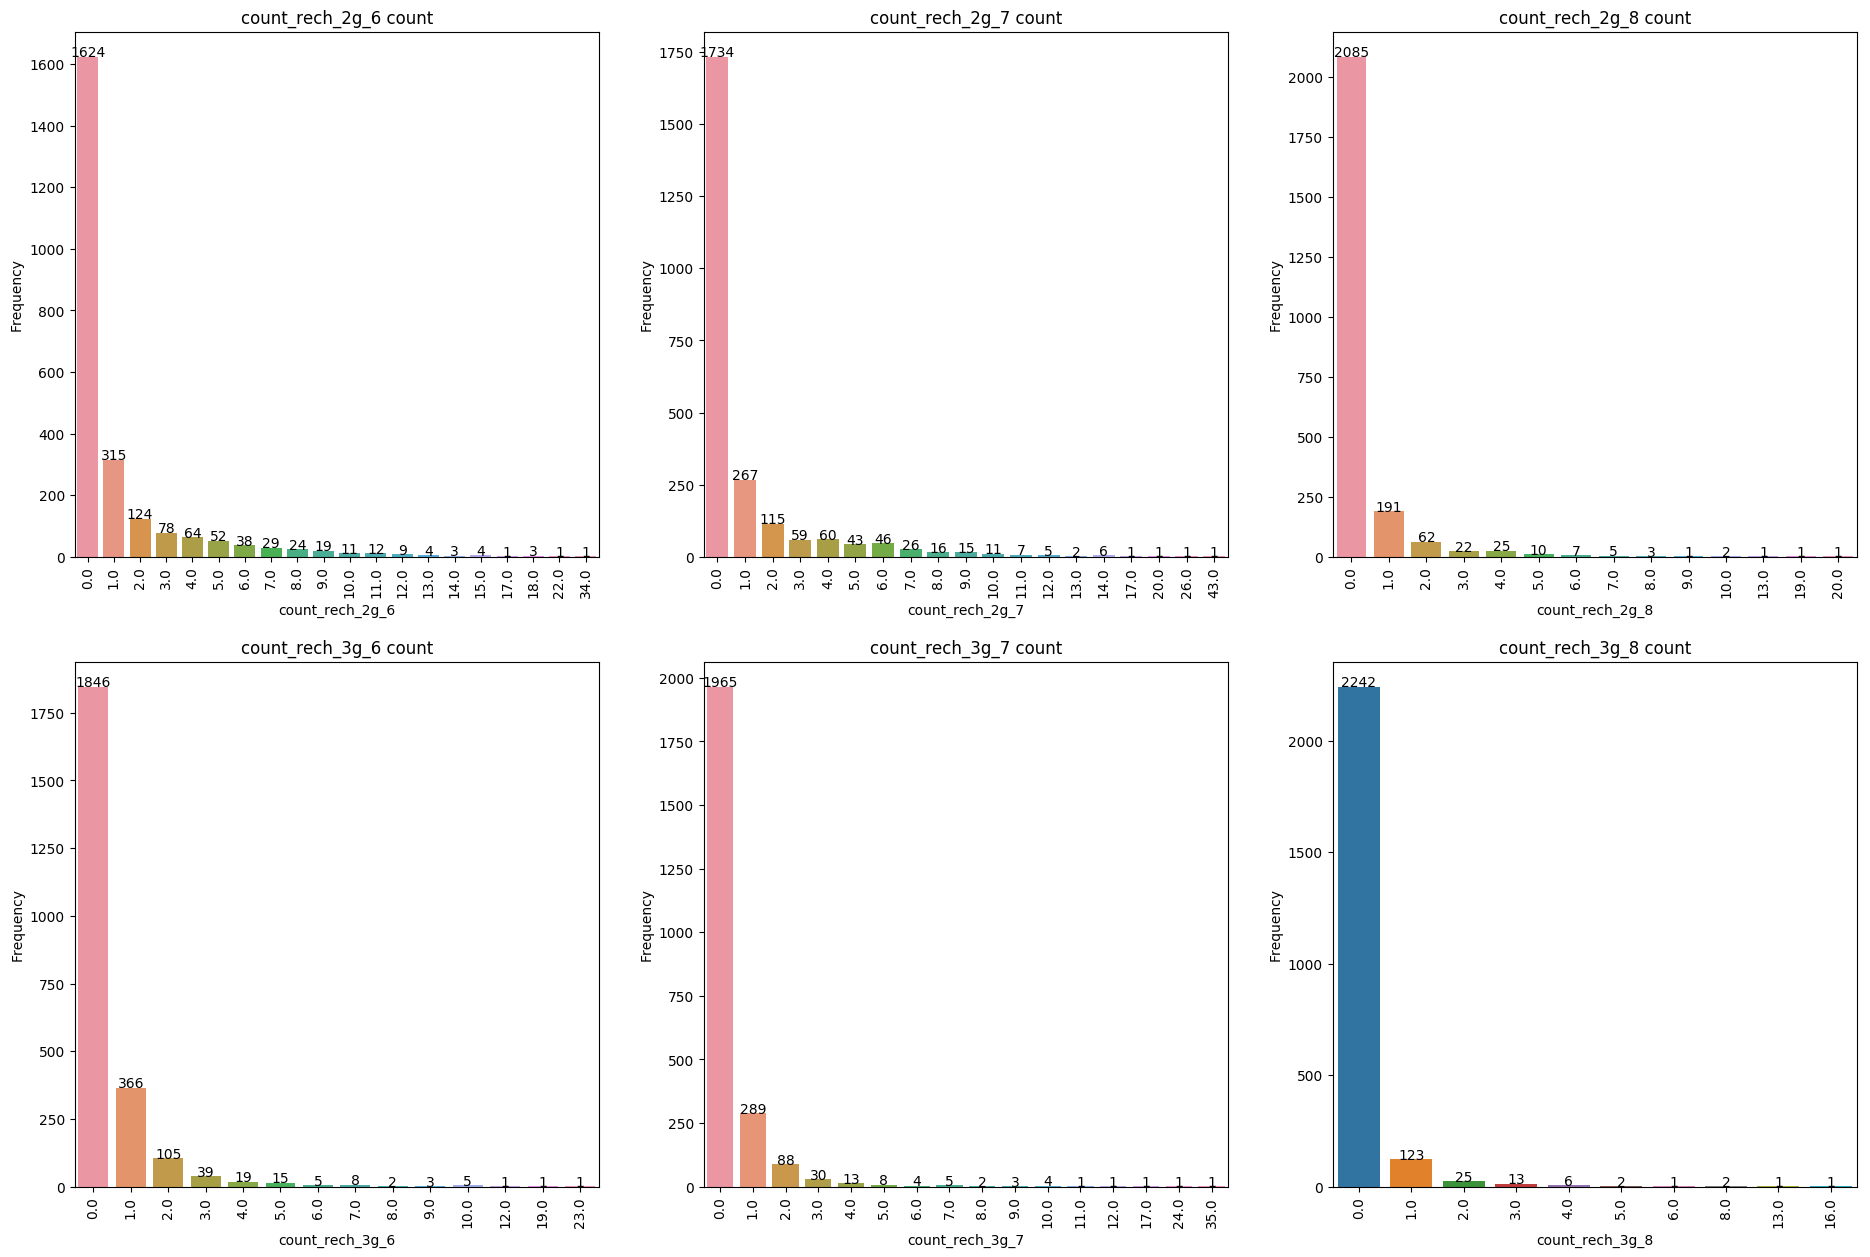

In [96]:
churn_count_rech_2g_6 = churned_df.groupby(churned_df.count_rech_2g_6).size().reset_index(name='Frequency')
churn_count_rech_2g_7 = churned_df.groupby(churned_df.count_rech_2g_7).size().reset_index(name='Frequency')
churn_count_rech_2g_8 = churned_df.groupby(churned_df.count_rech_2g_8).size().reset_index(name='Frequency')
churn_count_rech_3g_6 = churned_df.groupby(churned_df.count_rech_3g_6).size().reset_index(name='Frequency')
churn_count_rech_3g_7 = churned_df.groupby(churned_df.count_rech_3g_7).size().reset_index(name='Frequency')
churn_count_rech_3g_8 = churned_df.groupby(churned_df.count_rech_3g_8).size().reset_index(name='Frequency')

# Plotting the distribution plot to visualise their distribution
columnName = "count_rech_2g_6"
draw_bar_chart_subplot(churn_count_rech_2g_6, columnName, 'Frequency', columnName + ' count', columnName, 'Frequency',
                       23, 15, 90, None, '', True, False, 2, 3, 1)

columnName = "count_rech_2g_7"
draw_bar_chart_subplot(churn_count_rech_2g_7, columnName, 'Frequency', columnName + ' count', columnName, '', 23, 15, 90,
                       None, '', True, False, 2, 3, 2)

columnName = "count_rech_2g_8"
draw_bar_chart_subplot(churn_count_rech_2g_8, columnName, 'Frequency', columnName + ' count', columnName, '', 23, 15, 90,
                       None, '', True, False, 2, 3, 3)

columnName = "count_rech_3g_6"
draw_bar_chart_subplot(churn_count_rech_3g_6, columnName, 'Frequency', columnName + ' count', columnName, 'Frequency', 
                       23, 15, 90, None, '', True, False, 2, 3, 4)

columnName = "count_rech_3g_7"
draw_bar_chart_subplot(churn_count_rech_3g_7, columnName, 'Frequency', columnName + ' count', columnName, '', 23, 15, 90,
                       None, '', True, False, 2, 3, 5)

columnName = "count_rech_3g_8"
draw_bar_chart_subplot(churn_count_rech_3g_8, columnName, 'Frequency', columnName + ' count', columnName, '', 23, 15, 90,
                       None, '', True, True, 2, 3, 6)

### Non Churned Customers - recharge of count 2g and 3g

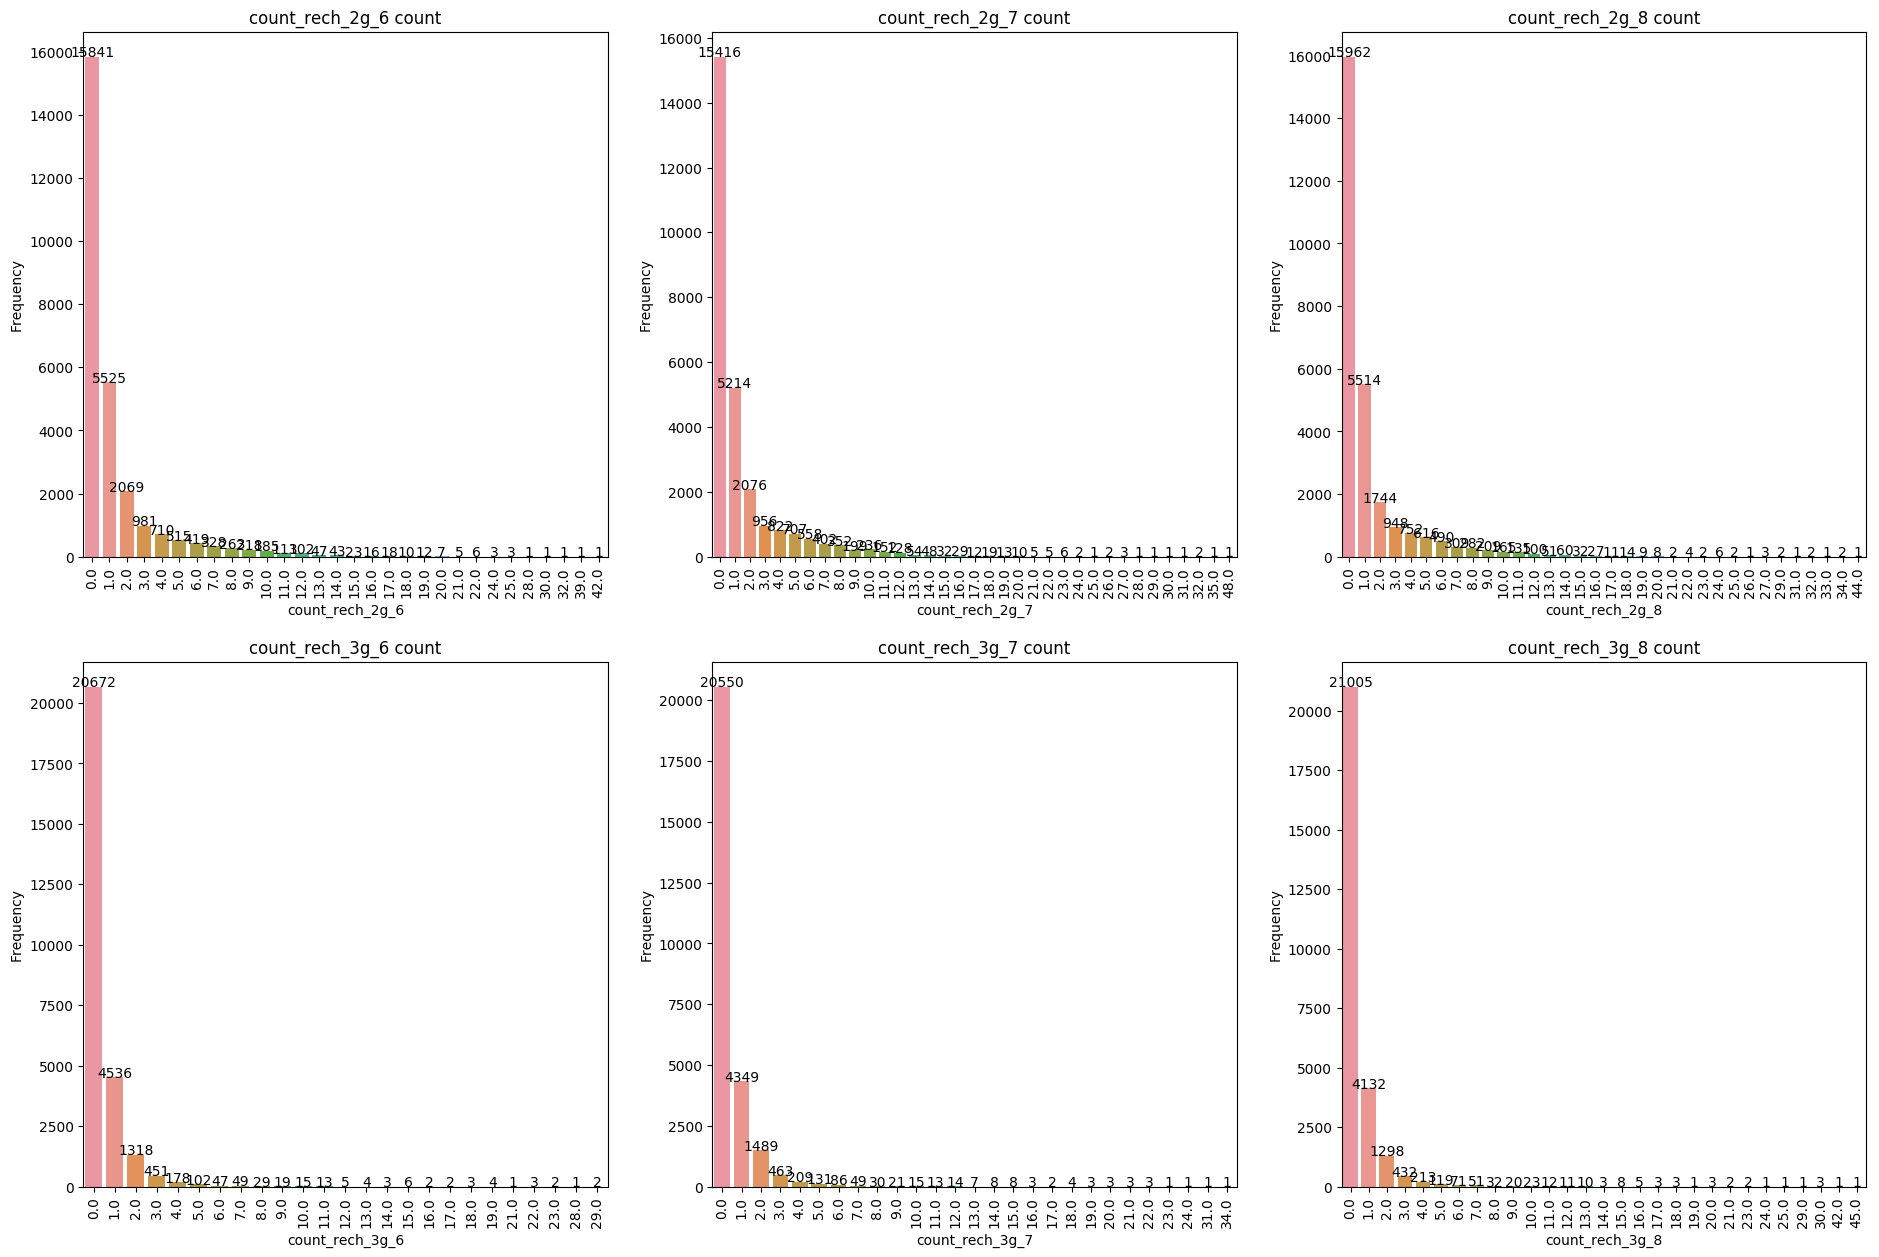

In [97]:
non_churn_count_rech_2g_6 = non_churned_df.groupby(non_churned_df.count_rech_2g_6).size().reset_index(name='Frequency')
non_churn_count_rech_2g_7 = non_churned_df.groupby(non_churned_df.count_rech_2g_7).size().reset_index(name='Frequency')
non_churn_count_rech_2g_8 = non_churned_df.groupby(non_churned_df.count_rech_2g_8).size().reset_index(name='Frequency')
non_churn_count_rech_3g_6 = non_churned_df.groupby(non_churned_df.count_rech_3g_6).size().reset_index(name='Frequency')
non_churn_count_rech_3g_7 = non_churned_df.groupby(non_churned_df.count_rech_3g_7).size().reset_index(name='Frequency')
non_churn_count_rech_3g_8 = non_churned_df.groupby(non_churned_df.count_rech_3g_8).size().reset_index(name='Frequency')

# Plotting the distribution plot to visualise their distribution
columnName = "count_rech_2g_6"
draw_bar_chart_subplot(non_churn_count_rech_2g_6, columnName, 'Frequency', columnName + ' count', columnName, 'Frequency',
                       23, 15, 90, None, '', True, False, 2, 3, 1)

columnName = "count_rech_2g_7"
draw_bar_chart_subplot(non_churn_count_rech_2g_7, columnName, 'Frequency', columnName + ' count', columnName, '', 23, 15, 
                       90, None, '', True, False, 2, 3, 2)

columnName = "count_rech_2g_8"
draw_bar_chart_subplot(non_churn_count_rech_2g_8, columnName, 'Frequency', columnName + ' count', columnName, '', 23, 15,
                       90, None, '', True, False, 2, 3, 3)

columnName = "count_rech_3g_6"
draw_bar_chart_subplot(non_churn_count_rech_3g_6, columnName, 'Frequency', columnName + ' count', columnName, 'Frequency', 
                       23, 15, 90, None, '', True, False, 2, 3, 4)

columnName = "count_rech_3g_7"
draw_bar_chart_subplot(non_churn_count_rech_3g_7, columnName, 'Frequency', columnName + ' count', columnName, '', 23, 15,
                       90, None, '', True, False, 2, 3, 5)

columnName = "count_rech_3g_8"
draw_bar_chart_subplot(non_churn_count_rech_3g_8, columnName, 'Frequency', columnName + ' count', columnName, '', 23, 15,
                       90, None, '', True, True, 2, 3, 6)

From the plots we can see a similar behaviour as above that for churned customers that count_rech_3g , count_rech_2g is reducing over period of months specially for higher values

### Churned Customers - Total Recharge data

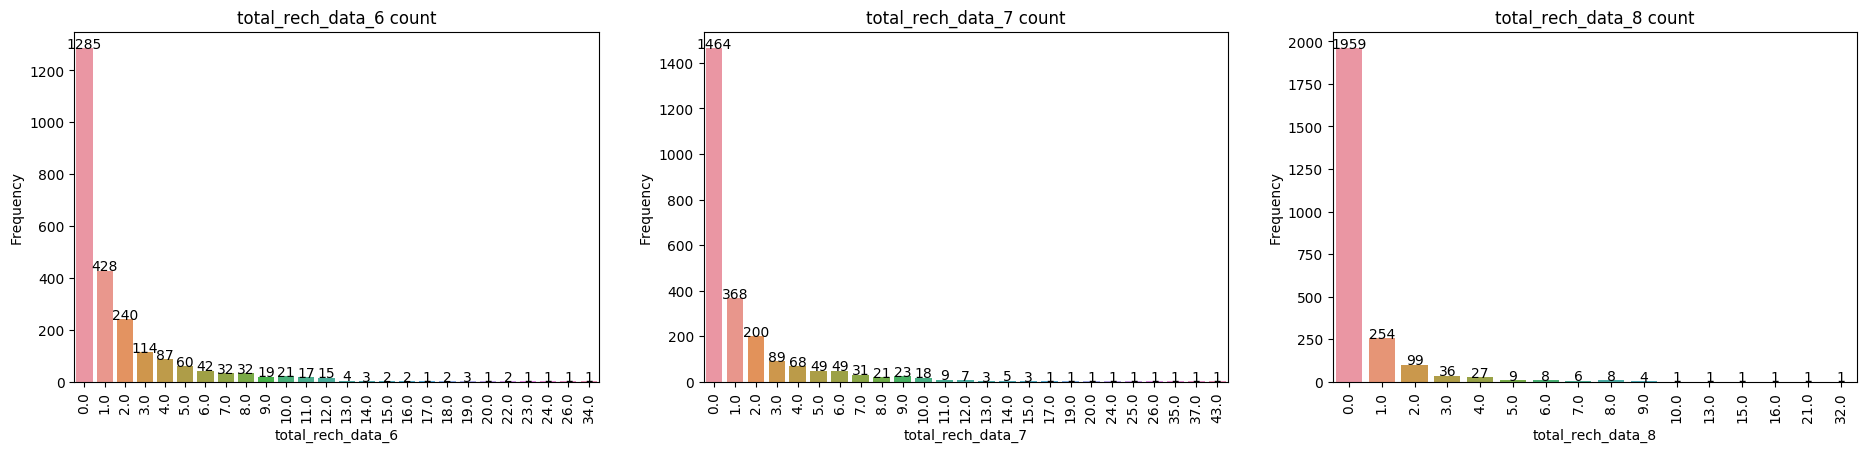

In [98]:
churn_total_rech_data_6_freq = churned_df.groupby(churned_df.total_rech_data_6).size().reset_index(name='Frequency')
churn_total_rech_data_7_freq = churned_df.groupby(churned_df.total_rech_data_7).size().reset_index(name='Frequency')
churn_total_rech_data_8_freq = churned_df.groupby(churned_df.total_rech_data_8).size().reset_index(name='Frequency')

# Plotting the distribution plot to visualise their distribution
columnName = "total_rech_data_6"
draw_bar_chart_subplot(churn_total_rech_data_6_freq, columnName, 'Frequency', columnName + ' count', columnName, 
                       'Frequency', 23, 10, 90,  None, '', True, False, 2, 3, 1)

columnName = "total_rech_data_7"
draw_bar_chart_subplot(churn_total_rech_data_7_freq, columnName, 'Frequency', columnName + ' count', columnName, '',
                       23, 10, 90, None, '', True, False, 2, 3, 2)

columnName = "total_rech_data_8"
draw_bar_chart_subplot(churn_total_rech_data_8_freq, columnName, 'Frequency', columnName + ' count', columnName, '',
                       23, 10, 90, None, '', True, True, 2, 3, 3)

### Non Churned Customers - Total Recharge data

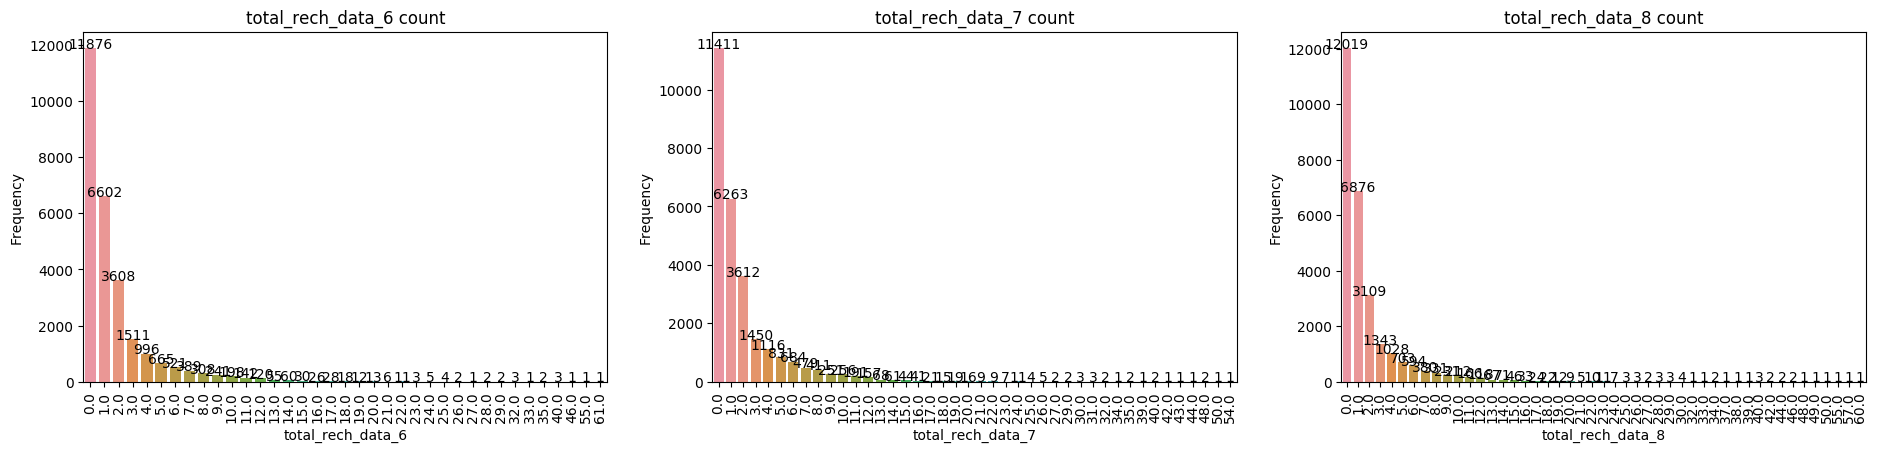

In [99]:
non_churn_total_rech_data_6_freq = non_churned_df.groupby(non_churned_df.total_rech_data_6).size().reset_index(name='Frequency')
non_churn_total_rech_data_7_freq = non_churned_df.groupby(non_churned_df.total_rech_data_7).size().reset_index(name='Frequency')
non_churn_total_rech_data_8_freq = non_churned_df.groupby(non_churned_df.total_rech_data_8).size().reset_index(name='Frequency')

# Plotting the distribution plot to visualise their distribution
columnName = "total_rech_data_6"
draw_bar_chart_subplot(non_churn_total_rech_data_6_freq, columnName, 'Frequency', columnName + ' count', columnName, 
                       'Frequency', 23, 10, 90, None, '', True, False, 2, 3, 1)

columnName = "total_rech_data_7"
draw_bar_chart_subplot(non_churn_total_rech_data_7_freq, columnName, 'Frequency', columnName + ' count', columnName, '',
                       23, 10, 90, None, '', True, False, 2, 3, 2)

columnName = "total_rech_data_8"
draw_bar_chart_subplot(non_churn_total_rech_data_8_freq, columnName, 'Frequency', columnName + ' count', columnName, '',
                       23, 10, 90, None, '', True, True, 2, 3, 3)

From the plots we can see a similar behaviour as above that for churned customers for month 8 as compared to 6 and 7 that total_rech_data is reducing over period of months specially for higher values

In [100]:
mem_usage()

848.375

### Outlier treatment 

In [101]:
master_df.describe(percentiles=[.25,.5,.75,.90,.95,.99,1])

arpu_2g_6     arpu_2g_7     arpu_2g_8     arpu_3g_6     arpu_3g_7  \
count  29883.000000  29883.000000  29883.000000  29883.000000  29883.000000   
mean      63.630988     64.904363     58.564184     67.221209     68.843327   
std      161.274655    165.560833    152.867784    179.454513    183.446128   
min      -15.320000    -15.480000    -24.430000    -30.280000    -26.040000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%       51.050000     48.055000     27.000000     35.000000     36.285000   
90%      212.170000    212.170000    212.170000    217.170000    216.168000   
95%      363.280000    374.365000    334.240000    398.480000    410.127000   
99%      676.527000    759.375000    712.532400    811.930000    819.705200   
100%    6433.760000   4809.360000   3467.170000   6362.280000   4980.900000   
max     6433.760000   4809.360000   3467.170000   6362.280000   4980.900000   

          arpu_3g_8        arpu_6        arpu_7        arpu_8  \
count  29883.000000  29883.000000  29883.000000  29883.000000   
mean      62.958469    559.003366    561.707816    509.275231   
std      170.416008    460.455009    480.353080    502.423815   
min      -24.490000  -2258.709000  -2014.045000   -945.808000   
25%        0.000000    310.660500    310.652500    231.807000   
50%        0.000000    482.843000    481.951000    427.621000   
75%       21.395000    700.495000    699.286500    662.467500   
90%      212.496000    994.362200    996.655200    978.325200   
95%      389.000000   1240.658400   1262.932500   1256.092300   
99%      795.656800   1983.511900   1999.596380   1987.080480   
100%    3716.900000  27731.088000  35145.834000  33543.624000   
max     3716.900000  27731.088000  35145.834000  33543.624000   

       av_rech_amt_data_6  av_rech_amt_data_7  av_rech_amt_data_8  \
count        29883.000000        29883.000000        29883.000000   
mean           131.005472          140.113480          122.366191   
std            200.585618          207.091575          195.802127   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%             50.000000           69.000000           25.000000   
75%            198.000000          211.000000          196.000000   
90%            308.000000          345.000000          308.000000   
95%            498.000000          504.000000          496.000000   
99%            813.720000          910.000000          907.000000   
100%          7546.000000         4365.000000         4061.000000   
max           7546.000000         4365.000000         4061.000000   

       count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  count_rech_3g_6  \
count     29883.000000     29883.000000     29883.000000     29883.000000   
mean          1.244018         1.400194         1.210789         0.428471   
std           2.506004         2.730132         2.541097         1.169777   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.000000         0.000000         0.000000   
50%           0.000000         0.000000         0.000000         0.000000   
75%           1.000000         1.000000         1.000000         0.000000   
90%           4.000000         5.000000         4.000000         1.000000   
95%           7.000000         7.000000         6.000000         2.000000   
99%          12.000000        12.000000        12.000000         5.000000   
100%         42.000000        48.000000        44.000000        29.000000   
max          42.000000        48.000000        44.000000        29.000000   

       count_rech_3g_7  count_rech_3g_8     fb_user_6     fb_user_7  \
count     29883.000000     29883.000000  29883.000000  29883.000000   
mean          0.457752         0.414282      0.518489      0.524579   
std           1.285020 

As we can see for almost all features the differnce between 99 and 100 percentile is quite huge indicating presence of heavy outliers beyond 99 percentile.

So we will cap the outliers for all the columns to 99 percentile.
Capping means any value above the 99 cutoff value will be imputed with the same value

#### Capping the dataset to 99 percentile

In [102]:
# Outlier Treatement of Columns capping at 99% percentile
for col in master_df.columns:
    upperlimit = master_df[col].quantile(0.99)
    master_df[col] = master_df[col].apply(lambda x: upperlimit if(x > upperlimit) else x)


In [103]:
master_df.describe(percentiles=[.25,.5,.75,.90,.95,.99,1])

arpu_2g_6     arpu_2g_7     arpu_2g_8     arpu_3g_6     arpu_3g_7  \
count  29883.000000  29883.000000  29883.000000  29883.000000  29883.000000   
mean      59.695747     60.974856     55.229985     63.209961     64.192304   
std      128.834960    134.284013    127.696620    146.130232    147.932387   
min      -15.320000    -15.480000    -24.430000    -30.280000    -26.040000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%       51.050000     48.055000     27.000000     35.000000     36.285000   
90%      212.170000    212.170000    212.170000    217.170000    216.168000   
95%      363.280000    374.365000    334.240000    398.480000    410.127000   
99%      676.504860    759.042900    712.358232    811.930000    819.684536   
100%     676.527000    759.375000    712.532400    811.930000    819.705200   
max      676.527000    759.375000    712.532400    811.930000    819.705200   

          arpu_3g_8        arpu_6        arpu_7        arpu_8  \
count  29883.000000  29883.000000  29883.000000  29883.000000   
mean      59.268018    549.114089    551.629763    498.811663   
std      142.404443    358.783416    361.677525    383.536414   
min      -24.490000  -2258.709000  -2014.045000   -945.808000   
25%        0.000000    310.660500    310.652500    231.807000   
50%        0.000000    482.843000    481.951000    427.621000   
75%       21.395000    700.495000    699.286500    662.467500   
90%      212.496000    994.362200    996.655200    978.325200   
95%      389.000000   1240.658400   1262.932500   1256.092300   
99%      795.470824   1983.223342   1999.553428   1986.905426   
100%     795.656800   1983.511900   1999.596380   1987.080480   
max      795.656800   1983.511900   1999.596380   1987.080480   

       av_rech_amt_data_6  av_rech_amt_data_7  av_rech_amt_data_8  \
count        29883.000000        29883.000000        29883.000000   
mean           126.634686          135.773571          118.896576   
std            168.371300          178.429581          172.796191   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%             50.000000           69.000000           25.000000   
75%            198.000000          211.000000          196.000000   
90%            308.000000          345.000000          308.000000   
95%            498.000000          504.000000          496.000000   
99%            813.129600          910.000000          907.000000   
100%           813.720000          910.000000          907.000000   
max            813.720000          910.000000          907.000000   

       count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  count_rech_3g_6  \
count     29883.000000     29883.000000     29883.000000     29883.000000   
mean          1.213098         1.359402         1.174514         0.393903   
std           2.313269         2.490166         2.311185         0.864727   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.000000         0.000000         0.000000   
50%           0.000000         0.000000         0.000000         0.000000   
75%           1.000000         1.000000         1.000000         0.000000   
90%           4.000000         5.000000         4.000000         1.000000   
95%           7.000000         7.000000         6.000000         2.000000   
99%          12.000000        12.000000        12.000000         5.000000   
100%         12.000000        12.000000        12.000000         5.000000   
max          12.000000        12.000000        12.000000         5.000000   

       count_rech_3g_7  count_rech_3g_8     fb_user_6     fb_user_7  \
count     29883.000000     29883.000000  29883.000000  29883.000000   
mean          0.415046         0.370846      0.518489      0.524579   
std           0.919873 

In [104]:
# print the list of columns with unique values less than 2
count = 0
cols = []
for col in master_df.columns:
    if master_df[col].nunique() < 2 or master_df[col].nunique() == nRow:
        count+=1
        print(count, " ColName = ", col,
              ",\t UniqueValues = ", master_df[col].unique(),
              ",\t Dtype = ", master_df[col].dtype)
        cols.append(col)

1  ColName =  og_others_7 ,	 UniqueValues =  [0.] ,	 Dtype =  float64
2  ColName =  og_others_8 ,	 UniqueValues =  [0.] ,	 Dtype =  float64


In [105]:
#So dropping columns og_others_7 and og_others_8 as both have single value 0 and no variance.
dropColumns(master_df, cols)

Dropping og_others_7 ...
Dropping og_others_8 ...


### Normalising the Data

In [106]:
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                            
                                              
# applying normalize ( ) to all columns 
master_df = master_df.apply(normalize)

In [107]:
master_df['churn'] = master_df['churn'].astype(np.uint8)
master_df['churn'].dtype

dtype('uint8')

## Model Building

#### Splitting Data into Training and Test Sets

In [108]:
# Putting feature variable to X
X = master_df.drop(['churn'],axis=1)

# Putting response variable to y
y = master_df['churn']

y.unique()

array([1, 0], dtype=uint64)

In [109]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

#### Check  for class imabalance
- Verify  the number of data point for Churn and non-churn category

In [110]:
count_class_0, count_class_1 = master_df.churn.value_counts()
count_class_0,count_class_1

(27467, 2416)

As the ratio of Non-churned to churned users is nearly 10:1 ,we should handle the imbalance by either up-sampling or down-sampling.
- Here we are using down-sampling as the churn-category has good number of data points(2416)

#### Handle class imbalance using SMOTE.
This will only be done for train data as test data should not be changed

In [111]:
sm = SMOTE(random_state=42)

columns = X_train.columns
X_train, y_train = sm.fit_sample(X_train, y_train)

In [112]:
X_train = pd.DataFrame(data=X_train,columns=columns )
y_train = pd.Series(y_train.tolist())

Look at fraction of churn data and confirm that the distribution rate improved

In [113]:
print(round(master_df['churn'].mean(), 2))
print(round(y_train.mean(), 2))
print(round(y_test.mean(), 2))

0.08
0.5
0.08


After Sampling using SMOTE the train data has 50% distribution which is a significant improvement from 8% initially.

Release memory by deleting unused dataframes

In [114]:
print(mem_usage()) # initial memory usage

# delete all objects which can hold reference to data frame and the temp dataframes 
del [[month_df, non_month_df, non_churned_df, churned_df]]
gc.collect() # garbage collect all deleted objects

# set to null
non_churned_df = pd.DataFrame()
churned_df = pd.DataFrame()

mem_usage() # memory usage after deleting the df

660.43359375


659.97265625

### PCA on the data

Computng the principal components, using the train data, and apply them later on the test data

In [115]:
X_train.shape

(38450, 172)

In [116]:
pca = PCA(svd_solver='randomized', random_state=42)
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

Doing the PCA on the train data

In [117]:
# Fit train data on pca
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

Plotting the principal components and try to make sense of them
- We'll plot original features on the first 2 principal components as axes

In [118]:
pca.components_

array([[ 1.02415821e-01,  9.40293505e-02,  7.88372210e-02, ...,
        -4.12685087e-03,  1.58748881e-02, -2.87527678e-03],
       [ 4.74755535e-02,  7.04950296e-02,  8.31297175e-02, ...,
         4.94234024e-03,  1.71073445e-02,  3.99542749e-03],
       [-1.85746645e-01, -1.23830494e-01, -8.50122278e-02, ...,
         1.59956827e-02,  2.32019306e-02,  1.22189352e-03],
       ...,
       [-1.15936977e-03,  5.00795532e-04, -3.16965199e-04, ...,
         9.29640005e-04, -2.01800140e-03, -1.06558321e-02],
       [-1.83990225e-04, -1.01848977e-04, -6.22387885e-04, ...,
        -9.34652261e-04,  5.95072847e-03, -3.65430135e-04],
       [-3.25559187e-04,  9.32222063e-04, -4.74874963e-04, ...,
         4.56793906e-04, -7.35383311e-04, -2.82329174e-03]])

In [119]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

PC1       PC2    Feature
0  0.102416  0.047476  arpu_2g_6
1  0.094029  0.070495  arpu_2g_7
2  0.078837  0.083130  arpu_2g_8
3  0.091544  0.050999  arpu_3g_6
4  0.091451  0.074538  arpu_3g_7

Check how the features are loaded after PCA

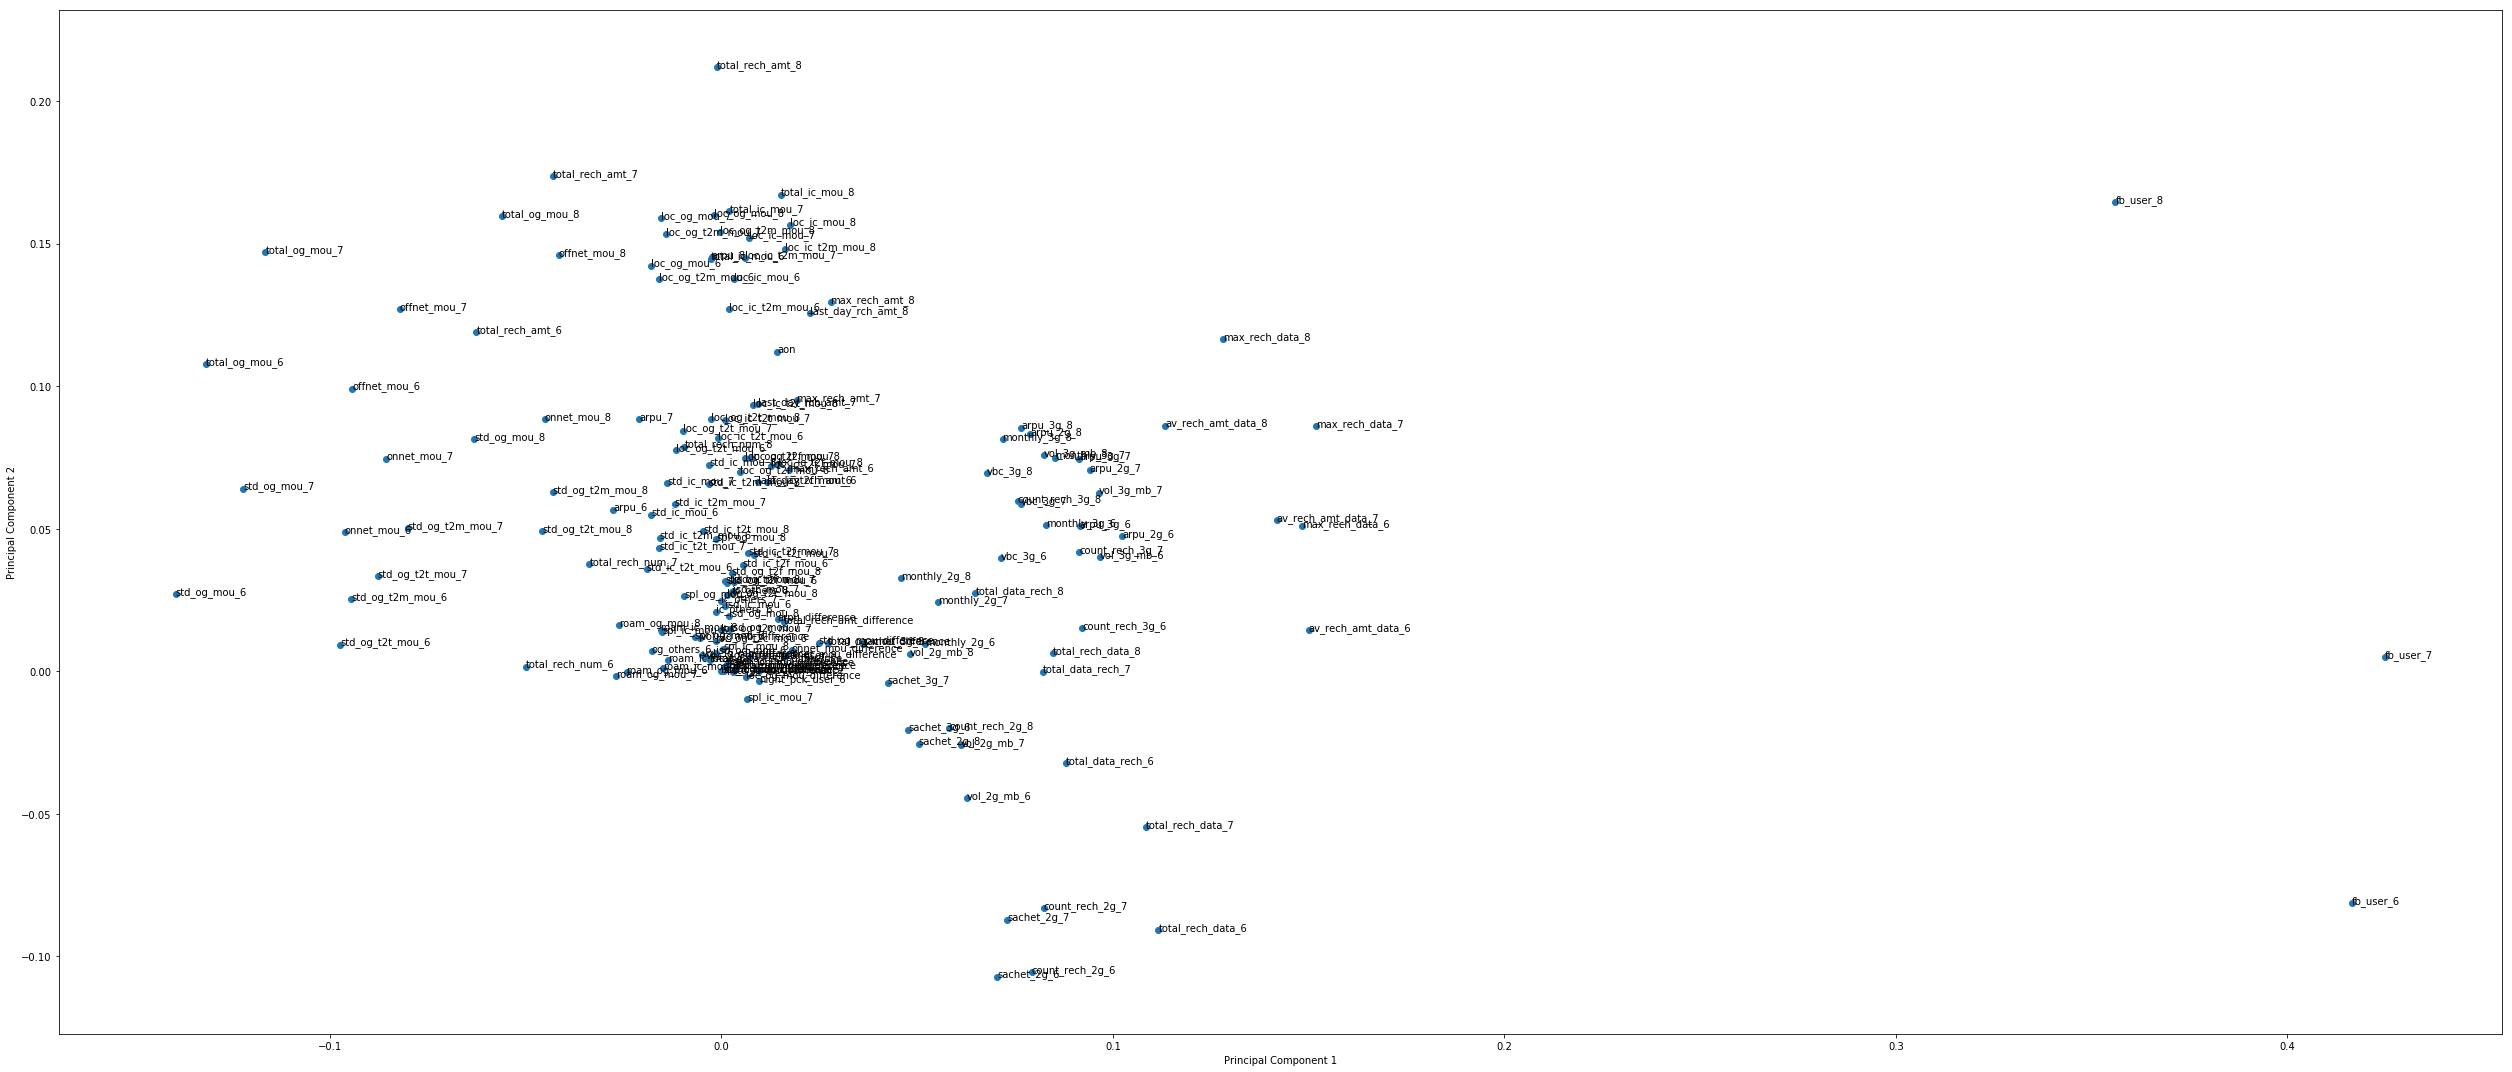

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (35, 15))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

We see that the fist component is in the direction where the data usage are heavy

And second varibale is in the direction where minutes of usage is heavy

Looking at the screeplot to assess the number of needed principal components

In [121]:
pca.explained_variance_ratio_

array([2.14826341e-01, 9.81344052e-02, 6.35733765e-02, 6.09443585e-02,
       4.11799645e-02, 3.29734137e-02, 2.99366686e-02, 2.87719162e-02,
       2.64771323e-02, 2.51013188e-02, 2.23683407e-02, 1.68025268e-02,
       1.37603732e-02, 1.29160786e-02, 1.25257227e-02, 1.16705186e-02,
       1.12816008e-02, 1.09450990e-02, 1.06400175e-02, 9.86553038e-03,
       9.68617262e-03, 8.82211322e-03, 8.64669392e-03, 8.50353735e-03,
       8.07435227e-03, 7.61866925e-03, 7.47380076e-03, 7.04608758e-03,
       6.87617178e-03, 6.41475907e-03, 6.08222429e-03, 5.54518905e-03,
       5.30734387e-03, 5.07163485e-03, 4.95576319e-03, 4.70942274e-03,
       4.62404862e-03, 4.55054713e-03, 4.29402568e-03, 4.13827864e-03,
       4.04947302e-03, 3.79696782e-03, 3.63659365e-03, 3.51474154e-03,
       3.49919565e-03, 3.38120317e-03, 3.34972424e-03, 3.27098792e-03,
       3.19732979e-03, 3.14734317e-03, 2.98870129e-03, 2.85991384e-03,
       2.82209242e-03, 2.63006716e-03, 2.59464266e-03, 2.49661099e-03,
      

Plotting the cumulative variance against the number of components¶

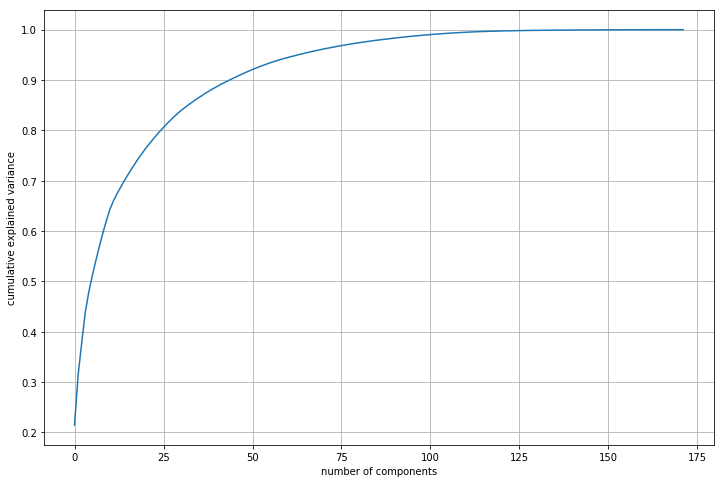

In [122]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

### Find the number of components that are enough to describe 90% of the variance in the dataset
- This plot tells us that selecting 45 components we can preserve something around 90% to 90.5% of the total variance of the data. 
- It makes sense, we’ll not use 100% of our variance, because it denotes all components, and we want only the principal ones. So we'll choose 90% of varience for our modeling

Let PCA select the number of components based on a variance cutoff we provide

In [123]:
pca_final = PCA(0.90)
df_train_pca = pca_final.fit_transform(X_train)
print(df_train_pca.shape)
pca_final.components_.shape

(38450, 45)


(45, 172)

Creating correlation matrix for the principal components - we expect little to no correlation

In [124]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

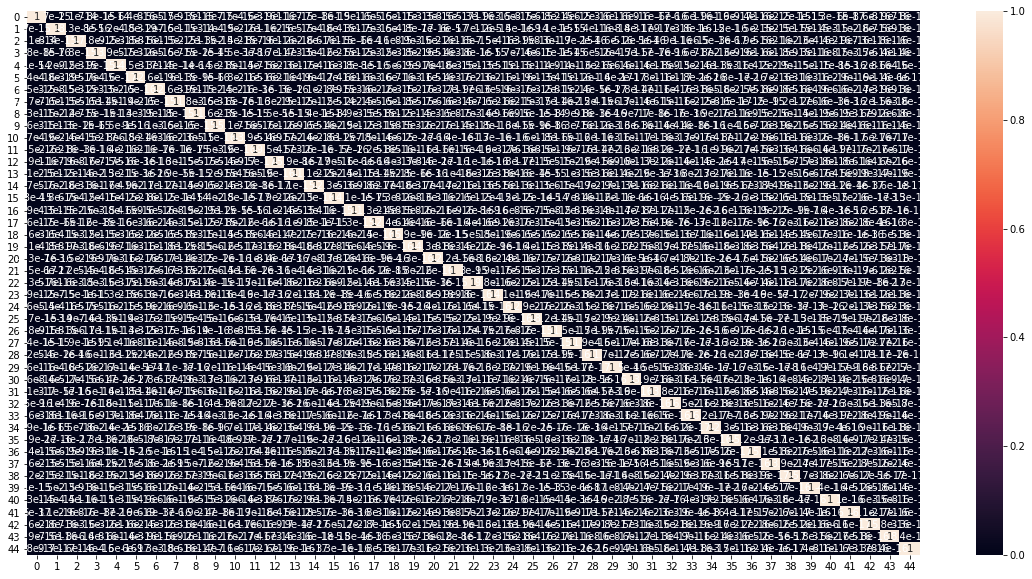

In [125]:
#plotting the correlation matrix
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [126]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 1.4024563165443191e-14 , min corr:  -2.099298352327643e-14


There are no correlation between any two components
- We effectively have removed mu`lticollinearity from our situation, and our models will be much more stable

Applying selected components to the test data

In [127]:
#Applying selected components to the test data - 24 components
df_test_pca = pca_final.transform(X_test)
print('Test Shape = ', df_test_pca.shape)

Test Shape =  (8965, 45)


### Logistic Regression with hyper parameter tuning

Applying a logistic regression on our Principal Components
- We expect to get similar model performance with significantly lower features
- If we can do so, we would have done effective dimensionality reduction without losing any import information

In [128]:
#training the regression model
logreg_pca = LogisticRegression(solver='liblinear')
model_logreg_pca = logreg_pca.fit(df_train_pca,y_train)
model_logreg_pca

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Create Hyperparameter Search Space

In [129]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
C

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])

In [130]:
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
hyperparameters

{'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
        5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
        3.59381366e+03, 1.00000000e+04]), 'penalty': ['l1', 'l2']}

Create Grid Search

In [131]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg_pca, hyperparameters, cv=5, n_jobs = -1, scoring='roc_auc', verbose=0)
clf

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Conduct Grid Search

In [ ]:
# Fit grid search
best_lr_PCA_model = clf.fit(df_train_pca,y_train)
best_lr_PCA_model

View Hyperparameter Values Of Best Model

In [ ]:
# View best hyperparameters
print('Best Penalty:', best_lr_PCA_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_lr_PCA_model.best_estimator_.get_params()['C'])

Predict probablity Using Best Model

In [ ]:
#Making predict probablity
pred_probs_test = best_lr_PCA_model.predict_proba(df_test_pca)[:,1]
pred_probs_test

Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

In [ ]:
roc_auc_score = "{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test))
print('roc_auc_score = ', roc_auc_score)

visualize the data of features selected by pca to see if we can spot any patterns

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()
plt.rcdefaults()

Let's look at it in 3D, and we expect spread to be better (dimensions of variance)

In [ ]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

%matplotlib inline  
#%matplotlib notebook
import matplotlib.pyplot as plt1

fig = plt1.figure(figsize=(8,8))

# Prior to version 1.0.0, the method of creating a 3D axes was different. 
# For those using older versions of matplotlib, use ax = Axes3D(fig) 
# else use ax = fig.add_subplot(111, projection='3d').
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

ax.scatter(df_train_pca[:,2], df_train_pca[:,0], df_train_pca[:,1], c=y_train.map({0:'green',1:'red'}))
plt1.show()

#### Make Predictions

In [ ]:
# Predict target vector
y_pred = best_lr_PCA_model.predict(df_test_pca)
y_pred

In [ ]:
# Converting pred_probs_test to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_probs_test)

# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Putting Mob_Num_id to index
y_test_df['Mob_Num_id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_df],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

# Rearranging the columns
y_pred_final = y_pred_final.reindex(['Mob_Num_id','churn','Churn_Prob'], axis=1)

y_pred_final.head()

In [ ]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_pred_final.head()

#### Logistic Regression with PCA Model Evaluation

Note that it is more important to identify churners than the non-churners accurately 
- Choose an appropriate evaluation metric which reflects this business goal.
    - Evaluate the Sensitivity and Specificity,
    - Choose a model which has more sensitivity (Number of actual churns currectly predicted / Total actual churns)

Confusion matrix, accuracy, sensitivity, specificity, false postive rate, positive predictive value, Negative predictive value

In [ ]:
compute_and_print_metrics_from_confusion_matrix(y_pred_final.churn, y_pred_final.predicted)

#### Precision, Recall and F1-Score
- Precision is the fraction of correctly predicted positives out of all predicted positives, i.e. it measures 'out of all those the model has predicted to be positive, how many are correct'. It differs from sensitivity only in the denominator.
- Recall is the same as sensitivity, and is commonly used along with precision.
- F1-score is a measure that combines both precision and recall. It is the harmonic mean of precision and recall

In [ ]:
print(classification_report( y_pred_final.churn, y_pred_final.predicted ))

#### ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [ ]:
draw_roc(y_pred_final.churn, y_pred_final.predicted)

#### Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

In [ ]:
probability_cutoffs( y_pred_final.churn, y_pred_final )

- From the curve and table above, 0.5 is the optimum point 
- But we need to tune out model for optimum sensitivity as the business rule says 
    - "It is more important to identify churners than the non-churners accurately"

#### Since we are tuning our model for more sensitivity we will take 0.3 as the cutoff for 88% sensitivity

In [ ]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)
y_pred_final.head(20)

In [ ]:
#Let's check the overall accuracy.
metrics.accuracy_score( y_pred_final.churn, y_pred_final.final_predicted)

In [ ]:
metrics.confusion_matrix( y_pred_final.churn, y_pred_final.final_predicted )

#### Precision, Recall and F1-Score

In [ ]:
print(classification_report(y_pred_final.churn, y_pred_final.final_predicted))

#### Evaluating Error Terms

Let's now evaluate the model in terms of its assumptions. We should test that:

- The error terms are normally distributed with mean approximately 0
- There is little correlation between the predictors
- Homoscedasticity, i.e. the 'spread' or 'variance' of the error term (y_true-y_pred) is constant

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Error terms
c = [i for i in range(len(y_pred_final.final_predicted))]
fig = plt.figure(figsize=(40, 15))
plt.plot(c, y_pred_final.churn-y_pred_final.final_predicted, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_pred_final.churn-y_pred_final.final_predicted),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

In [ ]:
# mean
np.mean(y_pred_final.churn-y_pred_final.final_predicted)

##### Infrence for Logisitc Regression with PCA
With Logistic Regression using PCA we are getting a model with 88% Senstivity/Recall and Mean error is -0.26 which pretty good now lets evaluate other models

### Convert PCA result data set to data frame

In [ ]:
pca_test = pd.DataFrame(df_test_pca)
pca_train = pd.DataFrame(df_train_pca)

print(pca_train.shape)
print(pca_test.shape)

pca_train.head()

### Decision Tree 

With Default parameters

In [ ]:
# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(pca_train, y_train)

Check the evaluation metrics of our default model

In [ ]:
# Making predictions
y_pred_default_dt = dt_default.predict(pca_test)

compute_and_print_metrics_from_confusion_matrix(y_test, y_pred_default_dt)
print(classification_report(y_test, y_pred_default_dt))

Even though we had good accuracy the recall / sensitivity score for default params is low so lets tune the hyperparameters with recall as scoring.

#### Grid Search to Find Optimal Hyperparameters

We can now use GridSearchCV to find multiple optimal hyperparameters together. Note that this time, we'll also specify the criterion (gini/entropy).

In [ ]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 17, 2),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search_dt = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                              cv = 4, verbose = 1, scoring='roc_auc', n_jobs = -1, return_train_score=True)

# Fit the grid search to the data
grid_search_dt.fit(pca_train,y_train)

In [ ]:
# cv results
cv_results = pd.DataFrame(grid_search_dt.cv_results_)
cv_results

In [ ]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy = ", grid_search_dt.best_score_)
print("\nbest_estimator = ", grid_search_dt.best_estimator_)

In [ ]:
cv_results[cv_results.mean_test_score > 0.85][['param_max_depth','mean_test_score']]

As we can see though the best score for recall comes with max_depth of 15 ,the recall score improvement is very minimal from depth 9 to 15.So we think its better to go with 9 as it decreases the complexity hence overfitting of the model quite a bit.

Running the model with best parameters obtained from grid search.

In [ ]:
# model with optimal hyperparameters
clf_entropy = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
clf_entropy.fit(pca_train, y_train)

In [ ]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz
import os

# If you're on windows:
# Specifing path for dot file.
if os.sys.platform == 'win32':
    if 'PROGRAMFILES' in os.environ:
        # os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'
        os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
    else:
        os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz2.38/bin/"

# plotting the tree
dot_data = StringIO()
export_graphviz(clf_entropy, out_file=dot_data,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
# Making predictions
y_pred_dt = clf_entropy.predict(pca_test)

In [ ]:
compute_and_print_metrics_from_confusion_matrix(y_test,y_pred_dt)

# classification metrics
print(classification_report(y_test, y_pred_dt))

#### Evaluating Error Terms

Let's now evaluate the model in terms of its assumptions. We should test that:

- The error terms are normally distributed with mean approximately 0
- There is little correlation between the predictors
- Homoscedasticity, i.e. the 'spread' or 'variance' of the error term (y_true-y_pred) is constant

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Error terms
c = [i for i in range(len(y_pred_dt))]
fig = plt.figure(figsize=(40, 15))
plt.plot(c, y_test-y_pred_dt, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred_dt),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

In [ ]:
# mean
np.mean(y_test-y_pred_dt)

##### Infrence for Decision Tree with PCA
With Decision Tree using PCA we are getting a model with 72% Senstivity/Recall which is low as compared to Logistic Regression model above

### Random Forest

Let's first fit a random forest model with default hyperparameters.

In [ ]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier()
# fit
rfc.fit(pca_train,y_train)

In [ ]:
# Making predictions
rfc_predictions = rfc.predict(pca_test)

In [ ]:
compute_and_print_metrics_from_confusion_matrix(y_test, rfc_predictions)
print(classification_report(y_test, rfc_predictions))

Even though we had good accuracy the recall / sensitivity score for default params is low so lets tune the hyperparameters with recall as scoring.

#### Tuning max_depth

Let's try to find the optimum values for max_depth and understand how the value of max_depth impacts the overall accuracy of the ensemble.

In [ ]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# parameters to build the model on
parameters = {'n_estimators': [10], 'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=4, n_jobs = -1, scoring="roc_auc", return_train_score=True)
rf.fit(pca_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that as we increase the value of max_depth, both train and test scores increase till 6 after that increase is marginal

We can use the range 4 to 6 as optimal value.

In [ ]:
max_depth = range(4, 6, 1)
max_depth

#### Tuning n_estimators
Let's try to find the optimum values for n_estimators and understand how the value of n_estimators impacts the overall accuracy. Notice that we'll specify an appropriately low value of max_depth, so that the trees do not overfit. 

In [ ]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 700, 200)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=3)

# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=4, n_jobs = -1, scoring="roc_auc", return_train_score=True)
rf.fit(pca_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that as we increase the value of n_estimators, both train and test scores increase till 300 after that both test and trian score increases marginally.

We can use 100 to 300.

In [ ]:
n_estimators = [100, 300]

#### Tuning max_features
Let's see how the model performance varies with max_features, which is the maximum numbre of features considered for splitting at a node.

In [ ]:
# parameters to build the model on
parameters = {'n_estimators': [10], 'max_features': [3, 5, 7, 9, 11, 13]}

# instantiate the model
rf = RandomForestClassifier(max_depth=4)

# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=4, n_jobs = -1, scoring="roc_auc", return_train_score=True)
rf.fit(pca_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Apparently, the training and test scores both seem to increase till 5, and then decerase.

In [ ]:
max_features = [4, 5, 6]

#### Tuning min_samples_leaf

Check the optimum value for min samples leaf in our case

The hyperparameter **min_samples_leaf** is the minimum number of samples required to be at a leaf node:
- If int, then consider min_samples_leaf as the minimum number.
- If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

In [ ]:
# parameters to build the model on
parameters = {'n_estimators': [10], 'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=4, n_jobs = -1, scoring="roc_auc", return_train_score=True)
rf.fit(pca_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can use the range 100 to 150 for  min_samples_leaf.

In [ ]:
min_samples_leaf = range(100, 150, 50)

#### Tuning min_samples_split
Let's now look at the performance of the ensemble as we vary min_samples_split.

In [ ]:
# parameters to build the model on
parameters = {'n_estimators': [10], 'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=4, n_jobs = -1, scoring="roc_auc", return_train_score=True)
rf.fit(pca_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can use 400 to 450 as the range

In [ ]:
min_samples_split = range(400, 450, 50)

#### Grid Search to find Optimal Hyperparameters

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'max_features': max_features
}

print(param_grid)

In [ ]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search_rfc = GridSearchCV(estimator = rf, param_grid = param_grid, 
                               cv = 4, n_jobs = -1, verbose = 1, scoring='roc_auc')

In [ ]:
# Fit the grid search to the data
grid_search_rfc.fit(pca_train, y_train)

In [ ]:
# printing the optimal accuracy score and hyperparameters
print(f'Accuracy = {grid_search_rfc.best_score_}\n')
print('Best Params')
print(grid_search_rfc.best_params_)

Fitting the final model with the best parameters for recall / sensitivity obtained from grid search.

In [ ]:
# model with the best hyperparameters
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=4,
                             min_samples_leaf=150, 
                             min_samples_split=350,
                             max_features=5,
                             n_estimators=50)

In [ ]:
# fit
rfc.fit(X_train,y_train)

In [ ]:
# predict
predictions = rfc.predict(X_test)

In [ ]:
compute_and_print_metrics_from_confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))

#### Evaluating Error Terms

Let's now evaluate the model in terms of its assumptions. We should test that:

- The error terms are normally distributed with mean approximately 0
- There is little correlation between the predictors
- Homoscedasticity, i.e. the 'spread' or 'variance' of the error term (y_true-y_pred) is constant

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Error terms
c = [i for i in range(len(predictions))]
fig = plt.figure(figsize=(40, 15))
plt.plot(c, y_test-predictions, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-predictions),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

In [ ]:
# mean
np.mean(y_test-predictions)

The random forest doesnt seems to give good sensitivity value hence we will not recommend this model

##### Infrence for Random Forest with PCA
With Random Forest using PCA we are getting a model with 74% Senstivity/Recall which is low as compared to Logistic Regression model above

### SVM - Model Building

Non-Linear SVM

In [ ]:
# using rbf kernel, C=1, default value of gamma
model = SVC(C = 1, kernel='rbf')
model.fit(pca_train, y_train)

y_pred_svc = model.predict(pca_test)

In [ ]:
compute_and_print_metrics_from_confusion_matrix(y_test, y_pred_svc)
print(classification_report(y_test, y_pred_svc))

Even though we had good accuracy the recall / sensitivity score is low so lets try tuning the hyperparameters with recall as scoring.

#### SVM - Grid Search to Find Optimal Hyperparameters

Let's first use the RBF kernel to find the optimal C and gamma (we can consider the kernel as a hyperparameter as well, though training the model will take an exorbitant amount of time).

##Hyperparameter Tuning Hyperparameters to optimise - The choice of kernel (linear, rbf etc.) C gamma We'll use the GridSearchCV() method to tune the hyperparameters.

In [ ]:
# creating a KFold object with 4 splits 
folds = KFold(n_splits = 4, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring='roc_auc',
                        cv = folds,
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(pca_train, y_train)

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

plt.show()

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

In [ ]:
# specify optimal hyperparameters and model
model = SVC(C=1000, gamma=0.01, kernel="rbf")

model.fit(pca_train, y_train)
y_pred_svc = model.predict(pca_test)

In [ ]:
# metrics
compute_and_print_metrics_from_confusion_matrix(y_test, y_pred_svc)
print(classification_report(y_test, y_pred_svc))
print("precision = ", metrics.precision_score(y_test, y_pred_svc))

#### Evaluating Error Term

Let's now evaluate the model in terms of its assumptions. We should test that:

- The error terms are normally distributed with mean approximately 0
- There is little correlation between the predictors
- Homoscedasticity, i.e. the 'spread' or 'variance' of the error term (y_true-y_pred) is constant

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Error terms
c = [i for i in range(len(y_pred_svc))]
fig = plt.figure(figsize=(40, 15))
plt.plot(c, y_test-y_pred_svc, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred_svc),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

In [ ]:
# mean
np.mean(y_test-y_pred_svc)

##### Infrence for SVM with PCA
With SVM using PCA we are getting a model with 73% Senstivity/Recall which is low as compared to Logistic Regression model above

## Final Inference for Model Selection with PCA - Assignment Part 1
We are getting the best senstivity of 88% using Logistic Regression Model compared to Decision Tree, Random Forest and SVM 
Also SVM and Random Forest are computationaly intensive as compared to Logistic Regression.

### It is recommended to use Logistic Regression

### Model Building without PCA - to identify the important features for churn - Assignment Part 2

Though we have build the models using PCA to predict the churner,it is very diffcult to interpret the principal components to indicate which features majorly contribute to the churn.Hence the need to build model without PCA to identify the important features for churning

#### Logistic Regression

Tune the hyperparameter to select the optimum number of feature for RFE using GridSearchCV

In [ ]:
# creating a KFold object with 4 splits 
folds = KFold(n_splits = 4, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': [9,11,13]}]

# specify model
LogRegModel_noPCA = LogisticRegression(solver='liblinear')
LogRegModel_noPCA.fit(X_train, y_train)
rfe = RFE(LogRegModel_noPCA)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'roc_auc', 
                        cv = folds,
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)     

In [ ]:
model_cv.fit(X_train, y_train)

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
%matplotlib inline
# plotting cv results
plt.figure(figsize=(10,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('roc-auc')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.show()

It can be observed from the above table and figure that we get mean test score of 0.896 and after that the increase is marginal so we decide to build model with 9 features.

In [ ]:
LogRegModel_noPCA_final = LogisticRegression(solver='liblinear')
rfe_final = RFE(LogRegModel_noPCA,9)   
rfe_final = rfe_final.fit(X,y)

print(rfe_final.support_)           # Printing the boolean results
print(rfe_final.ranking_)

Select only the features as selected by RFE for further analysis

In [ ]:
X_train_final = X_train.iloc[:,rfe_final.support_]
X_test_final = X_test.iloc[:,rfe_final.support_]

X_train_final.info()

Build a Logistic Regression model and analyse the summary

In [ ]:
logsk = LogisticRegression(solver='liblinear')
logsk.fit(X_train_final, y_train)

In [ ]:
import statsmodels.api as sm
logm = sm.GLM(y_train,(sm.add_constant(X_train_final)), family = sm.families.Binomial())
logm.fit().summary()

It can be observed there are still few columns like "loc_ic_t2m_mou_8" which has p-value more than 0.05

Lets check the vif of the feature to see strong corelation exists between feature

In [ ]:
Cols = X_train_final.columns
Cols  = Cols.insert(11,'churn')
Cols

In [ ]:
vif_cal(input_data=master_df[Cols], dependent_col='churn')

Observe that the field "loc_ic_t2m_mou_8" also has high VIF(>4)> along with high P  value hence we can delete the feature and proceed with analysis

Drop the feature "loc_ic_t2m_mou_8" and redo the logistic regression analysis

In [ ]:
try:
    Cols = Cols.drop('loc_ic_t2m_mou_8')
except:
    print("Column name not present")
logsk = RedoLogisticModel(['loc_ic_t2m_mou_8'])

In [ ]:
vif_cal(input_data=master_df[Cols], dependent_col='churn')

Observe that the field "loc_ic_mou_8" whcih has high VIF(>4)>Hence we can delete the feature and proceed with analysis

Drop the feature "loc_ic_mou_8" and redo the logistic regression analysis

In [ ]:
try:
    Cols = Cols.drop('loc_ic_mou_8')
except:
    print("Column name not present")
logsk = RedoLogisticModel(['loc_ic_mou_8'])

Lets have a look a the VIF table 

In [ ]:
vif_cal(input_data=master_df[Cols], dependent_col='churn')

The VIFs although above 4 for "total_ic_mou_7" and "total_ic_mou_8"	but since p value is 0 for these features and from buisness need they are important so we decide to keep them as key features.

So we can finalise these features and see the model performance 

Predict the probability of y('churn') using the final model and selected features and put it in a DataFrame

In [ ]:
y_pred = logsk.predict_proba(X_test[X_train_final.columns])

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

y_test_df.head()

In [ ]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

Merging the Actual and predcited 'churn' into one dataFrame for ease of analysis and visualisation

In [ ]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})

y_pred_final.head()

To start with the model evaluation lets take the churn probability more than 50% and churned else non-churn

In [ ]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_pred_final.head()

Anlayse the Confusion metrics and observe the values for accuracy,sensitivity and specificity. 

As in this case it is more important to predict the churned customers correctly ,We should be concentrating more on high sensitvity or recall value

In [ ]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

In [ ]:
compute_and_print_metrics_from_confusion_matrix(y_pred_final.churn, y_pred_final.predicted)
print("precision = ", metrics.precision_score(y_pred_final.churn, y_pred_final.predicted))

In [ ]:
draw_roc(y_pred_final.churn, y_pred_final.predicted)

In [ ]:
print(classification_report(y_pred_final.churn, y_pred_final.predicted))

As we can see above the Sensitivity is nearly 82% ,it appears to be a good model for prediction. Though it can be further tuned to improve the sensitivity or recall score.

Lets do that by anaysing the the sensitivity and specificity for diffrent values of probability cutoff.

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
probability_cutoffs(y_pred_final.churn, y_pred_final)

As we can see from the above plot that having a probability cut-off of 30% , the sensitivity is at 91% with fairly good accuracy and specificity as well. So we can take 0.3 as prob cut off

In [ ]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)

print(classification_report(y_pred_final.churn, y_pred_final.final_predicted))

#### Evaluating Error Terms

Let's now evaluate the model in terms of its assumptions. We should test that:

- The error terms are normally distributed with mean approximately 0
- There is little correlation between the predictors
- Homoscedasticity, i.e. the 'spread' or 'variance' of the error term (y_true-y_pred) is constant

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Error terms
c = [i for i in range(len(y_pred_final.final_predicted))]
fig = plt.figure(figsize=(40, 15))
plt.plot(c, y_pred_final.churn-y_pred_final.final_predicted, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_pred_final.churn-y_pred_final.final_predicted),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

In [ ]:
# mean
np.mean(y_pred_final.churn-y_pred_final.final_predicted)

###### As we have got  a fairly good logistic regression model with nearly 91% sensitivity, that is 91% accuracy in predicting the churns we can conclude the feature used to build this final model effects the churning most .
The feature names are as follows:

In [ ]:
i = 1
print('Features effects the churning most are')
for col in Cols:
    if col != 'churn':
        print(f'{i}. {col}')
        i=i+1

In [ ]:
coefs = logsk.coef_[0]
coefs = coefs.tolist()

try:
    Cols = Cols.drop('churn')
except:
    print("Column name not present")

coef_df = pd.DataFrame({'Feature Name': Cols,
                         'Coeffiecient(effect on churn)': coefs,
                        })

## Conclusion :

##### Below table showing key features effecting the Churn and there respective coefficients/weights 

In [ ]:
coef_df.head(7)

### Key Recommendations :
1. Voice usage(incoming) in mostly "action phase" seems a key feature in determining the Churn and hence company should keep track on the voice usage and also provide incentives/offers to users who are categorised by the model as potential churners

2. Difference or change(decrease) in the arpu should be taken as key hint for the user to churn and necessary  action should be taken to for the user showing significant change in the arpu

3. Recharge amount is a key indicator to decide if customer is likely to churn or not